In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=False
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=10
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=4096 #Number of units in hidden layer 1
# hidden2=1024 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=4096
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
# randFeatureSubset=None
model_str='fc1_dca'
clf=None
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

training_samples='control13'
training_sample_X='logminmax'
standardizeX=False
name='c13k20XA_FCXonly_01_dca_over'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    


adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adj_train=adj_list[training_samples]
features=featureslist[training_samples+'X_'+training_sample_X]
if 'dca' in model_str:
    rawdata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw=rawdata.X[rawdata.obs['sample']==sampleidx[training_samples]]
    

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
maskpath=os.path.join(savedir,'trainMask',training_samples+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
if useSavedMaskedEdges and os.path.exists(maskpath):
    print('opening saved')
    with open(maskpath, 'rb') as input:
        maskedgeres = pickle.load(input)
else:
    # construct training, validation, and test sets
    maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
    with open(maskpath, 'wb') as output:
        pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)


In [5]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [6]:
# loop over all train/validation sets
train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres

adj_norm = preprocessing.preprocess_graph(adj_train)
adj_label=adj_train + sp.eye(adj_train.shape[0])
adj_label=torch.tensor(adj_label.todense())
adj_decode=None
if adj_decodeName == 'gala':
    adj_decode=preprocessing.preprocess_graph_sharp(adj_train)

num_nodes,num_features = features.shape

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
pos_weight = float(adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) / adj_train.sum() #using full unmasked adj
pos_weight=torch.tensor(pos_weight)
norm = adj_train.shape[0] * adj_train.shape[0] / float((adj_train.shape[0] * adj_train.shape[0] - adj_train.sum()) * 2)

if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    features = features.cuda().float()
    adj_norm=adj_norm.cuda()
    adj_label = adj_label.cuda().float()
    if adj_decode is not None:
        adj_decode=adj_decode.cuda()
    train_nodes_idx=train_nodes_idx.cuda()
    val_nodes_idx=val_nodes_idx.cuda()
    test_nodes_idx=test_nodes_idx.cuda()

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:

 
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
        
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    if 'dca' in model_str:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,torch.tensor(features_raw).cuda())
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
#     loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
    loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if 'dca' in model_str:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,torch.tensor(features_raw).cuda())
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
#     loss_val = loss_x_val+loss_a_val
    loss_val=loss_x_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    
#     print(features_recon[:5,:5])
    print('Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    else:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item()

# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
t_ep=time.time()
for ep in range(epochs):
#     train_loss_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep]=train(ep)
#     train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep]=train(ep)
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
print('total time: {:.4f}s'.format(time.time() - t_ep))


Epoch: 0000 loss_train: 8.2422 loss_kl_train: 0.4815 loss_x_train: 7.7607 loss_a_train: 123.3014 loss_val: 7.5923 loss_x_val: 7.5923 loss_a_val: 1.0325 time: 0.9080s
Epoch: 0001 loss_train: 4.3417 loss_kl_train: 0.3509 loss_x_train: 3.9908 loss_a_train: 115.3808 loss_val: 7.3191 loss_x_val: 7.3191 loss_a_val: 1.2294 time: 0.7836s
Epoch: 0002 loss_train: 3.1594 loss_kl_train: 0.3056 loss_x_train: 2.8538 loss_a_train: 111.7717 loss_val: 7.2032 loss_x_val: 7.2032 loss_a_val: 1.4712 time: 0.7782s
Epoch: 0003 loss_train: 2.8368 loss_kl_train: 0.2777 loss_x_train: 2.5590 loss_a_train: 110.0271 loss_val: 6.1073 loss_x_val: 6.1073 loss_a_val: 1.3707 time: 0.7804s
Epoch: 0004 loss_train: 2.7570 loss_kl_train: 0.2596 loss_x_train: 2.4974 loss_a_train: 107.8595 loss_val: 5.4902 loss_x_val: 5.4902 loss_a_val: 1.2364 time: 0.7829s
Epoch: 0005 loss_train: 2.6186 loss_kl_train: 0.2458 loss_x_train: 2.3727 loss_a_train: 106.1690 loss_val: 5.0405 loss_x_val: 5.0405 loss_a_val: 1.4016 time: 0.7804s
Epoc

Epoch: 0050 loss_train: 1.5143 loss_kl_train: 0.1230 loss_x_train: 1.3913 loss_a_train: 93.8484 loss_val: 1.4958 loss_x_val: 1.4958 loss_a_val: 71.0282 time: 0.7936s
Epoch: 0051 loss_train: 1.5080 loss_kl_train: 0.1218 loss_x_train: 1.3862 loss_a_train: 93.6616 loss_val: 1.4819 loss_x_val: 1.4819 loss_a_val: 71.2683 time: 0.7906s
Epoch: 0052 loss_train: 1.5037 loss_kl_train: 0.1204 loss_x_train: 1.3833 loss_a_train: 92.7728 loss_val: 1.4698 loss_x_val: 1.4698 loss_a_val: 71.5076 time: 0.7916s
Epoch: 0053 loss_train: 1.4991 loss_kl_train: 0.1191 loss_x_train: 1.3800 loss_a_train: 92.8924 loss_val: 1.4605 loss_x_val: 1.4605 loss_a_val: 71.7749 time: 0.7906s
Epoch: 0054 loss_train: 1.4995 loss_kl_train: 0.1180 loss_x_train: 1.3816 loss_a_train: 92.4689 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 72.1455 time: 0.7936s
Epoch: 0055 loss_train: 1.4929 loss_kl_train: 0.1167 loss_x_train: 1.3762 loss_a_train: 92.1362 loss_val: 1.4459 loss_x_val: 1.4459 loss_a_val: 72.5244 time: 0.7919s
Epoc

Epoch: 0100 loss_train: 1.4234 loss_kl_train: 0.0753 loss_x_train: 1.3481 loss_a_train: 74.1959 loss_val: 1.3923 loss_x_val: 1.3923 loss_a_val: 87.9414 time: 0.7983s
Epoch: 0101 loss_train: 1.4227 loss_kl_train: 0.0747 loss_x_train: 1.3480 loss_a_train: 73.7530 loss_val: 1.3926 loss_x_val: 1.3926 loss_a_val: 88.0431 time: 0.7976s
Epoch: 0102 loss_train: 1.4218 loss_kl_train: 0.0741 loss_x_train: 1.3477 loss_a_train: 73.4098 loss_val: 1.3929 loss_x_val: 1.3929 loss_a_val: 88.1396 time: 0.8003s
Epoch: 0103 loss_train: 1.4209 loss_kl_train: 0.0733 loss_x_train: 1.3476 loss_a_train: 73.2369 loss_val: 1.3934 loss_x_val: 1.3934 loss_a_val: 88.2048 time: 0.8015s
Epoch: 0104 loss_train: 1.4203 loss_kl_train: 0.0729 loss_x_train: 1.3474 loss_a_train: 72.9389 loss_val: 1.3938 loss_x_val: 1.3938 loss_a_val: 88.2436 time: 0.7994s
Epoch: 0105 loss_train: 1.4194 loss_kl_train: 0.0722 loss_x_train: 1.3471 loss_a_train: 72.4363 loss_val: 1.3943 loss_x_val: 1.3943 loss_a_val: 88.2407 time: 0.7973s
Epoc

Epoch: 0150 loss_train: 1.3915 loss_kl_train: 0.0508 loss_x_train: 1.3407 loss_a_train: 58.1464 loss_val: 1.4497 loss_x_val: 1.4497 loss_a_val: 84.5807 time: 0.8015s
Epoch: 0151 loss_train: 1.3910 loss_kl_train: 0.0503 loss_x_train: 1.3407 loss_a_train: 57.9194 loss_val: 1.4518 loss_x_val: 1.4518 loss_a_val: 84.5056 time: 0.7972s
Epoch: 0152 loss_train: 1.3904 loss_kl_train: 0.0500 loss_x_train: 1.3403 loss_a_train: 57.7436 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 84.4597 time: 0.8056s
Epoch: 0153 loss_train: 1.3901 loss_kl_train: 0.0497 loss_x_train: 1.3404 loss_a_train: 57.4704 loss_val: 1.4561 loss_x_val: 1.4561 loss_a_val: 84.4458 time: 0.8034s
Epoch: 0154 loss_train: 1.3895 loss_kl_train: 0.0493 loss_x_train: 1.3402 loss_a_train: 57.2579 loss_val: 1.4579 loss_x_val: 1.4579 loss_a_val: 84.3542 time: 0.8093s
Epoch: 0155 loss_train: 1.3890 loss_kl_train: 0.0490 loss_x_train: 1.3400 loss_a_train: 57.1039 loss_val: 1.4596 loss_x_val: 1.4596 loss_a_val: 84.2226 time: 0.8029s
Epoc

Epoch: 0200 loss_train: 1.3722 loss_kl_train: 0.0363 loss_x_train: 1.3359 loss_a_train: 47.0946 loss_val: 1.5306 loss_x_val: 1.5306 loss_a_val: 78.8151 time: 0.8011s
Epoch: 0201 loss_train: 1.3722 loss_kl_train: 0.0362 loss_x_train: 1.3360 loss_a_train: 46.7501 loss_val: 1.5328 loss_x_val: 1.5328 loss_a_val: 78.7086 time: 0.8020s
Epoch: 0202 loss_train: 1.3716 loss_kl_train: 0.0358 loss_x_train: 1.3358 loss_a_train: 46.5959 loss_val: 1.5349 loss_x_val: 1.5349 loss_a_val: 78.5597 time: 0.8036s
Epoch: 0203 loss_train: 1.3714 loss_kl_train: 0.0356 loss_x_train: 1.3358 loss_a_train: 46.6465 loss_val: 1.5371 loss_x_val: 1.5371 loss_a_val: 78.4308 time: 0.8061s
Epoch: 0204 loss_train: 1.3712 loss_kl_train: 0.0355 loss_x_train: 1.3357 loss_a_train: 46.4770 loss_val: 1.5386 loss_x_val: 1.5386 loss_a_val: 78.1846 time: 0.8043s
Epoch: 0205 loss_train: 1.3708 loss_kl_train: 0.0353 loss_x_train: 1.3355 loss_a_train: 46.2275 loss_val: 1.5398 loss_x_val: 1.5398 loss_a_val: 77.9267 time: 0.8003s
Epoc

Epoch: 0250 loss_train: 1.3597 loss_kl_train: 0.0272 loss_x_train: 1.3325 loss_a_train: 39.8046 loss_val: 1.6466 loss_x_val: 1.6466 loss_a_val: 71.5918 time: 0.8102s
Epoch: 0251 loss_train: 1.3594 loss_kl_train: 0.0270 loss_x_train: 1.3324 loss_a_train: 39.6019 loss_val: 1.6504 loss_x_val: 1.6504 loss_a_val: 71.5885 time: 0.8027s
Epoch: 0252 loss_train: 1.3592 loss_kl_train: 0.0269 loss_x_train: 1.3323 loss_a_train: 39.4998 loss_val: 1.6545 loss_x_val: 1.6545 loss_a_val: 71.6083 time: 0.8021s
Epoch: 0253 loss_train: 1.3591 loss_kl_train: 0.0268 loss_x_train: 1.3322 loss_a_train: 39.3040 loss_val: 1.6586 loss_x_val: 1.6586 loss_a_val: 71.6582 time: 0.8048s
Epoch: 0254 loss_train: 1.3589 loss_kl_train: 0.0267 loss_x_train: 1.3322 loss_a_train: 39.2373 loss_val: 1.6635 loss_x_val: 1.6635 loss_a_val: 71.6723 time: 0.8105s
Epoch: 0255 loss_train: 1.3586 loss_kl_train: 0.0265 loss_x_train: 1.3321 loss_a_train: 39.2446 loss_val: 1.6682 loss_x_val: 1.6682 loss_a_val: 71.6539 time: 0.8028s
Epoc

Epoch: 0300 loss_train: 1.3508 loss_kl_train: 0.0211 loss_x_train: 1.3296 loss_a_train: 34.9177 loss_val: 1.8077 loss_x_val: 1.8077 loss_a_val: 65.6866 time: 0.8082s
Epoch: 0301 loss_train: 1.3506 loss_kl_train: 0.0210 loss_x_train: 1.3296 loss_a_train: 35.0192 loss_val: 1.8106 loss_x_val: 1.8106 loss_a_val: 65.5978 time: 0.8020s
Epoch: 0302 loss_train: 1.3505 loss_kl_train: 0.0209 loss_x_train: 1.3296 loss_a_train: 34.8633 loss_val: 1.8135 loss_x_val: 1.8135 loss_a_val: 65.5623 time: 0.8072s
Epoch: 0303 loss_train: 1.3503 loss_kl_train: 0.0208 loss_x_train: 1.3295 loss_a_train: 34.8853 loss_val: 1.8168 loss_x_val: 1.8168 loss_a_val: 65.5572 time: 0.8066s
Epoch: 0304 loss_train: 1.3501 loss_kl_train: 0.0207 loss_x_train: 1.3294 loss_a_train: 34.9358 loss_val: 1.8209 loss_x_val: 1.8209 loss_a_val: 65.4925 time: 0.8038s
Epoch: 0305 loss_train: 1.3500 loss_kl_train: 0.0206 loss_x_train: 1.3294 loss_a_train: 34.7567 loss_val: 1.8261 loss_x_val: 1.8261 loss_a_val: 65.4308 time: 0.8062s
Epoc

Epoch: 0350 loss_train: 1.3442 loss_kl_train: 0.0169 loss_x_train: 1.3273 loss_a_train: 32.0346 loss_val: 1.9941 loss_x_val: 1.9941 loss_a_val: 60.9243 time: 0.8043s
Epoch: 0351 loss_train: 1.3440 loss_kl_train: 0.0168 loss_x_train: 1.3272 loss_a_train: 32.1635 loss_val: 1.9985 loss_x_val: 1.9985 loss_a_val: 60.9293 time: 0.8065s
Epoch: 0352 loss_train: 1.3439 loss_kl_train: 0.0167 loss_x_train: 1.3272 loss_a_train: 32.0800 loss_val: 2.0012 loss_x_val: 2.0012 loss_a_val: 60.7673 time: 0.8051s
Epoch: 0353 loss_train: 1.3439 loss_kl_train: 0.0167 loss_x_train: 1.3272 loss_a_train: 32.0529 loss_val: 2.0017 loss_x_val: 2.0017 loss_a_val: 60.5032 time: 0.8068s
Epoch: 0354 loss_train: 1.3437 loss_kl_train: 0.0166 loss_x_train: 1.3271 loss_a_train: 32.0367 loss_val: 2.0024 loss_x_val: 2.0024 loss_a_val: 60.1921 time: 0.8051s
Epoch: 0355 loss_train: 1.3436 loss_kl_train: 0.0165 loss_x_train: 1.3271 loss_a_train: 31.9528 loss_val: 2.0020 loss_x_val: 2.0020 loss_a_val: 59.8178 time: 0.8063s
Epoc

Epoch: 0400 loss_train: 1.3392 loss_kl_train: 0.0138 loss_x_train: 1.3254 loss_a_train: 30.2410 loss_val: 2.1228 loss_x_val: 2.1228 loss_a_val: 56.3435 time: 0.8059s
Epoch: 0401 loss_train: 1.3392 loss_kl_train: 0.0138 loss_x_train: 1.3254 loss_a_train: 30.1576 loss_val: 2.1246 loss_x_val: 2.1246 loss_a_val: 56.1050 time: 0.8022s
Epoch: 0402 loss_train: 1.3391 loss_kl_train: 0.0137 loss_x_train: 1.3254 loss_a_train: 30.1571 loss_val: 2.1267 loss_x_val: 2.1267 loss_a_val: 55.7851 time: 0.8049s
Epoch: 0403 loss_train: 1.3390 loss_kl_train: 0.0137 loss_x_train: 1.3253 loss_a_train: 30.2485 loss_val: 2.1301 loss_x_val: 2.1301 loss_a_val: 55.6189 time: 0.8079s
Epoch: 0404 loss_train: 1.3389 loss_kl_train: 0.0136 loss_x_train: 1.3253 loss_a_train: 30.0358 loss_val: 2.1354 loss_x_val: 2.1354 loss_a_val: 55.5257 time: 0.8070s
Epoch: 0405 loss_train: 1.3388 loss_kl_train: 0.0135 loss_x_train: 1.3252 loss_a_train: 30.2327 loss_val: 2.1409 loss_x_val: 2.1409 loss_a_val: 55.5332 time: 0.8069s
Epoc

Epoch: 0450 loss_train: 1.3354 loss_kl_train: 0.0116 loss_x_train: 1.3238 loss_a_train: 29.2324 loss_val: 2.2469 loss_x_val: 2.2469 loss_a_val: 52.5503 time: 0.8056s
Epoch: 0451 loss_train: 1.3354 loss_kl_train: 0.0116 loss_x_train: 1.3238 loss_a_train: 29.1057 loss_val: 2.2541 loss_x_val: 2.2541 loss_a_val: 52.5127 time: 0.8067s
Epoch: 0452 loss_train: 1.3353 loss_kl_train: 0.0115 loss_x_train: 1.3238 loss_a_train: 28.9516 loss_val: 2.2600 loss_x_val: 2.2600 loss_a_val: 52.3871 time: 0.8056s
Epoch: 0453 loss_train: 1.3352 loss_kl_train: 0.0115 loss_x_train: 1.3238 loss_a_train: 28.9406 loss_val: 2.2667 loss_x_val: 2.2667 loss_a_val: 52.2580 time: 0.8081s
Epoch: 0454 loss_train: 1.3352 loss_kl_train: 0.0115 loss_x_train: 1.3238 loss_a_train: 28.9767 loss_val: 2.2730 loss_x_val: 2.2730 loss_a_val: 52.2048 time: 0.8074s
Epoch: 0455 loss_train: 1.3351 loss_kl_train: 0.0114 loss_x_train: 1.3237 loss_a_train: 28.9762 loss_val: 2.2768 loss_x_val: 2.2768 loss_a_val: 52.1081 time: 0.8106s
Epoc

Epoch: 0500 loss_train: 1.3325 loss_kl_train: 0.0100 loss_x_train: 1.3225 loss_a_train: 28.2741 loss_val: 2.3751 loss_x_val: 2.3751 loss_a_val: 49.0951 time: 0.8056s
Epoch: 0501 loss_train: 1.3324 loss_kl_train: 0.0099 loss_x_train: 1.3225 loss_a_train: 28.1781 loss_val: 2.3738 loss_x_val: 2.3738 loss_a_val: 48.9894 time: 0.8042s
Epoch: 0502 loss_train: 1.3323 loss_kl_train: 0.0099 loss_x_train: 1.3225 loss_a_train: 28.1594 loss_val: 2.3707 loss_x_val: 2.3707 loss_a_val: 48.8494 time: 0.8089s
Epoch: 0503 loss_train: 1.3323 loss_kl_train: 0.0099 loss_x_train: 1.3224 loss_a_train: 28.3012 loss_val: 2.3661 loss_x_val: 2.3661 loss_a_val: 48.7588 time: 0.8089s
Epoch: 0504 loss_train: 1.3321 loss_kl_train: 0.0098 loss_x_train: 1.3223 loss_a_train: 28.2570 loss_val: 2.3610 loss_x_val: 2.3610 loss_a_val: 48.5943 time: 0.8068s
Epoch: 0505 loss_train: 1.3321 loss_kl_train: 0.0097 loss_x_train: 1.3224 loss_a_train: 28.2915 loss_val: 2.3601 loss_x_val: 2.3601 loss_a_val: 48.4703 time: 0.8103s
Epoc

Epoch: 0550 loss_train: 1.3300 loss_kl_train: 0.0086 loss_x_train: 1.3213 loss_a_train: 27.7386 loss_val: 2.4259 loss_x_val: 2.4259 loss_a_val: 46.5170 time: 0.8073s
Epoch: 0551 loss_train: 1.3298 loss_kl_train: 0.0086 loss_x_train: 1.3213 loss_a_train: 27.6857 loss_val: 2.4272 loss_x_val: 2.4272 loss_a_val: 46.3705 time: 0.8096s
Epoch: 0552 loss_train: 1.3299 loss_kl_train: 0.0086 loss_x_train: 1.3213 loss_a_train: 27.6735 loss_val: 2.4276 loss_x_val: 2.4276 loss_a_val: 46.1646 time: 0.8099s
Epoch: 0553 loss_train: 1.3298 loss_kl_train: 0.0086 loss_x_train: 1.3212 loss_a_train: 27.5802 loss_val: 2.4309 loss_x_val: 2.4309 loss_a_val: 46.0912 time: 0.8084s
Epoch: 0554 loss_train: 1.3297 loss_kl_train: 0.0085 loss_x_train: 1.3212 loss_a_train: 27.5317 loss_val: 2.4341 loss_x_val: 2.4341 loss_a_val: 46.0050 time: 0.8092s
Epoch: 0555 loss_train: 1.3297 loss_kl_train: 0.0085 loss_x_train: 1.3212 loss_a_train: 27.5640 loss_val: 2.4390 loss_x_val: 2.4390 loss_a_val: 46.0382 time: 0.8063s
Epoc

Epoch: 0600 loss_train: 1.3278 loss_kl_train: 0.0076 loss_x_train: 1.3202 loss_a_train: 27.1701 loss_val: 2.4754 loss_x_val: 2.4754 loss_a_val: 44.2758 time: 0.8074s
Epoch: 0601 loss_train: 1.3278 loss_kl_train: 0.0076 loss_x_train: 1.3202 loss_a_train: 27.1147 loss_val: 2.4797 loss_x_val: 2.4797 loss_a_val: 44.2719 time: 0.8048s
Epoch: 0602 loss_train: 1.3278 loss_kl_train: 0.0076 loss_x_train: 1.3202 loss_a_train: 27.1402 loss_val: 2.4771 loss_x_val: 2.4771 loss_a_val: 44.2770 time: 0.8074s
Epoch: 0603 loss_train: 1.3278 loss_kl_train: 0.0075 loss_x_train: 1.3203 loss_a_train: 27.1855 loss_val: 2.4770 loss_x_val: 2.4770 loss_a_val: 44.3382 time: 0.8076s
Epoch: 0604 loss_train: 1.3278 loss_kl_train: 0.0075 loss_x_train: 1.3202 loss_a_train: 27.3040 loss_val: 2.4723 loss_x_val: 2.4723 loss_a_val: 44.2580 time: 0.8163s
Epoch: 0605 loss_train: 1.3277 loss_kl_train: 0.0075 loss_x_train: 1.3202 loss_a_train: 27.0376 loss_val: 2.4703 loss_x_val: 2.4703 loss_a_val: 44.2145 time: 0.8093s
Epoc

Epoch: 0650 loss_train: 1.3262 loss_kl_train: 0.0068 loss_x_train: 1.3194 loss_a_train: 26.8262 loss_val: 2.4855 loss_x_val: 2.4855 loss_a_val: 43.4418 time: 0.8102s
Epoch: 0651 loss_train: 1.3261 loss_kl_train: 0.0068 loss_x_train: 1.3193 loss_a_train: 26.7211 loss_val: 2.4849 loss_x_val: 2.4849 loss_a_val: 43.4284 time: 0.8025s
Epoch: 0652 loss_train: 1.3261 loss_kl_train: 0.0067 loss_x_train: 1.3194 loss_a_train: 26.8201 loss_val: 2.4838 loss_x_val: 2.4838 loss_a_val: 43.3755 time: 0.8080s
Epoch: 0653 loss_train: 1.3261 loss_kl_train: 0.0067 loss_x_train: 1.3193 loss_a_train: 26.9225 loss_val: 2.4850 loss_x_val: 2.4850 loss_a_val: 43.2571 time: 0.8076s
Epoch: 0654 loss_train: 1.3260 loss_kl_train: 0.0067 loss_x_train: 1.3193 loss_a_train: 26.9201 loss_val: 2.4878 loss_x_val: 2.4878 loss_a_val: 43.1215 time: 0.8057s
Epoch: 0655 loss_train: 1.3260 loss_kl_train: 0.0067 loss_x_train: 1.3193 loss_a_train: 26.7280 loss_val: 2.4892 loss_x_val: 2.4892 loss_a_val: 43.0059 time: 0.8068s
Epoc

Epoch: 0700 loss_train: 1.3247 loss_kl_train: 0.0061 loss_x_train: 1.3186 loss_a_train: 26.6526 loss_val: 2.4928 loss_x_val: 2.4928 loss_a_val: 41.9027 time: 0.8062s
Epoch: 0701 loss_train: 1.3247 loss_kl_train: 0.0061 loss_x_train: 1.3186 loss_a_train: 26.6046 loss_val: 2.4895 loss_x_val: 2.4895 loss_a_val: 41.8571 time: 0.8074s
Epoch: 0702 loss_train: 1.3246 loss_kl_train: 0.0061 loss_x_train: 1.3185 loss_a_train: 26.5729 loss_val: 2.4832 loss_x_val: 2.4832 loss_a_val: 41.5997 time: 0.8071s
Epoch: 0703 loss_train: 1.3247 loss_kl_train: 0.0061 loss_x_train: 1.3185 loss_a_train: 26.5927 loss_val: 2.4816 loss_x_val: 2.4816 loss_a_val: 41.3927 time: 0.8049s
Epoch: 0704 loss_train: 1.3246 loss_kl_train: 0.0061 loss_x_train: 1.3185 loss_a_train: 26.5953 loss_val: 2.4837 loss_x_val: 2.4837 loss_a_val: 41.2368 time: 0.8070s
Epoch: 0705 loss_train: 1.3246 loss_kl_train: 0.0061 loss_x_train: 1.3185 loss_a_train: 26.5827 loss_val: 2.4860 loss_x_val: 2.4860 loss_a_val: 41.0978 time: 0.8092s
Epoc

Epoch: 0750 loss_train: 1.3235 loss_kl_train: 0.0056 loss_x_train: 1.3179 loss_a_train: 26.3983 loss_val: 2.4659 loss_x_val: 2.4659 loss_a_val: 39.6137 time: 0.8074s
Epoch: 0751 loss_train: 1.3234 loss_kl_train: 0.0056 loss_x_train: 1.3178 loss_a_train: 26.4558 loss_val: 2.4572 loss_x_val: 2.4572 loss_a_val: 39.6687 time: 0.8033s
Epoch: 0752 loss_train: 1.3233 loss_kl_train: 0.0055 loss_x_train: 1.3178 loss_a_train: 26.4438 loss_val: 2.4556 loss_x_val: 2.4556 loss_a_val: 39.8172 time: 0.8058s
Epoch: 0753 loss_train: 1.3234 loss_kl_train: 0.0056 loss_x_train: 1.3178 loss_a_train: 26.4269 loss_val: 2.4573 loss_x_val: 2.4573 loss_a_val: 40.0231 time: 0.8044s
Epoch: 0754 loss_train: 1.3234 loss_kl_train: 0.0056 loss_x_train: 1.3178 loss_a_train: 26.4230 loss_val: 2.4564 loss_x_val: 2.4564 loss_a_val: 40.1202 time: 0.8073s
Epoch: 0755 loss_train: 1.3233 loss_kl_train: 0.0055 loss_x_train: 1.3178 loss_a_train: 26.3647 loss_val: 2.4543 loss_x_val: 2.4543 loss_a_val: 40.0994 time: 0.8068s
Epoc

Epoch: 0800 loss_train: 1.3224 loss_kl_train: 0.0051 loss_x_train: 1.3173 loss_a_train: 26.2530 loss_val: 2.4380 loss_x_val: 2.4380 loss_a_val: 38.8326 time: 0.8062s
Epoch: 0801 loss_train: 1.3223 loss_kl_train: 0.0051 loss_x_train: 1.3172 loss_a_train: 26.3876 loss_val: 2.4381 loss_x_val: 2.4381 loss_a_val: 38.7501 time: 0.8017s
Epoch: 0802 loss_train: 1.3224 loss_kl_train: 0.0051 loss_x_train: 1.3173 loss_a_train: 26.3108 loss_val: 2.4377 loss_x_val: 2.4377 loss_a_val: 38.6596 time: 0.8068s
Epoch: 0803 loss_train: 1.3222 loss_kl_train: 0.0051 loss_x_train: 1.3171 loss_a_train: 26.3160 loss_val: 2.4394 loss_x_val: 2.4394 loss_a_val: 38.6854 time: 0.8070s
Epoch: 0804 loss_train: 1.3223 loss_kl_train: 0.0051 loss_x_train: 1.3172 loss_a_train: 26.2832 loss_val: 2.4398 loss_x_val: 2.4398 loss_a_val: 38.7297 time: 0.8064s
Epoch: 0805 loss_train: 1.3223 loss_kl_train: 0.0051 loss_x_train: 1.3172 loss_a_train: 26.2531 loss_val: 2.4427 loss_x_val: 2.4427 loss_a_val: 38.8738 time: 0.8066s
Epoc

Epoch: 0850 loss_train: 1.3214 loss_kl_train: 0.0048 loss_x_train: 1.3166 loss_a_train: 26.1957 loss_val: 2.4006 loss_x_val: 2.4006 loss_a_val: 37.7628 time: 0.8065s
Epoch: 0851 loss_train: 1.3213 loss_kl_train: 0.0048 loss_x_train: 1.3166 loss_a_train: 26.2325 loss_val: 2.3994 loss_x_val: 2.3994 loss_a_val: 37.7140 time: 0.8044s
Epoch: 0852 loss_train: 1.3214 loss_kl_train: 0.0048 loss_x_train: 1.3166 loss_a_train: 26.2543 loss_val: 2.4002 loss_x_val: 2.4002 loss_a_val: 37.7595 time: 0.8050s
Epoch: 0853 loss_train: 1.3213 loss_kl_train: 0.0047 loss_x_train: 1.3166 loss_a_train: 26.1528 loss_val: 2.4057 loss_x_val: 2.4057 loss_a_val: 37.8288 time: 0.8060s
Epoch: 0854 loss_train: 1.3212 loss_kl_train: 0.0047 loss_x_train: 1.3165 loss_a_train: 26.0862 loss_val: 2.4152 loss_x_val: 2.4152 loss_a_val: 37.9607 time: 0.8071s
Epoch: 0855 loss_train: 1.3213 loss_kl_train: 0.0047 loss_x_train: 1.3165 loss_a_train: 26.1314 loss_val: 2.4249 loss_x_val: 2.4249 loss_a_val: 38.2036 time: 0.8066s
Epoc

Epoch: 0900 loss_train: 1.3206 loss_kl_train: 0.0045 loss_x_train: 1.3161 loss_a_train: 26.0550 loss_val: 2.3551 loss_x_val: 2.3551 loss_a_val: 36.8709 time: 0.8075s
Epoch: 0901 loss_train: 1.3206 loss_kl_train: 0.0045 loss_x_train: 1.3161 loss_a_train: 26.0337 loss_val: 2.3552 loss_x_val: 2.3552 loss_a_val: 36.9232 time: 0.8047s
Epoch: 0902 loss_train: 1.3205 loss_kl_train: 0.0045 loss_x_train: 1.3161 loss_a_train: 26.1525 loss_val: 2.3512 loss_x_val: 2.3512 loss_a_val: 36.8932 time: 0.8067s
Epoch: 0903 loss_train: 1.3205 loss_kl_train: 0.0045 loss_x_train: 1.3161 loss_a_train: 25.9299 loss_val: 2.3485 loss_x_val: 2.3485 loss_a_val: 36.9988 time: 0.8086s
Epoch: 0904 loss_train: 1.3205 loss_kl_train: 0.0044 loss_x_train: 1.3161 loss_a_train: 26.0048 loss_val: 2.3478 loss_x_val: 2.3478 loss_a_val: 37.0480 time: 0.8077s
Epoch: 0905 loss_train: 1.3206 loss_kl_train: 0.0045 loss_x_train: 1.3161 loss_a_train: 26.1403 loss_val: 2.3498 loss_x_val: 2.3498 loss_a_val: 37.1773 time: 0.8059s
Epoc

Epoch: 0950 loss_train: 1.3198 loss_kl_train: 0.0042 loss_x_train: 1.3156 loss_a_train: 25.9999 loss_val: 2.3001 loss_x_val: 2.3001 loss_a_val: 36.9058 time: 0.8072s
Epoch: 0951 loss_train: 1.3198 loss_kl_train: 0.0042 loss_x_train: 1.3156 loss_a_train: 26.0297 loss_val: 2.2968 loss_x_val: 2.2968 loss_a_val: 36.9296 time: 0.8084s
Epoch: 0952 loss_train: 1.3198 loss_kl_train: 0.0042 loss_x_train: 1.3156 loss_a_train: 25.9211 loss_val: 2.2955 loss_x_val: 2.2955 loss_a_val: 37.0601 time: 0.8059s
Epoch: 0953 loss_train: 1.3198 loss_kl_train: 0.0042 loss_x_train: 1.3156 loss_a_train: 25.9520 loss_val: 2.2958 loss_x_val: 2.2958 loss_a_val: 37.1664 time: 0.8087s
Epoch: 0954 loss_train: 1.3197 loss_kl_train: 0.0042 loss_x_train: 1.3155 loss_a_train: 25.9877 loss_val: 2.2980 loss_x_val: 2.2980 loss_a_val: 37.2824 time: 0.8092s
Epoch: 0955 loss_train: 1.3197 loss_kl_train: 0.0042 loss_x_train: 1.3156 loss_a_train: 25.9050 loss_val: 2.2981 loss_x_val: 2.2981 loss_a_val: 37.3838 time: 0.8070s
Epoc

Epoch: 1000 loss_train: 1.3192 loss_kl_train: 0.0040 loss_x_train: 1.3152 loss_a_train: 25.8898 loss_val: 2.2576 loss_x_val: 2.2576 loss_a_val: 36.2776 time: 0.8050s
Epoch: 1001 loss_train: 1.3191 loss_kl_train: 0.0040 loss_x_train: 1.3151 loss_a_train: 26.0802 loss_val: 2.2585 loss_x_val: 2.2585 loss_a_val: 36.4517 time: 0.8074s
Epoch: 1002 loss_train: 1.3192 loss_kl_train: 0.0040 loss_x_train: 1.3152 loss_a_train: 26.0282 loss_val: 2.2601 loss_x_val: 2.2601 loss_a_val: 36.4826 time: 0.8092s
Epoch: 1003 loss_train: 1.3191 loss_kl_train: 0.0040 loss_x_train: 1.3152 loss_a_train: 25.9616 loss_val: 2.2597 loss_x_val: 2.2597 loss_a_val: 36.5020 time: 0.8074s
Epoch: 1004 loss_train: 1.3191 loss_kl_train: 0.0040 loss_x_train: 1.3152 loss_a_train: 25.7479 loss_val: 2.2576 loss_x_val: 2.2576 loss_a_val: 36.4250 time: 0.8046s
Epoch: 1005 loss_train: 1.3191 loss_kl_train: 0.0040 loss_x_train: 1.3151 loss_a_train: 25.9233 loss_val: 2.2534 loss_x_val: 2.2534 loss_a_val: 36.3450 time: 0.8075s
Epoc

Epoch: 1050 loss_train: 1.3186 loss_kl_train: 0.0038 loss_x_train: 1.3148 loss_a_train: 25.7098 loss_val: 2.2116 loss_x_val: 2.2116 loss_a_val: 36.0833 time: 0.8074s
Epoch: 1051 loss_train: 1.3186 loss_kl_train: 0.0038 loss_x_train: 1.3148 loss_a_train: 25.8093 loss_val: 2.2104 loss_x_val: 2.2104 loss_a_val: 35.9557 time: 0.8048s
Epoch: 1052 loss_train: 1.3186 loss_kl_train: 0.0038 loss_x_train: 1.3148 loss_a_train: 25.8718 loss_val: 2.2071 loss_x_val: 2.2071 loss_a_val: 35.8099 time: 0.8049s
Epoch: 1053 loss_train: 1.3185 loss_kl_train: 0.0038 loss_x_train: 1.3148 loss_a_train: 25.8876 loss_val: 2.2064 loss_x_val: 2.2064 loss_a_val: 35.7624 time: 0.8103s
Epoch: 1054 loss_train: 1.3185 loss_kl_train: 0.0038 loss_x_train: 1.3147 loss_a_train: 25.8649 loss_val: 2.2026 loss_x_val: 2.2026 loss_a_val: 35.7465 time: 0.8084s
Epoch: 1055 loss_train: 1.3185 loss_kl_train: 0.0038 loss_x_train: 1.3147 loss_a_train: 25.7497 loss_val: 2.2009 loss_x_val: 2.2009 loss_a_val: 35.7374 time: 0.8094s
Epoc

Epoch: 1100 loss_train: 1.3180 loss_kl_train: 0.0036 loss_x_train: 1.3143 loss_a_train: 25.7432 loss_val: 2.1591 loss_x_val: 2.1591 loss_a_val: 35.7368 time: 0.8094s
Epoch: 1101 loss_train: 1.3180 loss_kl_train: 0.0036 loss_x_train: 1.3144 loss_a_train: 25.7505 loss_val: 2.1556 loss_x_val: 2.1556 loss_a_val: 35.6927 time: 0.8051s
Epoch: 1102 loss_train: 1.3180 loss_kl_train: 0.0036 loss_x_train: 1.3144 loss_a_train: 25.7871 loss_val: 2.1526 loss_x_val: 2.1526 loss_a_val: 35.7028 time: 0.8071s
Epoch: 1103 loss_train: 1.3180 loss_kl_train: 0.0036 loss_x_train: 1.3144 loss_a_train: 25.8699 loss_val: 2.1519 loss_x_val: 2.1519 loss_a_val: 35.7774 time: 0.8014s
Epoch: 1104 loss_train: 1.3180 loss_kl_train: 0.0036 loss_x_train: 1.3143 loss_a_train: 25.8511 loss_val: 2.1527 loss_x_val: 2.1527 loss_a_val: 35.7788 time: 0.8048s
Epoch: 1105 loss_train: 1.3180 loss_kl_train: 0.0036 loss_x_train: 1.3144 loss_a_train: 25.7887 loss_val: 2.1550 loss_x_val: 2.1550 loss_a_val: 35.6890 time: 0.8081s
Epoc

Epoch: 1150 loss_train: 1.3175 loss_kl_train: 0.0035 loss_x_train: 1.3140 loss_a_train: 25.7212 loss_val: 2.1144 loss_x_val: 2.1144 loss_a_val: 35.1807 time: 0.8081s
Epoch: 1151 loss_train: 1.3176 loss_kl_train: 0.0035 loss_x_train: 1.3141 loss_a_train: 25.8138 loss_val: 2.1119 loss_x_val: 2.1119 loss_a_val: 35.2289 time: 0.8036s
Epoch: 1152 loss_train: 1.3175 loss_kl_train: 0.0035 loss_x_train: 1.3140 loss_a_train: 25.6806 loss_val: 2.1103 loss_x_val: 2.1103 loss_a_val: 35.2984 time: 0.8045s
Epoch: 1153 loss_train: 1.3175 loss_kl_train: 0.0035 loss_x_train: 1.3140 loss_a_train: 25.7494 loss_val: 2.1097 loss_x_val: 2.1097 loss_a_val: 35.3719 time: 0.8068s
Epoch: 1154 loss_train: 1.3175 loss_kl_train: 0.0035 loss_x_train: 1.3140 loss_a_train: 25.6644 loss_val: 2.1108 loss_x_val: 2.1108 loss_a_val: 35.3810 time: 0.8063s
Epoch: 1155 loss_train: 1.3175 loss_kl_train: 0.0035 loss_x_train: 1.3140 loss_a_train: 25.7249 loss_val: 2.1107 loss_x_val: 2.1107 loss_a_val: 35.2841 time: 0.8087s
Epoc

Epoch: 1200 loss_train: 1.3171 loss_kl_train: 0.0034 loss_x_train: 1.3137 loss_a_train: 25.7303 loss_val: 2.0745 loss_x_val: 2.0745 loss_a_val: 35.2237 time: 0.8061s
Epoch: 1201 loss_train: 1.3171 loss_kl_train: 0.0034 loss_x_train: 1.3137 loss_a_train: 25.7137 loss_val: 2.0719 loss_x_val: 2.0719 loss_a_val: 35.1131 time: 0.8071s
Epoch: 1202 loss_train: 1.3171 loss_kl_train: 0.0034 loss_x_train: 1.3137 loss_a_train: 25.6969 loss_val: 2.0721 loss_x_val: 2.0721 loss_a_val: 35.0255 time: 0.8065s
Epoch: 1203 loss_train: 1.3171 loss_kl_train: 0.0034 loss_x_train: 1.3137 loss_a_train: 25.6407 loss_val: 2.0696 loss_x_val: 2.0696 loss_a_val: 34.9037 time: 0.8048s
Epoch: 1204 loss_train: 1.3171 loss_kl_train: 0.0034 loss_x_train: 1.3137 loss_a_train: 25.5899 loss_val: 2.0705 loss_x_val: 2.0705 loss_a_val: 34.9137 time: 0.8061s
Epoch: 1205 loss_train: 1.3171 loss_kl_train: 0.0034 loss_x_train: 1.3137 loss_a_train: 25.6276 loss_val: 2.0702 loss_x_val: 2.0702 loss_a_val: 34.8366 time: 0.8079s
Epoc

Epoch: 1250 loss_train: 1.3167 loss_kl_train: 0.0033 loss_x_train: 1.3134 loss_a_train: 25.8028 loss_val: 2.0405 loss_x_val: 2.0405 loss_a_val: 35.1895 time: 0.8072s
Epoch: 1251 loss_train: 1.3167 loss_kl_train: 0.0033 loss_x_train: 1.3134 loss_a_train: 25.6962 loss_val: 2.0401 loss_x_val: 2.0401 loss_a_val: 35.1694 time: 0.8039s
Epoch: 1252 loss_train: 1.3166 loss_kl_train: 0.0032 loss_x_train: 1.3134 loss_a_train: 25.5536 loss_val: 2.0395 loss_x_val: 2.0395 loss_a_val: 35.1565 time: 0.8062s
Epoch: 1253 loss_train: 1.3166 loss_kl_train: 0.0032 loss_x_train: 1.3134 loss_a_train: 25.6066 loss_val: 2.0404 loss_x_val: 2.0404 loss_a_val: 35.1467 time: 0.8064s
Epoch: 1254 loss_train: 1.3166 loss_kl_train: 0.0033 loss_x_train: 1.3134 loss_a_train: 25.5895 loss_val: 2.0381 loss_x_val: 2.0381 loss_a_val: 35.1304 time: 0.8093s
Epoch: 1255 loss_train: 1.3166 loss_kl_train: 0.0033 loss_x_train: 1.3134 loss_a_train: 25.7316 loss_val: 2.0374 loss_x_val: 2.0374 loss_a_val: 35.1867 time: 0.8082s
Epoc

Epoch: 1300 loss_train: 1.3163 loss_kl_train: 0.0032 loss_x_train: 1.3131 loss_a_train: 25.5436 loss_val: 1.9892 loss_x_val: 1.9892 loss_a_val: 34.5814 time: 0.8056s
Epoch: 1301 loss_train: 1.3163 loss_kl_train: 0.0032 loss_x_train: 1.3131 loss_a_train: 25.5740 loss_val: 1.9925 loss_x_val: 1.9925 loss_a_val: 34.7119 time: 0.8100s
Epoch: 1302 loss_train: 1.3163 loss_kl_train: 0.0032 loss_x_train: 1.3131 loss_a_train: 25.5699 loss_val: 1.9965 loss_x_val: 1.9965 loss_a_val: 34.8446 time: 0.8073s
Epoch: 1303 loss_train: 1.3163 loss_kl_train: 0.0032 loss_x_train: 1.3131 loss_a_train: 25.5407 loss_val: 2.0004 loss_x_val: 2.0004 loss_a_val: 34.9973 time: 0.8091s
Epoch: 1304 loss_train: 1.3162 loss_kl_train: 0.0031 loss_x_train: 1.3131 loss_a_train: 25.4082 loss_val: 2.0020 loss_x_val: 2.0020 loss_a_val: 35.0950 time: 0.8098s
Epoch: 1305 loss_train: 1.3162 loss_kl_train: 0.0032 loss_x_train: 1.3131 loss_a_train: 25.6829 loss_val: 2.0041 loss_x_val: 2.0041 loss_a_val: 35.1572 time: 0.8060s
Epoc

Epoch: 1350 loss_train: 1.3159 loss_kl_train: 0.0031 loss_x_train: 1.3128 loss_a_train: 25.6208 loss_val: 1.9596 loss_x_val: 1.9596 loss_a_val: 34.6896 time: 0.8057s
Epoch: 1351 loss_train: 1.3160 loss_kl_train: 0.0031 loss_x_train: 1.3129 loss_a_train: 25.6099 loss_val: 1.9588 loss_x_val: 1.9588 loss_a_val: 34.6000 time: 0.8036s
Epoch: 1352 loss_train: 1.3160 loss_kl_train: 0.0031 loss_x_train: 1.3129 loss_a_train: 25.6245 loss_val: 1.9610 loss_x_val: 1.9610 loss_a_val: 34.5545 time: 0.8038s
Epoch: 1353 loss_train: 1.3159 loss_kl_train: 0.0031 loss_x_train: 1.3129 loss_a_train: 25.6309 loss_val: 1.9620 loss_x_val: 1.9620 loss_a_val: 34.4391 time: 0.8071s
Epoch: 1354 loss_train: 1.3160 loss_kl_train: 0.0031 loss_x_train: 1.3129 loss_a_train: 25.5098 loss_val: 1.9662 loss_x_val: 1.9662 loss_a_val: 34.3756 time: 0.8076s
Epoch: 1355 loss_train: 1.3160 loss_kl_train: 0.0031 loss_x_train: 1.3129 loss_a_train: 25.6065 loss_val: 1.9692 loss_x_val: 1.9692 loss_a_val: 34.3561 time: 0.8057s
Epoc

Epoch: 1400 loss_train: 1.3156 loss_kl_train: 0.0030 loss_x_train: 1.3126 loss_a_train: 25.5413 loss_val: 1.9247 loss_x_val: 1.9247 loss_a_val: 34.3092 time: 0.8066s
Epoch: 1401 loss_train: 1.3155 loss_kl_train: 0.0030 loss_x_train: 1.3125 loss_a_train: 25.5711 loss_val: 1.9253 loss_x_val: 1.9253 loss_a_val: 34.3293 time: 0.8034s
Epoch: 1402 loss_train: 1.3156 loss_kl_train: 0.0030 loss_x_train: 1.3126 loss_a_train: 25.4340 loss_val: 1.9277 loss_x_val: 1.9277 loss_a_val: 34.3502 time: 0.8070s
Epoch: 1403 loss_train: 1.3156 loss_kl_train: 0.0030 loss_x_train: 1.3126 loss_a_train: 25.6560 loss_val: 1.9297 loss_x_val: 1.9297 loss_a_val: 34.3411 time: 0.8059s
Epoch: 1404 loss_train: 1.3156 loss_kl_train: 0.0030 loss_x_train: 1.3126 loss_a_train: 25.5774 loss_val: 1.9314 loss_x_val: 1.9314 loss_a_val: 34.3250 time: 0.8085s
Epoch: 1405 loss_train: 1.3155 loss_kl_train: 0.0030 loss_x_train: 1.3125 loss_a_train: 25.6032 loss_val: 1.9332 loss_x_val: 1.9332 loss_a_val: 34.3464 time: 0.8058s
Epoc

Epoch: 1450 loss_train: 1.3153 loss_kl_train: 0.0029 loss_x_train: 1.3124 loss_a_train: 25.4876 loss_val: 1.9040 loss_x_val: 1.9040 loss_a_val: 34.6112 time: 0.8035s
Epoch: 1451 loss_train: 1.3153 loss_kl_train: 0.0030 loss_x_train: 1.3124 loss_a_train: 25.4370 loss_val: 1.9053 loss_x_val: 1.9053 loss_a_val: 34.7851 time: 0.8041s
Epoch: 1452 loss_train: 1.3152 loss_kl_train: 0.0030 loss_x_train: 1.3123 loss_a_train: 25.5014 loss_val: 1.9060 loss_x_val: 1.9060 loss_a_val: 34.9249 time: 0.8049s
Epoch: 1453 loss_train: 1.3153 loss_kl_train: 0.0029 loss_x_train: 1.3124 loss_a_train: 25.4387 loss_val: 1.9056 loss_x_val: 1.9056 loss_a_val: 35.0106 time: 0.8058s
Epoch: 1454 loss_train: 1.3153 loss_kl_train: 0.0029 loss_x_train: 1.3123 loss_a_train: 25.5557 loss_val: 1.9038 loss_x_val: 1.9038 loss_a_val: 34.9899 time: 0.8073s
Epoch: 1455 loss_train: 1.3154 loss_kl_train: 0.0029 loss_x_train: 1.3124 loss_a_train: 25.4334 loss_val: 1.9015 loss_x_val: 1.9015 loss_a_val: 34.9376 time: 0.8062s
Epoc

Epoch: 1500 loss_train: 1.3151 loss_kl_train: 0.0029 loss_x_train: 1.3122 loss_a_train: 25.5124 loss_val: 1.8765 loss_x_val: 1.8765 loss_a_val: 34.8319 time: 0.8037s
Epoch: 1501 loss_train: 1.3151 loss_kl_train: 0.0029 loss_x_train: 1.3122 loss_a_train: 25.5394 loss_val: 1.8766 loss_x_val: 1.8766 loss_a_val: 34.7336 time: 0.8056s
Epoch: 1502 loss_train: 1.3150 loss_kl_train: 0.0029 loss_x_train: 1.3121 loss_a_train: 25.5456 loss_val: 1.8750 loss_x_val: 1.8750 loss_a_val: 34.5747 time: 0.8069s
Epoch: 1503 loss_train: 1.3150 loss_kl_train: 0.0029 loss_x_train: 1.3121 loss_a_train: 25.4464 loss_val: 1.8719 loss_x_val: 1.8719 loss_a_val: 34.4102 time: 0.8062s
Epoch: 1504 loss_train: 1.3150 loss_kl_train: 0.0029 loss_x_train: 1.3121 loss_a_train: 25.5679 loss_val: 1.8695 loss_x_val: 1.8695 loss_a_val: 34.2246 time: 0.8066s
Epoch: 1505 loss_train: 1.3150 loss_kl_train: 0.0029 loss_x_train: 1.3121 loss_a_train: 25.5124 loss_val: 1.8698 loss_x_val: 1.8698 loss_a_val: 34.2365 time: 0.8005s
Epoc

Epoch: 1550 loss_train: 1.3148 loss_kl_train: 0.0029 loss_x_train: 1.3120 loss_a_train: 25.5463 loss_val: 1.8507 loss_x_val: 1.8507 loss_a_val: 34.3271 time: 0.8027s
Epoch: 1551 loss_train: 1.3148 loss_kl_train: 0.0028 loss_x_train: 1.3119 loss_a_train: 25.4632 loss_val: 1.8488 loss_x_val: 1.8488 loss_a_val: 34.3008 time: 0.8070s
Epoch: 1552 loss_train: 1.3148 loss_kl_train: 0.0028 loss_x_train: 1.3120 loss_a_train: 25.5440 loss_val: 1.8486 loss_x_val: 1.8486 loss_a_val: 34.3007 time: 0.8046s
Epoch: 1553 loss_train: 1.3148 loss_kl_train: 0.0028 loss_x_train: 1.3120 loss_a_train: 25.4288 loss_val: 1.8491 loss_x_val: 1.8491 loss_a_val: 34.3878 time: 0.8076s
Epoch: 1554 loss_train: 1.3148 loss_kl_train: 0.0028 loss_x_train: 1.3120 loss_a_train: 25.5041 loss_val: 1.8503 loss_x_val: 1.8503 loss_a_val: 34.4928 time: 0.8072s
Epoch: 1555 loss_train: 1.3148 loss_kl_train: 0.0029 loss_x_train: 1.3119 loss_a_train: 25.4846 loss_val: 1.8517 loss_x_val: 1.8517 loss_a_val: 34.5727 time: 0.8061s
Epoc

Epoch: 1600 loss_train: 1.3145 loss_kl_train: 0.0028 loss_x_train: 1.3117 loss_a_train: 25.7374 loss_val: 1.8265 loss_x_val: 1.8265 loss_a_val: 34.3864 time: 0.8055s
Epoch: 1601 loss_train: 1.3145 loss_kl_train: 0.0028 loss_x_train: 1.3117 loss_a_train: 25.5345 loss_val: 1.8254 loss_x_val: 1.8254 loss_a_val: 34.2212 time: 0.8020s
Epoch: 1602 loss_train: 1.3145 loss_kl_train: 0.0028 loss_x_train: 1.3117 loss_a_train: 25.4943 loss_val: 1.8237 loss_x_val: 1.8237 loss_a_val: 34.1513 time: 0.8034s
Epoch: 1603 loss_train: 1.3145 loss_kl_train: 0.0028 loss_x_train: 1.3117 loss_a_train: 25.4747 loss_val: 1.8232 loss_x_val: 1.8232 loss_a_val: 34.2479 time: 0.8057s
Epoch: 1604 loss_train: 1.3145 loss_kl_train: 0.0028 loss_x_train: 1.3117 loss_a_train: 25.3151 loss_val: 1.8217 loss_x_val: 1.8217 loss_a_val: 34.3844 time: 0.8041s
Epoch: 1605 loss_train: 1.3145 loss_kl_train: 0.0028 loss_x_train: 1.3117 loss_a_train: 25.5050 loss_val: 1.8233 loss_x_val: 1.8233 loss_a_val: 34.6096 time: 0.8025s
Epoc

Epoch: 1650 loss_train: 1.3143 loss_kl_train: 0.0028 loss_x_train: 1.3115 loss_a_train: 25.5304 loss_val: 1.7983 loss_x_val: 1.7983 loss_a_val: 34.7015 time: 0.8090s
Epoch: 1651 loss_train: 1.3143 loss_kl_train: 0.0028 loss_x_train: 1.3115 loss_a_train: 25.4121 loss_val: 1.7994 loss_x_val: 1.7994 loss_a_val: 34.6598 time: 0.8131s
Epoch: 1652 loss_train: 1.3143 loss_kl_train: 0.0028 loss_x_train: 1.3115 loss_a_train: 25.3418 loss_val: 1.8002 loss_x_val: 1.8002 loss_a_val: 34.5947 time: 0.8069s
Epoch: 1653 loss_train: 1.3143 loss_kl_train: 0.0028 loss_x_train: 1.3116 loss_a_train: 25.5886 loss_val: 1.8005 loss_x_val: 1.8005 loss_a_val: 34.6050 time: 0.8050s
Epoch: 1654 loss_train: 1.3143 loss_kl_train: 0.0028 loss_x_train: 1.3115 loss_a_train: 25.4164 loss_val: 1.7997 loss_x_val: 1.7997 loss_a_val: 34.6716 time: 0.8070s
Epoch: 1655 loss_train: 1.3142 loss_kl_train: 0.0028 loss_x_train: 1.3114 loss_a_train: 25.4343 loss_val: 1.7984 loss_x_val: 1.7984 loss_a_val: 34.7219 time: 0.8037s
Epoc

Epoch: 1700 loss_train: 1.3141 loss_kl_train: 0.0027 loss_x_train: 1.3113 loss_a_train: 25.4496 loss_val: 1.7761 loss_x_val: 1.7761 loss_a_val: 34.1950 time: 0.8070s
Epoch: 1701 loss_train: 1.3140 loss_kl_train: 0.0027 loss_x_train: 1.3113 loss_a_train: 25.4725 loss_val: 1.7759 loss_x_val: 1.7759 loss_a_val: 34.1532 time: 0.8003s
Epoch: 1702 loss_train: 1.3141 loss_kl_train: 0.0027 loss_x_train: 1.3113 loss_a_train: 25.5947 loss_val: 1.7766 loss_x_val: 1.7766 loss_a_val: 34.2413 time: 0.8074s
Epoch: 1703 loss_train: 1.3141 loss_kl_train: 0.0027 loss_x_train: 1.3113 loss_a_train: 25.5080 loss_val: 1.7783 loss_x_val: 1.7783 loss_a_val: 34.4145 time: 0.8053s
Epoch: 1704 loss_train: 1.3140 loss_kl_train: 0.0027 loss_x_train: 1.3113 loss_a_train: 25.5839 loss_val: 1.7804 loss_x_val: 1.7804 loss_a_val: 34.6052 time: 0.8036s
Epoch: 1705 loss_train: 1.3141 loss_kl_train: 0.0027 loss_x_train: 1.3114 loss_a_train: 25.5063 loss_val: 1.7840 loss_x_val: 1.7840 loss_a_val: 34.8755 time: 0.8093s
Epoc

Epoch: 1750 loss_train: 1.3139 loss_kl_train: 0.0027 loss_x_train: 1.3112 loss_a_train: 25.4096 loss_val: 1.7714 loss_x_val: 1.7714 loss_a_val: 35.2178 time: 0.8066s
Epoch: 1751 loss_train: 1.3138 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.5174 loss_val: 1.7676 loss_x_val: 1.7676 loss_a_val: 35.1677 time: 0.8060s
Epoch: 1752 loss_train: 1.3138 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.5455 loss_val: 1.7653 loss_x_val: 1.7653 loss_a_val: 35.0628 time: 0.8076s
Epoch: 1753 loss_train: 1.3138 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.3910 loss_val: 1.7632 loss_x_val: 1.7632 loss_a_val: 34.9154 time: 0.8105s
Epoch: 1754 loss_train: 1.3138 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.4472 loss_val: 1.7615 loss_x_val: 1.7615 loss_a_val: 34.7865 time: 0.8047s
Epoch: 1755 loss_train: 1.3138 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.3635 loss_val: 1.7595 loss_x_val: 1.7595 loss_a_val: 34.6415 time: 0.8070s
Epoc

Epoch: 1800 loss_train: 1.3137 loss_kl_train: 0.0027 loss_x_train: 1.3110 loss_a_train: 25.3995 loss_val: 1.7507 loss_x_val: 1.7507 loss_a_val: 35.1988 time: 0.8118s
Epoch: 1801 loss_train: 1.3137 loss_kl_train: 0.0027 loss_x_train: 1.3110 loss_a_train: 25.4360 loss_val: 1.7506 loss_x_val: 1.7506 loss_a_val: 35.0719 time: 0.7993s
Epoch: 1802 loss_train: 1.3137 loss_kl_train: 0.0027 loss_x_train: 1.3110 loss_a_train: 25.4622 loss_val: 1.7511 loss_x_val: 1.7511 loss_a_val: 35.0276 time: 0.8036s
Epoch: 1803 loss_train: 1.3137 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.4697 loss_val: 1.7520 loss_x_val: 1.7520 loss_a_val: 35.0225 time: 0.8052s
Epoch: 1804 loss_train: 1.3138 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.4606 loss_val: 1.7533 loss_x_val: 1.7533 loss_a_val: 34.9814 time: 0.8056s
Epoch: 1805 loss_train: 1.3137 loss_kl_train: 0.0027 loss_x_train: 1.3111 loss_a_train: 25.3811 loss_val: 1.7542 loss_x_val: 1.7542 loss_a_val: 34.9030 time: 0.8055s
Epoc

Epoch: 1850 loss_train: 1.3135 loss_kl_train: 0.0027 loss_x_train: 1.3108 loss_a_train: 25.4120 loss_val: 1.7311 loss_x_val: 1.7311 loss_a_val: 35.1954 time: 0.8057s
Epoch: 1851 loss_train: 1.3135 loss_kl_train: 0.0027 loss_x_train: 1.3108 loss_a_train: 25.3755 loss_val: 1.7303 loss_x_val: 1.7303 loss_a_val: 35.1602 time: 0.8034s
Epoch: 1852 loss_train: 1.3134 loss_kl_train: 0.0027 loss_x_train: 1.3108 loss_a_train: 25.4242 loss_val: 1.7275 loss_x_val: 1.7275 loss_a_val: 35.0483 time: 0.8038s
Epoch: 1853 loss_train: 1.3135 loss_kl_train: 0.0027 loss_x_train: 1.3109 loss_a_train: 25.4663 loss_val: 1.7264 loss_x_val: 1.7264 loss_a_val: 35.0351 time: 0.8060s
Epoch: 1854 loss_train: 1.3135 loss_kl_train: 0.0027 loss_x_train: 1.3108 loss_a_train: 25.5211 loss_val: 1.7242 loss_x_val: 1.7242 loss_a_val: 34.9977 time: 0.8061s
Epoch: 1855 loss_train: 1.3135 loss_kl_train: 0.0027 loss_x_train: 1.3108 loss_a_train: 25.5135 loss_val: 1.7213 loss_x_val: 1.7213 loss_a_val: 34.9634 time: 0.8078s
Epoc

Epoch: 1900 loss_train: 1.3134 loss_kl_train: 0.0026 loss_x_train: 1.3107 loss_a_train: 25.4206 loss_val: 1.7121 loss_x_val: 1.7121 loss_a_val: 34.9996 time: 0.8091s
Epoch: 1901 loss_train: 1.3133 loss_kl_train: 0.0026 loss_x_train: 1.3107 loss_a_train: 25.3722 loss_val: 1.7102 loss_x_val: 1.7102 loss_a_val: 34.8766 time: 0.8067s
Epoch: 1902 loss_train: 1.3133 loss_kl_train: 0.0026 loss_x_train: 1.3106 loss_a_train: 25.5404 loss_val: 1.7090 loss_x_val: 1.7090 loss_a_val: 34.8338 time: 0.8038s
Epoch: 1903 loss_train: 1.3134 loss_kl_train: 0.0026 loss_x_train: 1.3107 loss_a_train: 25.2664 loss_val: 1.7088 loss_x_val: 1.7088 loss_a_val: 34.8333 time: 0.8044s
Epoch: 1904 loss_train: 1.3133 loss_kl_train: 0.0026 loss_x_train: 1.3107 loss_a_train: 25.2775 loss_val: 1.7100 loss_x_val: 1.7100 loss_a_val: 34.8950 time: 0.8082s
Epoch: 1905 loss_train: 1.3133 loss_kl_train: 0.0026 loss_x_train: 1.3107 loss_a_train: 25.4350 loss_val: 1.7130 loss_x_val: 1.7130 loss_a_val: 35.0725 time: 0.8050s
Epoc

Epoch: 1950 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 25.4139 loss_val: 1.6991 loss_x_val: 1.6991 loss_a_val: 35.1967 time: 0.8044s
Epoch: 1951 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 25.3628 loss_val: 1.6982 loss_x_val: 1.6982 loss_a_val: 35.1583 time: 0.8036s
Epoch: 1952 loss_train: 1.3132 loss_kl_train: 0.0026 loss_x_train: 1.3106 loss_a_train: 25.3119 loss_val: 1.6973 loss_x_val: 1.6973 loss_a_val: 35.0655 time: 0.8043s
Epoch: 1953 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 25.3650 loss_val: 1.6969 loss_x_val: 1.6969 loss_a_val: 35.1127 time: 0.8028s
Epoch: 1954 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 25.3831 loss_val: 1.6984 loss_x_val: 1.6984 loss_a_val: 35.2495 time: 0.8036s
Epoch: 1955 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 25.3224 loss_val: 1.6986 loss_x_val: 1.6986 loss_a_val: 35.3481 time: 0.8077s
Epoc

Epoch: 2000 loss_train: 1.3130 loss_kl_train: 0.0026 loss_x_train: 1.3104 loss_a_train: 25.3037 loss_val: 1.6806 loss_x_val: 1.6806 loss_a_val: 34.9809 time: 0.8076s
Epoch: 2001 loss_train: 1.3130 loss_kl_train: 0.0026 loss_x_train: 1.3104 loss_a_train: 25.3102 loss_val: 1.6796 loss_x_val: 1.6796 loss_a_val: 34.9933 time: 0.8076s
Epoch: 2002 loss_train: 1.3130 loss_kl_train: 0.0026 loss_x_train: 1.3104 loss_a_train: 25.3113 loss_val: 1.6787 loss_x_val: 1.6787 loss_a_val: 35.0693 time: 0.8090s
Epoch: 2003 loss_train: 1.3130 loss_kl_train: 0.0026 loss_x_train: 1.3104 loss_a_train: 25.2784 loss_val: 1.6782 loss_x_val: 1.6782 loss_a_val: 35.2285 time: 0.8077s
Epoch: 2004 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 25.3165 loss_val: 1.6788 loss_x_val: 1.6788 loss_a_val: 35.4926 time: 0.8058s
Epoch: 2005 loss_train: 1.3130 loss_kl_train: 0.0026 loss_x_train: 1.3104 loss_a_train: 25.4254 loss_val: 1.6792 loss_x_val: 1.6792 loss_a_val: 35.7234 time: 0.8048s
Epoc

Epoch: 2050 loss_train: 1.3129 loss_kl_train: 0.0026 loss_x_train: 1.3103 loss_a_train: 25.4756 loss_val: 1.6630 loss_x_val: 1.6630 loss_a_val: 35.6723 time: 0.8042s
Epoch: 2051 loss_train: 1.3129 loss_kl_train: 0.0026 loss_x_train: 1.3103 loss_a_train: 25.2982 loss_val: 1.6630 loss_x_val: 1.6630 loss_a_val: 35.5163 time: 0.8033s
Epoch: 2052 loss_train: 1.3129 loss_kl_train: 0.0026 loss_x_train: 1.3103 loss_a_train: 25.3986 loss_val: 1.6622 loss_x_val: 1.6622 loss_a_val: 35.4154 time: 0.8100s
Epoch: 2053 loss_train: 1.3128 loss_kl_train: 0.0026 loss_x_train: 1.3103 loss_a_train: 25.2853 loss_val: 1.6622 loss_x_val: 1.6622 loss_a_val: 35.5027 time: 0.8055s
Epoch: 2054 loss_train: 1.3128 loss_kl_train: 0.0026 loss_x_train: 1.3102 loss_a_train: 25.4337 loss_val: 1.6630 loss_x_val: 1.6630 loss_a_val: 35.6853 time: 0.8084s
Epoch: 2055 loss_train: 1.3129 loss_kl_train: 0.0026 loss_x_train: 1.3103 loss_a_train: 25.3255 loss_val: 1.6645 loss_x_val: 1.6645 loss_a_val: 35.8998 time: 0.8085s
Epoc

Epoch: 2100 loss_train: 1.3127 loss_kl_train: 0.0026 loss_x_train: 1.3102 loss_a_train: 25.3325 loss_val: 1.6494 loss_x_val: 1.6494 loss_a_val: 35.4080 time: 0.8066s
Epoch: 2101 loss_train: 1.3127 loss_kl_train: 0.0026 loss_x_train: 1.3101 loss_a_train: 25.2889 loss_val: 1.6505 loss_x_val: 1.6505 loss_a_val: 35.7368 time: 0.8051s
Epoch: 2102 loss_train: 1.3126 loss_kl_train: 0.0026 loss_x_train: 1.3100 loss_a_train: 25.3289 loss_val: 1.6517 loss_x_val: 1.6517 loss_a_val: 36.0735 time: 0.8054s
Epoch: 2103 loss_train: 1.3127 loss_kl_train: 0.0026 loss_x_train: 1.3101 loss_a_train: 25.4971 loss_val: 1.6529 loss_x_val: 1.6529 loss_a_val: 36.3363 time: 0.8054s
Epoch: 2104 loss_train: 1.3127 loss_kl_train: 0.0026 loss_x_train: 1.3101 loss_a_train: 25.3497 loss_val: 1.6512 loss_x_val: 1.6512 loss_a_val: 36.2836 time: 0.8053s
Epoch: 2105 loss_train: 1.3126 loss_kl_train: 0.0026 loss_x_train: 1.3101 loss_a_train: 25.3204 loss_val: 1.6501 loss_x_val: 1.6501 loss_a_val: 36.2274 time: 0.8075s
Epoc

Epoch: 2150 loss_train: 1.3126 loss_kl_train: 0.0026 loss_x_train: 1.3100 loss_a_train: 25.3581 loss_val: 1.6308 loss_x_val: 1.6308 loss_a_val: 35.8064 time: 0.8090s
Epoch: 2151 loss_train: 1.3125 loss_kl_train: 0.0026 loss_x_train: 1.3100 loss_a_train: 25.2893 loss_val: 1.6296 loss_x_val: 1.6296 loss_a_val: 35.7493 time: 0.8020s
Epoch: 2152 loss_train: 1.3126 loss_kl_train: 0.0026 loss_x_train: 1.3100 loss_a_train: 25.4242 loss_val: 1.6299 loss_x_val: 1.6299 loss_a_val: 35.7700 time: 0.8076s
Epoch: 2153 loss_train: 1.3126 loss_kl_train: 0.0026 loss_x_train: 1.3100 loss_a_train: 25.3364 loss_val: 1.6308 loss_x_val: 1.6308 loss_a_val: 35.8017 time: 0.8094s
Epoch: 2154 loss_train: 1.3125 loss_kl_train: 0.0026 loss_x_train: 1.3100 loss_a_train: 25.3566 loss_val: 1.6320 loss_x_val: 1.6320 loss_a_val: 35.8801 time: 0.8041s
Epoch: 2155 loss_train: 1.3126 loss_kl_train: 0.0026 loss_x_train: 1.3100 loss_a_train: 25.4350 loss_val: 1.6325 loss_x_val: 1.6325 loss_a_val: 35.9290 time: 0.8074s
Epoc

Epoch: 2200 loss_train: 1.3124 loss_kl_train: 0.0026 loss_x_train: 1.3099 loss_a_train: 25.5090 loss_val: 1.6185 loss_x_val: 1.6185 loss_a_val: 36.6526 time: 0.8060s
Epoch: 2201 loss_train: 1.3124 loss_kl_train: 0.0026 loss_x_train: 1.3099 loss_a_train: 25.3624 loss_val: 1.6184 loss_x_val: 1.6184 loss_a_val: 36.6826 time: 0.8023s
Epoch: 2202 loss_train: 1.3124 loss_kl_train: 0.0026 loss_x_train: 1.3099 loss_a_train: 25.4032 loss_val: 1.6188 loss_x_val: 1.6188 loss_a_val: 36.6001 time: 0.8080s
Epoch: 2203 loss_train: 1.3124 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.3414 loss_val: 1.6188 loss_x_val: 1.6188 loss_a_val: 36.3944 time: 0.8044s
Epoch: 2204 loss_train: 1.3123 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.4328 loss_val: 1.6194 loss_x_val: 1.6194 loss_a_val: 36.1000 time: 0.8050s
Epoch: 2205 loss_train: 1.3124 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.4048 loss_val: 1.6200 loss_x_val: 1.6200 loss_a_val: 35.9503 time: 0.8086s
Epoc

Epoch: 2250 loss_train: 1.3123 loss_kl_train: 0.0026 loss_x_train: 1.3097 loss_a_train: 25.3717 loss_val: 1.6059 loss_x_val: 1.6059 loss_a_val: 36.4783 time: 0.8053s
Epoch: 2251 loss_train: 1.3123 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.2596 loss_val: 1.6066 loss_x_val: 1.6066 loss_a_val: 36.4904 time: 0.8059s
Epoch: 2252 loss_train: 1.3123 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.3192 loss_val: 1.6078 loss_x_val: 1.6078 loss_a_val: 36.5386 time: 0.8094s
Epoch: 2253 loss_train: 1.3123 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.4226 loss_val: 1.6084 loss_x_val: 1.6084 loss_a_val: 36.5762 time: 0.8081s
Epoch: 2254 loss_train: 1.3124 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.4165 loss_val: 1.6087 loss_x_val: 1.6087 loss_a_val: 36.6494 time: 0.8125s
Epoch: 2255 loss_train: 1.3124 loss_kl_train: 0.0026 loss_x_train: 1.3098 loss_a_train: 25.3749 loss_val: 1.6089 loss_x_val: 1.6089 loss_a_val: 36.7779 time: 0.8084s
Epoc

Epoch: 2300 loss_train: 1.3122 loss_kl_train: 0.0026 loss_x_train: 1.3096 loss_a_train: 25.3583 loss_val: 1.5893 loss_x_val: 1.5893 loss_a_val: 36.8484 time: 0.8026s
Epoch: 2301 loss_train: 1.3122 loss_kl_train: 0.0026 loss_x_train: 1.3096 loss_a_train: 25.2993 loss_val: 1.5903 loss_x_val: 1.5903 loss_a_val: 36.9870 time: 0.8042s
Epoch: 2302 loss_train: 1.3122 loss_kl_train: 0.0026 loss_x_train: 1.3096 loss_a_train: 25.3262 loss_val: 1.5907 loss_x_val: 1.5907 loss_a_val: 37.0240 time: 0.8043s
Epoch: 2303 loss_train: 1.3121 loss_kl_train: 0.0025 loss_x_train: 1.3096 loss_a_train: 25.3620 loss_val: 1.5899 loss_x_val: 1.5899 loss_a_val: 37.0665 time: 0.8137s
Epoch: 2304 loss_train: 1.3122 loss_kl_train: 0.0025 loss_x_train: 1.3097 loss_a_train: 25.3469 loss_val: 1.5894 loss_x_val: 1.5894 loss_a_val: 37.0606 time: 0.8044s
Epoch: 2305 loss_train: 1.3122 loss_kl_train: 0.0025 loss_x_train: 1.3096 loss_a_train: 25.2148 loss_val: 1.5878 loss_x_val: 1.5878 loss_a_val: 36.9746 time: 0.8062s
Epoc

Epoch: 2350 loss_train: 1.3121 loss_kl_train: 0.0025 loss_x_train: 1.3096 loss_a_train: 25.3945 loss_val: 1.5793 loss_x_val: 1.5793 loss_a_val: 37.1494 time: 0.8083s
Epoch: 2351 loss_train: 1.3121 loss_kl_train: 0.0025 loss_x_train: 1.3095 loss_a_train: 25.3438 loss_val: 1.5780 loss_x_val: 1.5780 loss_a_val: 37.2442 time: 0.8041s
Epoch: 2352 loss_train: 1.3120 loss_kl_train: 0.0025 loss_x_train: 1.3095 loss_a_train: 25.3119 loss_val: 1.5759 loss_x_val: 1.5759 loss_a_val: 37.2263 time: 0.8073s
Epoch: 2353 loss_train: 1.3120 loss_kl_train: 0.0025 loss_x_train: 1.3095 loss_a_train: 25.3059 loss_val: 1.5746 loss_x_val: 1.5746 loss_a_val: 37.2104 time: 0.8067s
Epoch: 2354 loss_train: 1.3120 loss_kl_train: 0.0025 loss_x_train: 1.3095 loss_a_train: 25.2961 loss_val: 1.5739 loss_x_val: 1.5739 loss_a_val: 37.1065 time: 0.8090s
Epoch: 2355 loss_train: 1.3121 loss_kl_train: 0.0025 loss_x_train: 1.3096 loss_a_train: 25.4049 loss_val: 1.5741 loss_x_val: 1.5741 loss_a_val: 37.1029 time: 0.8049s
Epoc

Epoch: 2400 loss_train: 1.3120 loss_kl_train: 0.0025 loss_x_train: 1.3095 loss_a_train: 25.2648 loss_val: 1.5567 loss_x_val: 1.5567 loss_a_val: 37.1099 time: 0.8072s
Epoch: 2401 loss_train: 1.3119 loss_kl_train: 0.0026 loss_x_train: 1.3094 loss_a_train: 25.3547 loss_val: 1.5576 loss_x_val: 1.5576 loss_a_val: 37.2205 time: 0.8039s
Epoch: 2402 loss_train: 1.3119 loss_kl_train: 0.0025 loss_x_train: 1.3094 loss_a_train: 25.3019 loss_val: 1.5590 loss_x_val: 1.5590 loss_a_val: 37.3359 time: 0.8056s
Epoch: 2403 loss_train: 1.3119 loss_kl_train: 0.0026 loss_x_train: 1.3094 loss_a_train: 25.4067 loss_val: 1.5606 loss_x_val: 1.5606 loss_a_val: 37.4081 time: 0.8061s
Epoch: 2404 loss_train: 1.3120 loss_kl_train: 0.0026 loss_x_train: 1.3094 loss_a_train: 25.3408 loss_val: 1.5625 loss_x_val: 1.5625 loss_a_val: 37.5397 time: 0.8059s
Epoch: 2405 loss_train: 1.3119 loss_kl_train: 0.0026 loss_x_train: 1.3093 loss_a_train: 25.3059 loss_val: 1.5636 loss_x_val: 1.5636 loss_a_val: 37.5967 time: 0.8041s
Epoc

Epoch: 2450 loss_train: 1.3119 loss_kl_train: 0.0025 loss_x_train: 1.3094 loss_a_train: 25.2650 loss_val: 1.5459 loss_x_val: 1.5459 loss_a_val: 38.0973 time: 0.8054s
Epoch: 2451 loss_train: 1.3118 loss_kl_train: 0.0025 loss_x_train: 1.3093 loss_a_train: 25.4493 loss_val: 1.5463 loss_x_val: 1.5463 loss_a_val: 38.1930 time: 0.8056s
Epoch: 2452 loss_train: 1.3118 loss_kl_train: 0.0025 loss_x_train: 1.3093 loss_a_train: 25.1934 loss_val: 1.5467 loss_x_val: 1.5467 loss_a_val: 38.3211 time: 0.8054s
Epoch: 2453 loss_train: 1.3119 loss_kl_train: 0.0025 loss_x_train: 1.3094 loss_a_train: 25.4996 loss_val: 1.5463 loss_x_val: 1.5463 loss_a_val: 38.3672 time: 0.8063s
Epoch: 2454 loss_train: 1.3118 loss_kl_train: 0.0025 loss_x_train: 1.3093 loss_a_train: 25.3954 loss_val: 1.5458 loss_x_val: 1.5458 loss_a_val: 38.3267 time: 0.8097s
Epoch: 2455 loss_train: 1.3119 loss_kl_train: 0.0025 loss_x_train: 1.3093 loss_a_train: 25.3735 loss_val: 1.5453 loss_x_val: 1.5453 loss_a_val: 38.2654 time: 0.8070s
Epoc

Epoch: 2500 loss_train: 1.3117 loss_kl_train: 0.0025 loss_x_train: 1.3092 loss_a_train: 25.3276 loss_val: 1.5360 loss_x_val: 1.5360 loss_a_val: 38.0386 time: 0.8067s
Epoch: 2501 loss_train: 1.3117 loss_kl_train: 0.0025 loss_x_train: 1.3092 loss_a_train: 25.4277 loss_val: 1.5358 loss_x_val: 1.5358 loss_a_val: 38.0907 time: 0.8043s
Epoch: 2502 loss_train: 1.3117 loss_kl_train: 0.0025 loss_x_train: 1.3092 loss_a_train: 25.3566 loss_val: 1.5363 loss_x_val: 1.5363 loss_a_val: 38.2335 time: 0.8079s
Epoch: 2503 loss_train: 1.3117 loss_kl_train: 0.0025 loss_x_train: 1.3092 loss_a_train: 25.2589 loss_val: 1.5376 loss_x_val: 1.5376 loss_a_val: 38.3960 time: 0.8061s
Epoch: 2504 loss_train: 1.3117 loss_kl_train: 0.0025 loss_x_train: 1.3092 loss_a_train: 25.3139 loss_val: 1.5365 loss_x_val: 1.5365 loss_a_val: 38.3866 time: 0.8093s
Epoch: 2505 loss_train: 1.3117 loss_kl_train: 0.0025 loss_x_train: 1.3092 loss_a_train: 25.3511 loss_val: 1.5354 loss_x_val: 1.5354 loss_a_val: 38.3838 time: 0.8082s
Epoc

Epoch: 2550 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3091 loss_a_train: 25.1806 loss_val: 1.5180 loss_x_val: 1.5180 loss_a_val: 38.4471 time: 0.8025s
Epoch: 2551 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3091 loss_a_train: 25.3328 loss_val: 1.5189 loss_x_val: 1.5189 loss_a_val: 38.5079 time: 0.8018s
Epoch: 2552 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3091 loss_a_train: 25.3620 loss_val: 1.5191 loss_x_val: 1.5191 loss_a_val: 38.4543 time: 0.8046s
Epoch: 2553 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3091 loss_a_train: 25.2880 loss_val: 1.5190 loss_x_val: 1.5190 loss_a_val: 38.3986 time: 0.8063s
Epoch: 2554 loss_train: 1.3115 loss_kl_train: 0.0025 loss_x_train: 1.3090 loss_a_train: 25.3263 loss_val: 1.5180 loss_x_val: 1.5180 loss_a_val: 38.1665 time: 0.8066s
Epoch: 2555 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3091 loss_a_train: 25.2412 loss_val: 1.5175 loss_x_val: 1.5175 loss_a_val: 38.0611 time: 0.8051s
Epoc

Epoch: 2600 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3090 loss_a_train: 25.3119 loss_val: 1.5048 loss_x_val: 1.5048 loss_a_val: 38.5140 time: 0.8053s
Epoch: 2601 loss_train: 1.3115 loss_kl_train: 0.0025 loss_x_train: 1.3090 loss_a_train: 25.2282 loss_val: 1.5059 loss_x_val: 1.5059 loss_a_val: 38.6789 time: 0.8067s
Epoch: 2602 loss_train: 1.3115 loss_kl_train: 0.0025 loss_x_train: 1.3090 loss_a_train: 25.2319 loss_val: 1.5061 loss_x_val: 1.5061 loss_a_val: 38.7482 time: 0.8038s
Epoch: 2603 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3090 loss_a_train: 25.2615 loss_val: 1.5051 loss_x_val: 1.5051 loss_a_val: 38.8973 time: 0.8059s
Epoch: 2604 loss_train: 1.3115 loss_kl_train: 0.0025 loss_x_train: 1.3090 loss_a_train: 25.2925 loss_val: 1.5038 loss_x_val: 1.5038 loss_a_val: 38.9703 time: 0.8024s
Epoch: 2605 loss_train: 1.3116 loss_kl_train: 0.0025 loss_x_train: 1.3090 loss_a_train: 25.3184 loss_val: 1.5031 loss_x_val: 1.5031 loss_a_val: 39.0828 time: 0.8083s
Epoc

Epoch: 2650 loss_train: 1.3114 loss_kl_train: 0.0025 loss_x_train: 1.3089 loss_a_train: 25.4454 loss_val: 1.4903 loss_x_val: 1.4903 loss_a_val: 38.9225 time: 0.8068s
Epoch: 2651 loss_train: 1.3115 loss_kl_train: 0.0025 loss_x_train: 1.3089 loss_a_train: 25.3017 loss_val: 1.4896 loss_x_val: 1.4896 loss_a_val: 38.8550 time: 0.8038s
Epoch: 2652 loss_train: 1.3115 loss_kl_train: 0.0025 loss_x_train: 1.3089 loss_a_train: 25.2903 loss_val: 1.4889 loss_x_val: 1.4889 loss_a_val: 38.8362 time: 0.8070s
Epoch: 2653 loss_train: 1.3115 loss_kl_train: 0.0025 loss_x_train: 1.3089 loss_a_train: 25.3776 loss_val: 1.4881 loss_x_val: 1.4881 loss_a_val: 38.8542 time: 0.8038s
Epoch: 2654 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3088 loss_a_train: 25.3988 loss_val: 1.4871 loss_x_val: 1.4871 loss_a_val: 38.8790 time: 0.8066s
Epoch: 2655 loss_train: 1.3114 loss_kl_train: 0.0025 loss_x_train: 1.3089 loss_a_train: 25.3827 loss_val: 1.4868 loss_x_val: 1.4868 loss_a_val: 39.0259 time: 0.8066s
Epoc

Epoch: 2700 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3088 loss_a_train: 25.4773 loss_val: 1.4752 loss_x_val: 1.4752 loss_a_val: 38.7098 time: 0.8097s
Epoch: 2701 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.3811 loss_val: 1.4755 loss_x_val: 1.4755 loss_a_val: 38.7334 time: 0.8048s
Epoch: 2702 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.3458 loss_val: 1.4763 loss_x_val: 1.4763 loss_a_val: 38.8197 time: 0.8079s
Epoch: 2703 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.2279 loss_val: 1.4769 loss_x_val: 1.4769 loss_a_val: 39.0801 time: 0.8095s
Epoch: 2704 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3088 loss_a_train: 25.3031 loss_val: 1.4776 loss_x_val: 1.4776 loss_a_val: 39.2973 time: 0.8067s
Epoch: 2705 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3088 loss_a_train: 25.3541 loss_val: 1.4782 loss_x_val: 1.4782 loss_a_val: 39.4956 time: 0.8065s
Epoc

Epoch: 2750 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3088 loss_a_train: 25.2708 loss_val: 1.4655 loss_x_val: 1.4655 loss_a_val: 40.1464 time: 0.8063s
Epoch: 2751 loss_train: 1.3113 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.2562 loss_val: 1.4650 loss_x_val: 1.4650 loss_a_val: 40.1490 time: 0.8038s
Epoch: 2752 loss_train: 1.3112 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.3941 loss_val: 1.4642 loss_x_val: 1.4642 loss_a_val: 40.1220 time: 0.8045s
Epoch: 2753 loss_train: 1.3112 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.2680 loss_val: 1.4631 loss_x_val: 1.4631 loss_a_val: 39.9935 time: 0.8120s
Epoch: 2754 loss_train: 1.3112 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.4026 loss_val: 1.4619 loss_x_val: 1.4619 loss_a_val: 39.7745 time: 0.8025s
Epoch: 2755 loss_train: 1.3112 loss_kl_train: 0.0025 loss_x_train: 1.3087 loss_a_train: 25.4097 loss_val: 1.4614 loss_x_val: 1.4614 loss_a_val: 39.5520 time: 0.8066s
Epoc

Epoch: 2800 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3086 loss_a_train: 25.2107 loss_val: 1.4518 loss_x_val: 1.4518 loss_a_val: 39.8765 time: 0.8063s
Epoch: 2801 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3086 loss_a_train: 25.3049 loss_val: 1.4520 loss_x_val: 1.4520 loss_a_val: 39.9051 time: 0.8009s
Epoch: 2802 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3086 loss_a_train: 25.3431 loss_val: 1.4524 loss_x_val: 1.4524 loss_a_val: 39.9676 time: 0.8061s
Epoch: 2803 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3086 loss_a_train: 25.3882 loss_val: 1.4526 loss_x_val: 1.4526 loss_a_val: 40.0174 time: 0.8060s
Epoch: 2804 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3086 loss_a_train: 25.3185 loss_val: 1.4529 loss_x_val: 1.4529 loss_a_val: 40.0952 time: 0.8073s
Epoch: 2805 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3086 loss_a_train: 25.2569 loss_val: 1.4527 loss_x_val: 1.4527 loss_a_val: 40.1384 time: 0.8094s
Epoc

Epoch: 2850 loss_train: 1.3110 loss_kl_train: 0.0025 loss_x_train: 1.3085 loss_a_train: 25.2583 loss_val: 1.4421 loss_x_val: 1.4421 loss_a_val: 40.1610 time: 0.8072s
Epoch: 2851 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3085 loss_a_train: 25.2827 loss_val: 1.4423 loss_x_val: 1.4423 loss_a_val: 40.3945 time: 0.8019s
Epoch: 2852 loss_train: 1.3111 loss_kl_train: 0.0025 loss_x_train: 1.3085 loss_a_train: 25.3327 loss_val: 1.4423 loss_x_val: 1.4423 loss_a_val: 40.6045 time: 0.8046s
Epoch: 2853 loss_train: 1.3110 loss_kl_train: 0.0025 loss_x_train: 1.3085 loss_a_train: 25.1926 loss_val: 1.4424 loss_x_val: 1.4424 loss_a_val: 40.6708 time: 0.8035s
Epoch: 2854 loss_train: 1.3110 loss_kl_train: 0.0025 loss_x_train: 1.3085 loss_a_train: 25.1875 loss_val: 1.4422 loss_x_val: 1.4422 loss_a_val: 40.8090 time: 0.8039s
Epoch: 2855 loss_train: 1.3110 loss_kl_train: 0.0025 loss_x_train: 1.3085 loss_a_train: 25.1970 loss_val: 1.4416 loss_x_val: 1.4416 loss_a_val: 40.6715 time: 0.8080s
Epoc

Epoch: 2900 loss_train: 1.3109 loss_kl_train: 0.0025 loss_x_train: 1.3084 loss_a_train: 25.2413 loss_val: 1.4324 loss_x_val: 1.4324 loss_a_val: 40.2931 time: 0.8094s
Epoch: 2901 loss_train: 1.3110 loss_kl_train: 0.0025 loss_x_train: 1.3084 loss_a_train: 25.3997 loss_val: 1.4327 loss_x_val: 1.4327 loss_a_val: 40.4709 time: 0.7991s
Epoch: 2902 loss_train: 1.3109 loss_kl_train: 0.0025 loss_x_train: 1.3084 loss_a_train: 25.1771 loss_val: 1.4327 loss_x_val: 1.4327 loss_a_val: 40.6910 time: 0.8030s
Epoch: 2903 loss_train: 1.3110 loss_kl_train: 0.0025 loss_x_train: 1.3084 loss_a_train: 25.3801 loss_val: 1.4325 loss_x_val: 1.4325 loss_a_val: 40.8623 time: 0.8003s
Epoch: 2904 loss_train: 1.3109 loss_kl_train: 0.0025 loss_x_train: 1.3084 loss_a_train: 25.3406 loss_val: 1.4320 loss_x_val: 1.4320 loss_a_val: 40.7987 time: 0.8023s
Epoch: 2905 loss_train: 1.3109 loss_kl_train: 0.0025 loss_x_train: 1.3084 loss_a_train: 25.3005 loss_val: 1.4310 loss_x_val: 1.4310 loss_a_val: 40.7335 time: 0.8034s
Epoc

Epoch: 2950 loss_train: 1.3109 loss_kl_train: 0.0025 loss_x_train: 1.3084 loss_a_train: 25.2875 loss_val: 1.4217 loss_x_val: 1.4217 loss_a_val: 40.3121 time: 0.8051s
Epoch: 2951 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3083 loss_a_train: 25.2515 loss_val: 1.4220 loss_x_val: 1.4220 loss_a_val: 40.2812 time: 0.7997s
Epoch: 2952 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3083 loss_a_train: 25.3547 loss_val: 1.4223 loss_x_val: 1.4223 loss_a_val: 40.2993 time: 0.8085s
Epoch: 2953 loss_train: 1.3108 loss_kl_train: 0.0026 loss_x_train: 1.3083 loss_a_train: 25.2523 loss_val: 1.4224 loss_x_val: 1.4224 loss_a_val: 40.4280 time: 0.8011s
Epoch: 2954 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3083 loss_a_train: 25.3002 loss_val: 1.4225 loss_x_val: 1.4225 loss_a_val: 40.6914 time: 0.8042s
Epoch: 2955 loss_train: 1.3109 loss_kl_train: 0.0025 loss_x_train: 1.3083 loss_a_train: 25.3379 loss_val: 1.4222 loss_x_val: 1.4222 loss_a_val: 40.9547 time: 0.8073s
Epoc

Epoch: 3000 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3083 loss_a_train: 25.2901 loss_val: 1.4139 loss_x_val: 1.4139 loss_a_val: 41.4508 time: 0.8081s
Epoch: 3001 loss_train: 1.3107 loss_kl_train: 0.0025 loss_x_train: 1.3082 loss_a_train: 25.3832 loss_val: 1.4139 loss_x_val: 1.4139 loss_a_val: 41.4233 time: 0.8035s
Epoch: 3002 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3082 loss_a_train: 25.1658 loss_val: 1.4137 loss_x_val: 1.4137 loss_a_val: 41.3136 time: 0.8043s
Epoch: 3003 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3083 loss_a_train: 25.1984 loss_val: 1.4134 loss_x_val: 1.4134 loss_a_val: 41.2420 time: 0.8057s
Epoch: 3004 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3082 loss_a_train: 25.3263 loss_val: 1.4131 loss_x_val: 1.4131 loss_a_val: 41.3516 time: 0.8029s
Epoch: 3005 loss_train: 1.3108 loss_kl_train: 0.0025 loss_x_train: 1.3083 loss_a_train: 25.3046 loss_val: 1.4126 loss_x_val: 1.4126 loss_a_val: 41.3784 time: 0.8049s
Epoc

Epoch: 3050 loss_train: 1.3107 loss_kl_train: 0.0025 loss_x_train: 1.3081 loss_a_train: 25.3624 loss_val: 1.4041 loss_x_val: 1.4041 loss_a_val: 41.6564 time: 0.8056s
Epoch: 3051 loss_train: 1.3107 loss_kl_train: 0.0026 loss_x_train: 1.3082 loss_a_train: 25.2335 loss_val: 1.4042 loss_x_val: 1.4042 loss_a_val: 41.8449 time: 0.8020s
Epoch: 3052 loss_train: 1.3107 loss_kl_train: 0.0026 loss_x_train: 1.3082 loss_a_train: 25.3046 loss_val: 1.4049 loss_x_val: 1.4049 loss_a_val: 42.1207 time: 0.8103s
Epoch: 3053 loss_train: 1.3108 loss_kl_train: 0.0026 loss_x_train: 1.3082 loss_a_train: 25.2493 loss_val: 1.4053 loss_x_val: 1.4053 loss_a_val: 42.3345 time: 0.8067s
Epoch: 3054 loss_train: 1.3108 loss_kl_train: 0.0026 loss_x_train: 1.3082 loss_a_train: 25.3157 loss_val: 1.4056 loss_x_val: 1.4056 loss_a_val: 42.3256 time: 0.8076s
Epoch: 3055 loss_train: 1.3107 loss_kl_train: 0.0025 loss_x_train: 1.3081 loss_a_train: 25.2399 loss_val: 1.4055 loss_x_val: 1.4055 loss_a_val: 42.1654 time: 0.8067s
Epoc

Epoch: 3100 loss_train: 1.3106 loss_kl_train: 0.0025 loss_x_train: 1.3080 loss_a_train: 25.2351 loss_val: 1.3953 loss_x_val: 1.3953 loss_a_val: 41.9214 time: 0.8066s
Epoch: 3101 loss_train: 1.3106 loss_kl_train: 0.0025 loss_x_train: 1.3080 loss_a_train: 25.3315 loss_val: 1.3952 loss_x_val: 1.3952 loss_a_val: 41.9263 time: 0.8050s
Epoch: 3102 loss_train: 1.3106 loss_kl_train: 0.0025 loss_x_train: 1.3081 loss_a_train: 25.2940 loss_val: 1.3953 loss_x_val: 1.3953 loss_a_val: 42.0320 time: 0.8051s
Epoch: 3103 loss_train: 1.3106 loss_kl_train: 0.0025 loss_x_train: 1.3081 loss_a_train: 25.2533 loss_val: 1.3955 loss_x_val: 1.3955 loss_a_val: 42.1550 time: 0.8046s
Epoch: 3104 loss_train: 1.3106 loss_kl_train: 0.0026 loss_x_train: 1.3081 loss_a_train: 25.3570 loss_val: 1.3956 loss_x_val: 1.3956 loss_a_val: 42.2969 time: 0.8073s
Epoch: 3105 loss_train: 1.3106 loss_kl_train: 0.0026 loss_x_train: 1.3080 loss_a_train: 25.3809 loss_val: 1.3953 loss_x_val: 1.3953 loss_a_val: 42.2314 time: 0.8106s
Epoc

Epoch: 3150 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3080 loss_a_train: 25.2465 loss_val: 1.3890 loss_x_val: 1.3890 loss_a_val: 42.0834 time: 0.8137s
Epoch: 3151 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3080 loss_a_train: 25.3776 loss_val: 1.3889 loss_x_val: 1.3889 loss_a_val: 42.0476 time: 0.8051s
Epoch: 3152 loss_train: 1.3106 loss_kl_train: 0.0026 loss_x_train: 1.3080 loss_a_train: 25.2290 loss_val: 1.3888 loss_x_val: 1.3888 loss_a_val: 42.1005 time: 0.8052s
Epoch: 3153 loss_train: 1.3106 loss_kl_train: 0.0026 loss_x_train: 1.3080 loss_a_train: 25.3356 loss_val: 1.3885 loss_x_val: 1.3885 loss_a_val: 42.1484 time: 0.8065s
Epoch: 3154 loss_train: 1.3106 loss_kl_train: 0.0026 loss_x_train: 1.3080 loss_a_train: 25.2513 loss_val: 1.3884 loss_x_val: 1.3884 loss_a_val: 42.3154 time: 0.8065s
Epoch: 3155 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3080 loss_a_train: 25.1855 loss_val: 1.3882 loss_x_val: 1.3882 loss_a_val: 42.4801 time: 0.8093s
Epoc

Epoch: 3200 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.1487 loss_val: 1.3804 loss_x_val: 1.3804 loss_a_val: 42.8095 time: 0.8064s
Epoch: 3201 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.2662 loss_val: 1.3800 loss_x_val: 1.3800 loss_a_val: 42.8305 time: 0.8019s
Epoch: 3202 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.2501 loss_val: 1.3799 loss_x_val: 1.3799 loss_a_val: 42.8726 time: 0.8048s
Epoch: 3203 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.3212 loss_val: 1.3798 loss_x_val: 1.3798 loss_a_val: 42.9051 time: 0.8074s
Epoch: 3204 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.2991 loss_val: 1.3798 loss_x_val: 1.3798 loss_a_val: 42.8722 time: 0.8035s
Epoch: 3205 loss_train: 1.3105 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.2699 loss_val: 1.3797 loss_x_val: 1.3797 loss_a_val: 42.7917 time: 0.8043s
Epoc

Epoch: 3250 loss_train: 1.3104 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.1379 loss_val: 1.3762 loss_x_val: 1.3762 loss_a_val: 42.8742 time: 0.8053s
Epoch: 3251 loss_train: 1.3104 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.1942 loss_val: 1.3761 loss_x_val: 1.3761 loss_a_val: 42.7121 time: 0.8036s
Epoch: 3252 loss_train: 1.3104 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.3431 loss_val: 1.3760 loss_x_val: 1.3760 loss_a_val: 42.6951 time: 0.8053s
Epoch: 3253 loss_train: 1.3104 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.3766 loss_val: 1.3759 loss_x_val: 1.3759 loss_a_val: 42.7949 time: 0.8050s
Epoch: 3254 loss_train: 1.3104 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.1435 loss_val: 1.3756 loss_x_val: 1.3756 loss_a_val: 43.0732 time: 0.8062s
Epoch: 3255 loss_train: 1.3104 loss_kl_train: 0.0026 loss_x_train: 1.3079 loss_a_train: 25.2528 loss_val: 1.3754 loss_x_val: 1.3754 loss_a_val: 43.2807 time: 0.8041s
Epoc

Epoch: 3300 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.2528 loss_val: 1.3703 loss_x_val: 1.3703 loss_a_val: 43.6959 time: 0.8037s
Epoch: 3301 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.3432 loss_val: 1.3701 loss_x_val: 1.3701 loss_a_val: 43.8289 time: 0.8027s
Epoch: 3302 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.3550 loss_val: 1.3698 loss_x_val: 1.3698 loss_a_val: 43.9052 time: 0.8021s
Epoch: 3303 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.2718 loss_val: 1.3697 loss_x_val: 1.3697 loss_a_val: 43.9932 time: 0.8043s
Epoch: 3304 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.2100 loss_val: 1.3696 loss_x_val: 1.3696 loss_a_val: 44.0290 time: 0.8052s
Epoch: 3305 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3078 loss_a_train: 25.3884 loss_val: 1.3694 loss_x_val: 1.3694 loss_a_val: 44.0237 time: 0.8039s
Epoc

Epoch: 3350 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3077 loss_a_train: 25.1894 loss_val: 1.3648 loss_x_val: 1.3648 loss_a_val: 44.0601 time: 0.8065s
Epoch: 3351 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3077 loss_a_train: 25.1897 loss_val: 1.3645 loss_x_val: 1.3645 loss_a_val: 43.9044 time: 0.8024s
Epoch: 3352 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3077 loss_a_train: 25.2443 loss_val: 1.3642 loss_x_val: 1.3642 loss_a_val: 43.7224 time: 0.8046s
Epoch: 3353 loss_train: 1.3102 loss_kl_train: 0.0026 loss_x_train: 1.3077 loss_a_train: 25.3707 loss_val: 1.3641 loss_x_val: 1.3641 loss_a_val: 43.6643 time: 0.8043s
Epoch: 3354 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3077 loss_a_train: 25.2742 loss_val: 1.3640 loss_x_val: 1.3640 loss_a_val: 43.6764 time: 0.8059s
Epoch: 3355 loss_train: 1.3103 loss_kl_train: 0.0026 loss_x_train: 1.3077 loss_a_train: 25.2068 loss_val: 1.3641 loss_x_val: 1.3641 loss_a_val: 43.7599 time: 0.8023s
Epoc

Epoch: 3400 loss_train: 1.3102 loss_kl_train: 0.0026 loss_x_train: 1.3076 loss_a_train: 25.3939 loss_val: 1.3602 loss_x_val: 1.3602 loss_a_val: 44.3956 time: 0.8059s
Epoch: 3401 loss_train: 1.3102 loss_kl_train: 0.0026 loss_x_train: 1.3076 loss_a_train: 25.3113 loss_val: 1.3600 loss_x_val: 1.3600 loss_a_val: 44.1521 time: 0.8034s
Epoch: 3402 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3076 loss_a_train: 25.3400 loss_val: 1.3599 loss_x_val: 1.3599 loss_a_val: 43.9806 time: 0.8057s
Epoch: 3403 loss_train: 1.3102 loss_kl_train: 0.0026 loss_x_train: 1.3076 loss_a_train: 25.1574 loss_val: 1.3599 loss_x_val: 1.3599 loss_a_val: 43.8656 time: 0.8068s
Epoch: 3404 loss_train: 1.3102 loss_kl_train: 0.0026 loss_x_train: 1.3076 loss_a_train: 25.2518 loss_val: 1.3600 loss_x_val: 1.3600 loss_a_val: 43.8010 time: 0.8075s
Epoch: 3405 loss_train: 1.3102 loss_kl_train: 0.0026 loss_x_train: 1.3076 loss_a_train: 25.1267 loss_val: 1.3603 loss_x_val: 1.3603 loss_a_val: 43.7005 time: 0.8053s
Epoc

Epoch: 3450 loss_train: 1.3102 loss_kl_train: 0.0026 loss_x_train: 1.3076 loss_a_train: 25.2945 loss_val: 1.3566 loss_x_val: 1.3566 loss_a_val: 44.5611 time: 0.8065s
Epoch: 3451 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.2724 loss_val: 1.3566 loss_x_val: 1.3566 loss_a_val: 44.7147 time: 0.8060s
Epoch: 3452 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.2020 loss_val: 1.3566 loss_x_val: 1.3566 loss_a_val: 44.7492 time: 0.8051s
Epoch: 3453 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.3254 loss_val: 1.3567 loss_x_val: 1.3567 loss_a_val: 44.8194 time: 0.8037s
Epoch: 3454 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.3992 loss_val: 1.3567 loss_x_val: 1.3567 loss_a_val: 44.9542 time: 0.8057s
Epoch: 3455 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.2527 loss_val: 1.3566 loss_x_val: 1.3566 loss_a_val: 44.8503 time: 0.8078s
Epoc

Epoch: 3500 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.1833 loss_val: 1.3532 loss_x_val: 1.3532 loss_a_val: 44.8113 time: 0.8095s
Epoch: 3501 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.1792 loss_val: 1.3531 loss_x_val: 1.3531 loss_a_val: 44.6004 time: 0.8019s
Epoch: 3502 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.4406 loss_val: 1.3531 loss_x_val: 1.3531 loss_a_val: 44.3737 time: 0.8046s
Epoch: 3503 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.3292 loss_val: 1.3532 loss_x_val: 1.3532 loss_a_val: 44.3138 time: 0.8054s
Epoch: 3504 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.2562 loss_val: 1.3532 loss_x_val: 1.3532 loss_a_val: 44.4134 time: 0.8069s
Epoch: 3505 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.2065 loss_val: 1.3532 loss_x_val: 1.3532 loss_a_val: 44.6692 time: 0.8089s
Epoc

Epoch: 3550 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.2321 loss_val: 1.3510 loss_x_val: 1.3510 loss_a_val: 46.1682 time: 0.8043s
Epoch: 3551 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.0758 loss_val: 1.3511 loss_x_val: 1.3511 loss_a_val: 46.1964 time: 0.8042s
Epoch: 3552 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.3254 loss_val: 1.3509 loss_x_val: 1.3509 loss_a_val: 46.1412 time: 0.8023s
Epoch: 3553 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.2822 loss_val: 1.3507 loss_x_val: 1.3507 loss_a_val: 45.8321 time: 0.8047s
Epoch: 3554 loss_train: 1.3100 loss_kl_train: 0.0026 loss_x_train: 1.3074 loss_a_train: 25.3659 loss_val: 1.3506 loss_x_val: 1.3506 loss_a_val: 45.6803 time: 0.8058s
Epoch: 3555 loss_train: 1.3101 loss_kl_train: 0.0026 loss_x_train: 1.3075 loss_a_train: 25.3800 loss_val: 1.3503 loss_x_val: 1.3503 loss_a_val: 45.4486 time: 0.8015s
Epoc

Epoch: 3600 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.2874 loss_val: 1.3481 loss_x_val: 1.3481 loss_a_val: 46.4364 time: 0.8073s
Epoch: 3601 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.2513 loss_val: 1.3481 loss_x_val: 1.3481 loss_a_val: 46.4911 time: 0.8030s
Epoch: 3602 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.1275 loss_val: 1.3480 loss_x_val: 1.3480 loss_a_val: 46.3463 time: 0.8083s
Epoch: 3603 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.3425 loss_val: 1.3480 loss_x_val: 1.3480 loss_a_val: 46.2171 time: 0.8040s
Epoch: 3604 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.2952 loss_val: 1.3479 loss_x_val: 1.3479 loss_a_val: 45.9531 time: 0.8082s
Epoch: 3605 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.2443 loss_val: 1.3478 loss_x_val: 1.3478 loss_a_val: 45.7110 time: 0.8068s
Epoc

Epoch: 3650 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.3670 loss_val: 1.3463 loss_x_val: 1.3463 loss_a_val: 47.0590 time: 0.8059s
Epoch: 3651 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.2327 loss_val: 1.3462 loss_x_val: 1.3462 loss_a_val: 47.0571 time: 0.8028s
Epoch: 3652 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.2346 loss_val: 1.3462 loss_x_val: 1.3462 loss_a_val: 46.9804 time: 0.8066s
Epoch: 3653 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3073 loss_a_train: 25.2341 loss_val: 1.3460 loss_x_val: 1.3460 loss_a_val: 46.9487 time: 0.8021s
Epoch: 3654 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.3052 loss_val: 1.3460 loss_x_val: 1.3460 loss_a_val: 46.7992 time: 0.8066s
Epoch: 3655 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.3111 loss_val: 1.3459 loss_x_val: 1.3459 loss_a_val: 46.5174 time: 0.8059s
Epoc

Epoch: 3700 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.2495 loss_val: 1.3441 loss_x_val: 1.3441 loss_a_val: 47.1140 time: 0.8077s
Epoch: 3701 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.2028 loss_val: 1.3442 loss_x_val: 1.3442 loss_a_val: 47.1416 time: 0.8043s
Epoch: 3702 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.2085 loss_val: 1.3440 loss_x_val: 1.3440 loss_a_val: 47.4816 time: 0.8053s
Epoch: 3703 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.1624 loss_val: 1.3440 loss_x_val: 1.3440 loss_a_val: 47.6334 time: 0.8082s
Epoch: 3704 loss_train: 1.3099 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.2911 loss_val: 1.3439 loss_x_val: 1.3439 loss_a_val: 47.7514 time: 0.8045s
Epoch: 3705 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.3164 loss_val: 1.3441 loss_x_val: 1.3441 loss_a_val: 47.6639 time: 0.8147s
Epoc

Epoch: 3750 loss_train: 1.3097 loss_kl_train: 0.0026 loss_x_train: 1.3071 loss_a_train: 25.2547 loss_val: 1.3426 loss_x_val: 1.3426 loss_a_val: 47.7111 time: 0.8048s
Epoch: 3751 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3071 loss_a_train: 25.2876 loss_val: 1.3425 loss_x_val: 1.3425 loss_a_val: 47.6248 time: 0.8020s
Epoch: 3752 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.3951 loss_val: 1.3426 loss_x_val: 1.3426 loss_a_val: 47.5198 time: 0.8119s
Epoch: 3753 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3072 loss_a_train: 25.3112 loss_val: 1.3424 loss_x_val: 1.3424 loss_a_val: 47.5532 time: 0.8036s
Epoch: 3754 loss_train: 1.3097 loss_kl_train: 0.0026 loss_x_train: 1.3071 loss_a_train: 25.1344 loss_val: 1.3424 loss_x_val: 1.3424 loss_a_val: 47.5432 time: 0.8075s
Epoch: 3755 loss_train: 1.3098 loss_kl_train: 0.0026 loss_x_train: 1.3071 loss_a_train: 25.2765 loss_val: 1.3423 loss_x_val: 1.3423 loss_a_val: 47.5259 time: 0.8028s
Epoc

Epoch: 3800 loss_train: 1.3097 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.2654 loss_val: 1.3410 loss_x_val: 1.3410 loss_a_val: 47.8572 time: 0.8054s
Epoch: 3801 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.1275 loss_val: 1.3412 loss_x_val: 1.3412 loss_a_val: 47.7822 time: 0.8076s
Epoch: 3802 loss_train: 1.3097 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.3157 loss_val: 1.3411 loss_x_val: 1.3411 loss_a_val: 47.8056 time: 0.8061s
Epoch: 3803 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.4115 loss_val: 1.3412 loss_x_val: 1.3412 loss_a_val: 47.8058 time: 0.8079s
Epoch: 3804 loss_train: 1.3097 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.2378 loss_val: 1.3412 loss_x_val: 1.3412 loss_a_val: 47.7574 time: 0.8059s
Epoch: 3805 loss_train: 1.3097 loss_kl_train: 0.0026 loss_x_train: 1.3071 loss_a_train: 25.3466 loss_val: 1.3411 loss_x_val: 1.3411 loss_a_val: 47.6708 time: 0.8059s
Epoc

Epoch: 3850 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.2333 loss_val: 1.3400 loss_x_val: 1.3400 loss_a_val: 48.5751 time: 0.8055s
Epoch: 3851 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.3037 loss_val: 1.3400 loss_x_val: 1.3400 loss_a_val: 48.3935 time: 0.8081s
Epoch: 3852 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.1976 loss_val: 1.3399 loss_x_val: 1.3399 loss_a_val: 48.1951 time: 0.8058s
Epoch: 3853 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.2920 loss_val: 1.3400 loss_x_val: 1.3400 loss_a_val: 47.9649 time: 0.8086s
Epoch: 3854 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.2464 loss_val: 1.3398 loss_x_val: 1.3398 loss_a_val: 47.8550 time: 0.8061s
Epoch: 3855 loss_train: 1.3097 loss_kl_train: 0.0026 loss_x_train: 1.3070 loss_a_train: 25.1854 loss_val: 1.3397 loss_x_val: 1.3397 loss_a_val: 47.7564 time: 0.8078s
Epoc

Epoch: 3900 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.1902 loss_val: 1.3389 loss_x_val: 1.3389 loss_a_val: 48.0669 time: 0.8113s
Epoch: 3901 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.2853 loss_val: 1.3388 loss_x_val: 1.3388 loss_a_val: 48.1020 time: 0.8048s
Epoch: 3902 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.2683 loss_val: 1.3388 loss_x_val: 1.3388 loss_a_val: 48.1020 time: 0.8055s
Epoch: 3903 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.2208 loss_val: 1.3388 loss_x_val: 1.3388 loss_a_val: 48.3334 time: 0.8090s
Epoch: 3904 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.2594 loss_val: 1.3388 loss_x_val: 1.3388 loss_a_val: 48.5404 time: 0.8089s
Epoch: 3905 loss_train: 1.3096 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.3369 loss_val: 1.3387 loss_x_val: 1.3387 loss_a_val: 48.7479 time: 0.8062s
Epoc

Epoch: 3950 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.2597 loss_val: 1.3381 loss_x_val: 1.3381 loss_a_val: 48.8444 time: 0.8094s
Epoch: 3951 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3068 loss_a_train: 25.3585 loss_val: 1.3382 loss_x_val: 1.3382 loss_a_val: 49.0646 time: 0.8077s
Epoch: 3952 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.3473 loss_val: 1.3381 loss_x_val: 1.3381 loss_a_val: 49.2742 time: 0.8063s
Epoch: 3953 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.2332 loss_val: 1.3382 loss_x_val: 1.3382 loss_a_val: 49.3952 time: 0.8061s
Epoch: 3954 loss_train: 1.3094 loss_kl_train: 0.0026 loss_x_train: 1.3068 loss_a_train: 25.3895 loss_val: 1.3380 loss_x_val: 1.3380 loss_a_val: 49.5799 time: 0.8057s
Epoch: 3955 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.2022 loss_val: 1.3381 loss_x_val: 1.3381 loss_a_val: 49.7545 time: 0.8063s
Epoc

Epoch: 4000 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3068 loss_a_train: 25.2616 loss_val: 1.3377 loss_x_val: 1.3377 loss_a_val: 50.5534 time: 0.8052s
Epoch: 4001 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3068 loss_a_train: 25.3348 loss_val: 1.3375 loss_x_val: 1.3375 loss_a_val: 50.6225 time: 0.8100s
Epoch: 4002 loss_train: 1.3095 loss_kl_train: 0.0026 loss_x_train: 1.3069 loss_a_train: 25.1110 loss_val: 1.3374 loss_x_val: 1.3374 loss_a_val: 50.4526 time: 0.8048s
Epoch: 4003 loss_train: 1.3094 loss_kl_train: 0.0026 loss_x_train: 1.3067 loss_a_train: 25.1624 loss_val: 1.3373 loss_x_val: 1.3373 loss_a_val: 50.1263 time: 0.8162s
Epoch: 4004 loss_train: 1.3094 loss_kl_train: 0.0026 loss_x_train: 1.3068 loss_a_train: 25.3685 loss_val: 1.3372 loss_x_val: 1.3372 loss_a_val: 49.8726 time: 0.8075s
Epoch: 4005 loss_train: 1.3094 loss_kl_train: 0.0026 loss_x_train: 1.3068 loss_a_train: 25.2241 loss_val: 1.3373 loss_x_val: 1.3373 loss_a_val: 49.8235 time: 0.8083s
Epoc

Epoch: 4050 loss_train: 1.3094 loss_kl_train: 0.0026 loss_x_train: 1.3068 loss_a_train: 25.1597 loss_val: 1.3369 loss_x_val: 1.3369 loss_a_val: 51.2817 time: 0.8046s
Epoch: 4051 loss_train: 1.3093 loss_kl_train: 0.0026 loss_x_train: 1.3067 loss_a_train: 25.3894 loss_val: 1.3370 loss_x_val: 1.3370 loss_a_val: 51.3357 time: 0.8038s
Epoch: 4052 loss_train: 1.3094 loss_kl_train: 0.0026 loss_x_train: 1.3067 loss_a_train: 25.4438 loss_val: 1.3369 loss_x_val: 1.3369 loss_a_val: 51.0931 time: 0.8031s
Epoch: 4053 loss_train: 1.3093 loss_kl_train: 0.0026 loss_x_train: 1.3067 loss_a_train: 25.1478 loss_val: 1.3368 loss_x_val: 1.3368 loss_a_val: 50.7608 time: 0.8020s
Epoch: 4054 loss_train: 1.3094 loss_kl_train: 0.0026 loss_x_train: 1.3067 loss_a_train: 25.2476 loss_val: 1.3368 loss_x_val: 1.3368 loss_a_val: 50.3899 time: 0.8055s
Epoch: 4055 loss_train: 1.3094 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.1914 loss_val: 1.3368 loss_x_val: 1.3368 loss_a_val: 50.2155 time: 0.8047s
Epoc

Epoch: 4100 loss_train: 1.3094 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.1385 loss_val: 1.3367 loss_x_val: 1.3367 loss_a_val: 51.5742 time: 0.8055s
Epoch: 4101 loss_train: 1.3094 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.1890 loss_val: 1.3366 loss_x_val: 1.3366 loss_a_val: 51.4734 time: 0.8011s
Epoch: 4102 loss_train: 1.3093 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.1092 loss_val: 1.3364 loss_x_val: 1.3364 loss_a_val: 51.3488 time: 0.8061s
Epoch: 4103 loss_train: 1.3094 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.1828 loss_val: 1.3363 loss_x_val: 1.3363 loss_a_val: 51.1686 time: 0.8056s
Epoch: 4104 loss_train: 1.3094 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.3518 loss_val: 1.3362 loss_x_val: 1.3362 loss_a_val: 50.9740 time: 0.8070s
Epoch: 4105 loss_train: 1.3093 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.2795 loss_val: 1.3362 loss_x_val: 1.3362 loss_a_val: 50.8119 time: 0.8094s
Epoc

Epoch: 4150 loss_train: 1.3093 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.2461 loss_val: 1.3361 loss_x_val: 1.3361 loss_a_val: 52.8153 time: 0.8076s
Epoch: 4151 loss_train: 1.3093 loss_kl_train: 0.0027 loss_x_train: 1.3067 loss_a_train: 25.2747 loss_val: 1.3362 loss_x_val: 1.3362 loss_a_val: 52.6751 time: 0.8067s
Epoch: 4152 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3065 loss_a_train: 25.2291 loss_val: 1.3362 loss_x_val: 1.3362 loss_a_val: 52.3400 time: 0.8079s
Epoch: 4153 loss_train: 1.3093 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.2091 loss_val: 1.3361 loss_x_val: 1.3361 loss_a_val: 51.8711 time: 0.8065s
Epoch: 4154 loss_train: 1.3093 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.2479 loss_val: 1.3361 loss_x_val: 1.3361 loss_a_val: 51.4951 time: 0.8056s
Epoch: 4155 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.1783 loss_val: 1.3358 loss_x_val: 1.3358 loss_a_val: 51.3121 time: 0.8050s
Epoc

Epoch: 4200 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.1386 loss_val: 1.3357 loss_x_val: 1.3357 loss_a_val: 52.3622 time: 0.8131s
Epoch: 4201 loss_train: 1.3093 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.2877 loss_val: 1.3357 loss_x_val: 1.3357 loss_a_val: 52.3754 time: 0.8056s
Epoch: 4202 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.3130 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.4179 time: 0.8060s
Epoch: 4203 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.2656 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.5129 time: 0.8097s
Epoch: 4204 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3065 loss_a_train: 25.4303 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.6568 time: 0.8061s
Epoch: 4205 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3066 loss_a_train: 25.1308 loss_val: 1.3356 loss_x_val: 1.3356 loss_a_val: 52.9816 time: 0.8067s
Epoc

Epoch: 4250 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.2429 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.5688 time: 0.8028s
Epoch: 4251 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3065 loss_a_train: 25.3038 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.4116 time: 0.8007s
Epoch: 4252 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.1345 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.3485 time: 0.8085s
Epoch: 4253 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.1665 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 52.3179 time: 0.8072s
Epoch: 4254 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.2790 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.5431 time: 0.8074s
Epoch: 4255 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3065 loss_a_train: 25.1607 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 52.6607 time: 0.8076s
Epoc

Epoch: 4300 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3065 loss_a_train: 25.2580 loss_val: 1.3356 loss_x_val: 1.3356 loss_a_val: 53.8845 time: 0.8063s
Epoch: 4301 loss_train: 1.3092 loss_kl_train: 0.0027 loss_x_train: 1.3065 loss_a_train: 25.2082 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 53.8600 time: 0.8055s
Epoch: 4302 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.1943 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 53.8585 time: 0.8052s
Epoch: 4303 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.1694 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 53.8296 time: 0.8080s
Epoch: 4304 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.4154 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 53.5527 time: 0.8084s
Epoch: 4305 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.0914 loss_val: 1.3356 loss_x_val: 1.3356 loss_a_val: 53.3219 time: 0.8068s
Epoc

Epoch: 4350 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.2082 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 54.2109 time: 0.8073s
Epoch: 4351 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.1476 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 54.1958 time: 0.8024s
Epoch: 4352 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.2370 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 54.2820 time: 0.8070s
Epoch: 4353 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.1330 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 54.2973 time: 0.8130s
Epoch: 4354 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.2401 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 54.1964 time: 0.8082s
Epoch: 4355 loss_train: 1.3091 loss_kl_train: 0.0027 loss_x_train: 1.3064 loss_a_train: 25.2138 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 54.2042 time: 0.8073s
Epoc

Epoch: 4400 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.2594 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 55.2329 time: 0.8104s
Epoch: 4401 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.4083 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 55.0657 time: 0.8060s
Epoch: 4402 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.3265 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 54.9921 time: 0.8088s
Epoch: 4403 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.3225 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 54.9025 time: 0.8054s
Epoch: 4404 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.2808 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 54.9170 time: 0.8065s
Epoch: 4405 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.2367 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 55.0508 time: 0.8064s
Epoc

Epoch: 4450 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.2603 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 57.0895 time: 0.8071s
Epoch: 4451 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.1476 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 57.2241 time: 0.8025s
Epoch: 4452 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.1137 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 57.0745 time: 0.8072s
Epoch: 4453 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.2060 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 56.8837 time: 0.8092s
Epoch: 4454 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.2465 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 56.2704 time: 0.8062s
Epoch: 4455 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3063 loss_a_train: 25.3471 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 55.7318 time: 0.8066s
Epoc

Epoch: 4500 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.1016 loss_val: 1.3348 loss_x_val: 1.3348 loss_a_val: 56.6311 time: 0.8040s
Epoch: 4501 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.2651 loss_val: 1.3347 loss_x_val: 1.3347 loss_a_val: 56.9010 time: 0.8016s
Epoch: 4502 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.2006 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 56.9692 time: 0.8031s
Epoch: 4503 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.0559 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 57.0198 time: 0.8063s
Epoch: 4504 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.2614 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 56.8964 time: 0.8070s
Epoch: 4505 loss_train: 1.3090 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.1882 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 56.7976 time: 0.8049s
Epoc

Epoch: 4550 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.1345 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 57.0627 time: 0.8110s
Epoch: 4551 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.3375 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 56.9335 time: 0.7999s
Epoch: 4552 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.3098 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 56.9769 time: 0.8044s
Epoch: 4553 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3062 loss_a_train: 25.3464 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 57.1060 time: 0.8035s
Epoch: 4554 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.2939 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 57.3417 time: 0.8031s
Epoch: 4555 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.1572 loss_val: 1.3347 loss_x_val: 1.3347 loss_a_val: 57.3183 time: 0.8013s
Epoc

Epoch: 4600 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.2439 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 57.1761 time: 0.8065s
Epoch: 4601 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.1975 loss_val: 1.3348 loss_x_val: 1.3348 loss_a_val: 57.2208 time: 0.8039s
Epoch: 4602 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.2907 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 57.2852 time: 0.8031s
Epoch: 4603 loss_train: 1.3089 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.3051 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 57.5300 time: 0.8023s
Epoch: 4604 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.1728 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 57.8286 time: 0.8028s
Epoch: 4605 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.2376 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 57.8510 time: 0.8040s
Epoc

Epoch: 4650 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.0575 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 58.7737 time: 0.8090s
Epoch: 4651 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.2370 loss_val: 1.3351 loss_x_val: 1.3351 loss_a_val: 58.8478 time: 0.8011s
Epoch: 4652 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.2048 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 58.6209 time: 0.8058s
Epoch: 4653 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.2311 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 58.5194 time: 0.8046s
Epoch: 4654 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.3231 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 58.4716 time: 0.8044s
Epoch: 4655 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3061 loss_a_train: 25.3026 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 58.4182 time: 0.8079s
Epoc

Epoch: 4700 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.1663 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 57.8372 time: 0.8054s
Epoch: 4701 loss_train: 1.3088 loss_kl_train: 0.0028 loss_x_train: 1.3060 loss_a_train: 25.2337 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 58.2585 time: 0.8032s
Epoch: 4702 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.2149 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 58.7792 time: 0.8045s
Epoch: 4703 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3060 loss_a_train: 25.3825 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 59.4777 time: 0.8052s
Epoch: 4704 loss_train: 1.3087 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.1964 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 59.9247 time: 0.8068s
Epoch: 4705 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3060 loss_a_train: 25.2498 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 60.2106 time: 0.8060s
Epoc

Epoch: 4750 loss_train: 1.3087 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.1429 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 59.4846 time: 0.8037s
Epoch: 4751 loss_train: 1.3087 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.3256 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 59.8179 time: 0.8013s
Epoch: 4752 loss_train: 1.3088 loss_kl_train: 0.0027 loss_x_train: 1.3060 loss_a_train: 25.2143 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 60.3152 time: 0.8054s
Epoch: 4753 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.2358 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 60.5844 time: 0.8053s
Epoch: 4754 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.2611 loss_val: 1.3357 loss_x_val: 1.3357 loss_a_val: 60.9797 time: 0.8040s
Epoch: 4755 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.1589 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 61.0600 time: 0.8033s
Epoc

Epoch: 4800 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.3884 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 61.4992 time: 0.8054s
Epoch: 4801 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.2263 loss_val: 1.3352 loss_x_val: 1.3352 loss_a_val: 61.6369 time: 0.8038s
Epoch: 4802 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.2112 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 61.4795 time: 0.8018s
Epoch: 4803 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.3732 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 61.0434 time: 0.8078s
Epoch: 4804 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.3218 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 60.8481 time: 0.8059s
Epoch: 4805 loss_train: 1.3087 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.2345 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 60.7343 time: 0.8083s
Epoc

Epoch: 4850 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.1387 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 60.7040 time: 0.8038s
Epoch: 4851 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2156 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 60.9337 time: 0.8036s
Epoch: 4852 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2703 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 61.2482 time: 0.8060s
Epoch: 4853 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.3681 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 61.7635 time: 0.8083s
Epoch: 4854 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.3032 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 61.9301 time: 0.8061s
Epoch: 4855 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3059 loss_a_train: 25.1408 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 62.2487 time: 0.8101s
Epoc

Epoch: 4900 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2430 loss_val: 1.3361 loss_x_val: 1.3361 loss_a_val: 63.6210 time: 0.8047s
Epoch: 4901 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.1499 loss_val: 1.3360 loss_x_val: 1.3360 loss_a_val: 64.0610 time: 0.8045s
Epoch: 4902 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2438 loss_val: 1.3362 loss_x_val: 1.3362 loss_a_val: 64.4794 time: 0.8067s
Epoch: 4903 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2597 loss_val: 1.3360 loss_x_val: 1.3360 loss_a_val: 64.3053 time: 0.8101s
Epoch: 4904 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2564 loss_val: 1.3359 loss_x_val: 1.3359 loss_a_val: 63.6152 time: 0.8067s
Epoch: 4905 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2031 loss_val: 1.3360 loss_x_val: 1.3360 loss_a_val: 63.0368 time: 0.8061s
Epoc

Epoch: 4950 loss_train: 1.3086 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2488 loss_val: 1.3357 loss_x_val: 1.3357 loss_a_val: 62.8074 time: 0.8054s
Epoch: 4951 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2486 loss_val: 1.3358 loss_x_val: 1.3358 loss_a_val: 62.5215 time: 0.8076s
Epoch: 4952 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.2171 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 62.5958 time: 0.8018s
Epoch: 4953 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3058 loss_a_train: 25.2432 loss_val: 1.3358 loss_x_val: 1.3358 loss_a_val: 62.7145 time: 0.8030s
Epoch: 4954 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.0411 loss_val: 1.3358 loss_x_val: 1.3358 loss_a_val: 62.8266 time: 0.8056s
Epoch: 4955 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.2301 loss_val: 1.3360 loss_x_val: 1.3360 loss_a_val: 63.2607 time: 0.8053s
Epoc

Epoch: 5000 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.3258 loss_val: 1.3368 loss_x_val: 1.3368 loss_a_val: 64.1411 time: 0.8034s
Epoch: 5001 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.2247 loss_val: 1.3365 loss_x_val: 1.3365 loss_a_val: 64.0399 time: 0.8025s
Epoch: 5002 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.1730 loss_val: 1.3367 loss_x_val: 1.3367 loss_a_val: 64.0417 time: 0.8062s
Epoch: 5003 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.2780 loss_val: 1.3359 loss_x_val: 1.3359 loss_a_val: 64.5301 time: 0.8081s
Epoch: 5004 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.2792 loss_val: 1.3359 loss_x_val: 1.3359 loss_a_val: 64.8829 time: 0.8079s
Epoch: 5005 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.3283 loss_val: 1.3363 loss_x_val: 1.3363 loss_a_val: 65.1660 time: 0.8076s
Epoc

Epoch: 5050 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.3364 loss_val: 1.3366 loss_x_val: 1.3366 loss_a_val: 64.4186 time: 0.8092s
Epoch: 5051 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.1831 loss_val: 1.3364 loss_x_val: 1.3364 loss_a_val: 64.5524 time: 0.8030s
Epoch: 5052 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.3415 loss_val: 1.3361 loss_x_val: 1.3361 loss_a_val: 64.8084 time: 0.8031s
Epoch: 5053 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.1860 loss_val: 1.3362 loss_x_val: 1.3362 loss_a_val: 64.7806 time: 0.8031s
Epoch: 5054 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.2602 loss_val: 1.3366 loss_x_val: 1.3366 loss_a_val: 64.7162 time: 0.8040s
Epoch: 5055 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.1456 loss_val: 1.3366 loss_x_val: 1.3366 loss_a_val: 64.6913 time: 0.8034s
Epoc

Epoch: 5100 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.2643 loss_val: 1.3368 loss_x_val: 1.3368 loss_a_val: 65.8629 time: 0.8047s
Epoch: 5101 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.3634 loss_val: 1.3368 loss_x_val: 1.3368 loss_a_val: 66.3148 time: 0.8048s
Epoch: 5102 loss_train: 1.3085 loss_kl_train: 0.0028 loss_x_train: 1.3057 loss_a_train: 25.1753 loss_val: 1.3371 loss_x_val: 1.3371 loss_a_val: 66.7508 time: 0.8044s
Epoch: 5103 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.3027 loss_val: 1.3376 loss_x_val: 1.3376 loss_a_val: 67.1438 time: 0.8055s
Epoch: 5104 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.0898 loss_val: 1.3374 loss_x_val: 1.3374 loss_a_val: 67.0764 time: 0.8072s
Epoch: 5105 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.2645 loss_val: 1.3377 loss_x_val: 1.3377 loss_a_val: 67.0220 time: 0.8056s
Epoc

Epoch: 5150 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.2972 loss_val: 1.3378 loss_x_val: 1.3378 loss_a_val: 66.9601 time: 0.8063s
Epoch: 5151 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.0312 loss_val: 1.3374 loss_x_val: 1.3374 loss_a_val: 67.0451 time: 0.8063s
Epoch: 5152 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.2950 loss_val: 1.3374 loss_x_val: 1.3374 loss_a_val: 67.2809 time: 0.8060s
Epoch: 5153 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.2507 loss_val: 1.3373 loss_x_val: 1.3373 loss_a_val: 67.5296 time: 0.8078s
Epoch: 5154 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.2156 loss_val: 1.3372 loss_x_val: 1.3372 loss_a_val: 67.4139 time: 0.8050s
Epoch: 5155 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3056 loss_a_train: 25.1349 loss_val: 1.3372 loss_x_val: 1.3372 loss_a_val: 67.2498 time: 0.8058s
Epoc

Epoch: 5200 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.2184 loss_val: 1.3373 loss_x_val: 1.3373 loss_a_val: 67.7988 time: 0.8053s
Epoch: 5201 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.1697 loss_val: 1.3374 loss_x_val: 1.3374 loss_a_val: 68.1394 time: 0.7999s
Epoch: 5202 loss_train: 1.3084 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.1511 loss_val: 1.3380 loss_x_val: 1.3380 loss_a_val: 68.6299 time: 0.8019s
Epoch: 5203 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.1707 loss_val: 1.3376 loss_x_val: 1.3376 loss_a_val: 68.6415 time: 0.8039s
Epoch: 5204 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.1827 loss_val: 1.3377 loss_x_val: 1.3377 loss_a_val: 68.3528 time: 0.8041s
Epoch: 5205 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.2829 loss_val: 1.3375 loss_x_val: 1.3375 loss_a_val: 68.3810 time: 0.8055s
Epoc

Epoch: 5250 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.1145 loss_val: 1.3379 loss_x_val: 1.3379 loss_a_val: 69.2887 time: 0.8030s
Epoch: 5251 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.3055 loss_val: 1.3378 loss_x_val: 1.3378 loss_a_val: 69.8090 time: 0.8048s
Epoch: 5252 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.0593 loss_val: 1.3385 loss_x_val: 1.3385 loss_a_val: 70.0928 time: 0.8091s
Epoch: 5253 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.0868 loss_val: 1.3385 loss_x_val: 1.3385 loss_a_val: 70.0668 time: 0.8048s
Epoch: 5254 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.1610 loss_val: 1.3385 loss_x_val: 1.3385 loss_a_val: 70.0429 time: 0.8050s
Epoch: 5255 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.3481 loss_val: 1.3383 loss_x_val: 1.3383 loss_a_val: 69.4681 time: 0.8062s
Epoc

Epoch: 5300 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.1451 loss_val: 1.3386 loss_x_val: 1.3386 loss_a_val: 69.9948 time: 0.8031s
Epoch: 5301 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.1186 loss_val: 1.3392 loss_x_val: 1.3392 loss_a_val: 70.1366 time: 0.8055s
Epoch: 5302 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.2056 loss_val: 1.3386 loss_x_val: 1.3386 loss_a_val: 70.0048 time: 0.8052s
Epoch: 5303 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3055 loss_a_train: 25.2812 loss_val: 1.3393 loss_x_val: 1.3393 loss_a_val: 69.8703 time: 0.8065s
Epoch: 5304 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.1941 loss_val: 1.3391 loss_x_val: 1.3391 loss_a_val: 69.4048 time: 0.8055s
Epoch: 5305 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.2647 loss_val: 1.3391 loss_x_val: 1.3391 loss_a_val: 68.9314 time: 0.8043s
Epoc

Epoch: 5350 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.2655 loss_val: 1.3390 loss_x_val: 1.3390 loss_a_val: 70.5156 time: 0.8035s
Epoch: 5351 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.1034 loss_val: 1.3392 loss_x_val: 1.3392 loss_a_val: 70.5587 time: 0.8036s
Epoch: 5352 loss_train: 1.3083 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.1827 loss_val: 1.3394 loss_x_val: 1.3394 loss_a_val: 70.6417 time: 0.8072s
Epoch: 5353 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.1474 loss_val: 1.3398 loss_x_val: 1.3398 loss_a_val: 71.1052 time: 0.8058s
Epoch: 5354 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.2336 loss_val: 1.3393 loss_x_val: 1.3393 loss_a_val: 71.1870 time: 0.8062s
Epoch: 5355 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.2573 loss_val: 1.3394 loss_x_val: 1.3394 loss_a_val: 71.1387 time: 0.8071s
Epoc

Epoch: 5400 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.2226 loss_val: 1.3405 loss_x_val: 1.3405 loss_a_val: 71.9162 time: 0.8059s
Epoch: 5401 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.3219 loss_val: 1.3397 loss_x_val: 1.3397 loss_a_val: 71.5411 time: 0.8027s
Epoch: 5402 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.3557 loss_val: 1.3396 loss_x_val: 1.3396 loss_a_val: 71.1792 time: 0.8039s
Epoch: 5403 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.2324 loss_val: 1.3397 loss_x_val: 1.3397 loss_a_val: 71.2089 time: 0.8005s
Epoch: 5404 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3054 loss_a_train: 25.3371 loss_val: 1.3397 loss_x_val: 1.3397 loss_a_val: 71.1600 time: 0.8033s
Epoch: 5405 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.2615 loss_val: 1.3400 loss_x_val: 1.3400 loss_a_val: 71.2597 time: 0.8068s
Epoc

Epoch: 5450 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.0291 loss_val: 1.3407 loss_x_val: 1.3407 loss_a_val: 72.8297 time: 0.8086s
Epoch: 5451 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.3829 loss_val: 1.3409 loss_x_val: 1.3409 loss_a_val: 72.2631 time: 0.8023s
Epoch: 5452 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.2447 loss_val: 1.3406 loss_x_val: 1.3406 loss_a_val: 72.2080 time: 0.8051s
Epoch: 5453 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.3139 loss_val: 1.3402 loss_x_val: 1.3402 loss_a_val: 72.5396 time: 0.8074s
Epoch: 5454 loss_train: 1.3082 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.3197 loss_val: 1.3400 loss_x_val: 1.3400 loss_a_val: 72.6226 time: 0.8053s
Epoch: 5455 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3053 loss_a_train: 25.1545 loss_val: 1.3406 loss_x_val: 1.3406 loss_a_val: 72.6745 time: 0.8085s
Epoc

Epoch: 5500 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.2867 loss_val: 1.3411 loss_x_val: 1.3411 loss_a_val: 72.5256 time: 0.8061s
Epoch: 5501 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.2148 loss_val: 1.3408 loss_x_val: 1.3408 loss_a_val: 72.8948 time: 0.8038s
Epoch: 5502 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.3692 loss_val: 1.3407 loss_x_val: 1.3407 loss_a_val: 73.2871 time: 0.8047s
Epoch: 5503 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.1276 loss_val: 1.3413 loss_x_val: 1.3413 loss_a_val: 73.6397 time: 0.8100s
Epoch: 5504 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.1365 loss_val: 1.3410 loss_x_val: 1.3410 loss_a_val: 73.9050 time: 0.8049s
Epoch: 5505 loss_train: 1.3081 loss_kl_train: 0.0029 loss_x_train: 1.3053 loss_a_train: 25.2525 loss_val: 1.3418 loss_x_val: 1.3418 loss_a_val: 74.1514 time: 0.8089s
Epoc

Epoch: 5550 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3052 loss_a_train: 25.1903 loss_val: 1.3422 loss_x_val: 1.3422 loss_a_val: 73.3645 time: 0.8038s
Epoch: 5551 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3052 loss_a_train: 25.2540 loss_val: 1.3425 loss_x_val: 1.3425 loss_a_val: 73.4621 time: 0.8033s
Epoch: 5552 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3052 loss_a_train: 25.1741 loss_val: 1.3419 loss_x_val: 1.3419 loss_a_val: 73.6732 time: 0.8068s
Epoch: 5553 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3053 loss_a_train: 25.1979 loss_val: 1.3418 loss_x_val: 1.3418 loss_a_val: 74.1622 time: 0.8074s
Epoch: 5554 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3052 loss_a_train: 25.2951 loss_val: 1.3416 loss_x_val: 1.3416 loss_a_val: 74.9566 time: 0.8043s
Epoch: 5555 loss_train: 1.3081 loss_kl_train: 0.0028 loss_x_train: 1.3052 loss_a_train: 25.1300 loss_val: 1.3419 loss_x_val: 1.3419 loss_a_val: 75.7912 time: 0.8070s
Epoc

Epoch: 5600 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.2293 loss_val: 1.3433 loss_x_val: 1.3433 loss_a_val: 74.6451 time: 0.8068s
Epoch: 5601 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.2310 loss_val: 1.3432 loss_x_val: 1.3432 loss_a_val: 75.3827 time: 0.8013s
Epoch: 5602 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.1452 loss_val: 1.3437 loss_x_val: 1.3437 loss_a_val: 76.0700 time: 0.8084s
Epoch: 5603 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.3188 loss_val: 1.3435 loss_x_val: 1.3435 loss_a_val: 76.6951 time: 0.8058s
Epoch: 5604 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.3060 loss_val: 1.3433 loss_x_val: 1.3433 loss_a_val: 77.1937 time: 0.8050s
Epoch: 5605 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2100 loss_val: 1.3434 loss_x_val: 1.3434 loss_a_val: 77.3519 time: 0.8038s
Epoc

Epoch: 5650 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3052 loss_a_train: 25.2432 loss_val: 1.3440 loss_x_val: 1.3440 loss_a_val: 76.9662 time: 0.8030s
Epoch: 5651 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.1750 loss_val: 1.3443 loss_x_val: 1.3443 loss_a_val: 75.8670 time: 0.8032s
Epoch: 5652 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2334 loss_val: 1.3442 loss_x_val: 1.3442 loss_a_val: 75.3371 time: 0.8022s
Epoch: 5653 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2106 loss_val: 1.3443 loss_x_val: 1.3443 loss_a_val: 75.1617 time: 0.8058s
Epoch: 5654 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.1649 loss_val: 1.3444 loss_x_val: 1.3444 loss_a_val: 75.6181 time: 0.8062s
Epoch: 5655 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.1477 loss_val: 1.3438 loss_x_val: 1.3438 loss_a_val: 76.3509 time: 0.8056s
Epoc

Epoch: 5700 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.3501 loss_val: 1.3447 loss_x_val: 1.3447 loss_a_val: 77.9351 time: 0.8045s
Epoch: 5701 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.1992 loss_val: 1.3457 loss_x_val: 1.3457 loss_a_val: 77.1685 time: 0.8001s
Epoch: 5702 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2165 loss_val: 1.3459 loss_x_val: 1.3459 loss_a_val: 76.9319 time: 0.8071s
Epoch: 5703 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.1444 loss_val: 1.3464 loss_x_val: 1.3464 loss_a_val: 76.9920 time: 0.8050s
Epoch: 5704 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2152 loss_val: 1.3457 loss_x_val: 1.3457 loss_a_val: 77.3980 time: 0.8061s
Epoch: 5705 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.1353 loss_val: 1.3452 loss_x_val: 1.3452 loss_a_val: 78.0070 time: 0.8079s
Epoc

Epoch: 5750 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.1737 loss_val: 1.3470 loss_x_val: 1.3470 loss_a_val: 77.4861 time: 0.8048s
Epoch: 5751 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.3887 loss_val: 1.3460 loss_x_val: 1.3460 loss_a_val: 78.2581 time: 0.8029s
Epoch: 5752 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2617 loss_val: 1.3458 loss_x_val: 1.3458 loss_a_val: 78.9747 time: 0.8045s
Epoch: 5753 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2966 loss_val: 1.3466 loss_x_val: 1.3466 loss_a_val: 79.7763 time: 0.8042s
Epoch: 5754 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.0556 loss_val: 1.3461 loss_x_val: 1.3461 loss_a_val: 80.6010 time: 0.8063s
Epoch: 5755 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2720 loss_val: 1.3476 loss_x_val: 1.3476 loss_a_val: 81.0536 time: 0.8066s
Epoc

Epoch: 5800 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2602 loss_val: 1.3503 loss_x_val: 1.3503 loss_a_val: 81.7893 time: 0.8050s
Epoch: 5801 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.3186 loss_val: 1.3511 loss_x_val: 1.3511 loss_a_val: 81.8453 time: 0.8018s
Epoch: 5802 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.0986 loss_val: 1.3508 loss_x_val: 1.3508 loss_a_val: 81.2010 time: 0.8034s
Epoch: 5803 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2094 loss_val: 1.3501 loss_x_val: 1.3501 loss_a_val: 80.4713 time: 0.8074s
Epoch: 5804 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2401 loss_val: 1.3494 loss_x_val: 1.3494 loss_a_val: 79.7463 time: 0.8071s
Epoch: 5805 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2109 loss_val: 1.3475 loss_x_val: 1.3475 loss_a_val: 79.4545 time: 0.8043s
Epoc

Epoch: 5850 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.1691 loss_val: 1.3501 loss_x_val: 1.3501 loss_a_val: 82.1548 time: 0.8076s
Epoch: 5851 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2398 loss_val: 1.3507 loss_x_val: 1.3507 loss_a_val: 82.1596 time: 0.8051s
Epoch: 5852 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.3272 loss_val: 1.3512 loss_x_val: 1.3512 loss_a_val: 81.6721 time: 0.8090s
Epoch: 5853 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.0397 loss_val: 1.3496 loss_x_val: 1.3496 loss_a_val: 81.5497 time: 0.8070s
Epoch: 5854 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.0751 loss_val: 1.3504 loss_x_val: 1.3504 loss_a_val: 81.0415 time: 0.8093s
Epoch: 5855 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2008 loss_val: 1.3493 loss_x_val: 1.3493 loss_a_val: 80.3586 time: 0.8081s
Epoc

Epoch: 5900 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.2706 loss_val: 1.3519 loss_x_val: 1.3519 loss_a_val: 80.8933 time: 0.8030s
Epoch: 5901 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.0734 loss_val: 1.3506 loss_x_val: 1.3506 loss_a_val: 80.9724 time: 0.8010s
Epoch: 5902 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2047 loss_val: 1.3522 loss_x_val: 1.3522 loss_a_val: 81.4045 time: 0.8064s
Epoch: 5903 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.1291 loss_val: 1.3500 loss_x_val: 1.3500 loss_a_val: 82.2093 time: 0.8033s
Epoch: 5904 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.2127 loss_val: 1.3512 loss_x_val: 1.3512 loss_a_val: 82.4765 time: 0.8058s
Epoch: 5905 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.2629 loss_val: 1.3524 loss_x_val: 1.3524 loss_a_val: 82.6426 time: 0.8050s
Epoc

Epoch: 5950 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.3025 loss_val: 1.3531 loss_x_val: 1.3531 loss_a_val: 83.1974 time: 0.8057s
Epoch: 5951 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.1687 loss_val: 1.3530 loss_x_val: 1.3530 loss_a_val: 82.8143 time: 0.8033s
Epoch: 5952 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.2020 loss_val: 1.3529 loss_x_val: 1.3529 loss_a_val: 81.8137 time: 0.8062s
Epoch: 5953 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.2142 loss_val: 1.3531 loss_x_val: 1.3531 loss_a_val: 81.2970 time: 0.8055s
Epoch: 5954 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.2746 loss_val: 1.3521 loss_x_val: 1.3521 loss_a_val: 81.1559 time: 0.8046s
Epoch: 5955 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.1598 loss_val: 1.3522 loss_x_val: 1.3522 loss_a_val: 81.7147 time: 0.8075s
Epoc

Epoch: 6000 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.0787 loss_val: 1.3544 loss_x_val: 1.3544 loss_a_val: 83.2369 time: 0.8066s
Epoch: 6001 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.2163 loss_val: 1.3556 loss_x_val: 1.3556 loss_a_val: 83.3391 time: 0.8028s
Epoch: 6002 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.0789 loss_val: 1.3572 loss_x_val: 1.3572 loss_a_val: 83.7301 time: 0.8033s
Epoch: 6003 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.2519 loss_val: 1.3577 loss_x_val: 1.3577 loss_a_val: 84.1404 time: 0.8079s
Epoch: 6004 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.1949 loss_val: 1.3577 loss_x_val: 1.3577 loss_a_val: 84.7048 time: 0.8068s
Epoch: 6005 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.2507 loss_val: 1.3563 loss_x_val: 1.3563 loss_a_val: 84.9830 time: 0.8073s
Epoc

Epoch: 6050 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.1597 loss_val: 1.3648 loss_x_val: 1.3648 loss_a_val: 90.2182 time: 0.8075s
Epoch: 6051 loss_train: 1.3078 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.2101 loss_val: 1.3606 loss_x_val: 1.3606 loss_a_val: 90.3615 time: 0.8040s
Epoch: 6052 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3049 loss_a_train: 25.2491 loss_val: 1.3593 loss_x_val: 1.3593 loss_a_val: 89.0146 time: 0.8133s
Epoch: 6053 loss_train: 1.3080 loss_kl_train: 0.0029 loss_x_train: 1.3051 loss_a_train: 25.2863 loss_val: 1.3654 loss_x_val: 1.3654 loss_a_val: 88.2668 time: 0.8091s
Epoch: 6054 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2109 loss_val: 1.3568 loss_x_val: 1.3568 loss_a_val: 88.4595 time: 0.8044s
Epoch: 6055 loss_train: 1.3079 loss_kl_train: 0.0029 loss_x_train: 1.3050 loss_a_train: 25.2064 loss_val: 1.3643 loss_x_val: 1.3643 loss_a_val: 88.0353 time: 0.8055s
Epoc

Epoch: 6100 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2270 loss_val: 1.3613 loss_x_val: 1.3613 loss_a_val: 86.7271 time: 0.8065s
Epoch: 6101 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.2001 loss_val: 1.3612 loss_x_val: 1.3612 loss_a_val: 87.5893 time: 0.8030s
Epoch: 6102 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.0048 loss_val: 1.3643 loss_x_val: 1.3643 loss_a_val: 87.9517 time: 0.8016s
Epoch: 6103 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3048 loss_a_train: 25.1405 loss_val: 1.3634 loss_x_val: 1.3634 loss_a_val: 87.9547 time: 0.8074s
Epoch: 6104 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2343 loss_val: 1.3625 loss_x_val: 1.3625 loss_a_val: 87.1378 time: 0.8066s
Epoch: 6105 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2593 loss_val: 1.3632 loss_x_val: 1.3632 loss_a_val: 86.6802 time: 0.8067s
Epoc

Epoch: 6150 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.1294 loss_val: 1.3641 loss_x_val: 1.3641 loss_a_val: 86.9133 time: 0.8066s
Epoch: 6151 loss_train: 1.3077 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2126 loss_val: 1.3652 loss_x_val: 1.3652 loss_a_val: 87.4621 time: 0.8034s
Epoch: 6152 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2524 loss_val: 1.3642 loss_x_val: 1.3642 loss_a_val: 87.6832 time: 0.8080s
Epoch: 6153 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2777 loss_val: 1.3660 loss_x_val: 1.3660 loss_a_val: 87.5533 time: 0.8055s
Epoch: 6154 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2526 loss_val: 1.3657 loss_x_val: 1.3657 loss_a_val: 87.9198 time: 0.8059s
Epoch: 6155 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.1600 loss_val: 1.3649 loss_x_val: 1.3649 loss_a_val: 88.1293 time: 0.8075s
Epoc

Epoch: 6200 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.2592 loss_val: 1.3689 loss_x_val: 1.3689 loss_a_val: 90.3245 time: 0.8080s
Epoch: 6201 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.1512 loss_val: 1.3657 loss_x_val: 1.3657 loss_a_val: 89.7897 time: 0.8022s
Epoch: 6202 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.1549 loss_val: 1.3678 loss_x_val: 1.3678 loss_a_val: 89.4650 time: 0.8108s
Epoch: 6203 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.1209 loss_val: 1.3686 loss_x_val: 1.3686 loss_a_val: 89.1511 time: 0.8074s
Epoch: 6204 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.1323 loss_val: 1.3660 loss_x_val: 1.3660 loss_a_val: 89.1012 time: 0.8088s
Epoch: 6205 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3047 loss_a_train: 25.0858 loss_val: 1.3688 loss_x_val: 1.3688 loss_a_val: 89.0501 time: 0.8079s
Epoc

Epoch: 6250 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3046 loss_a_train: 25.2889 loss_val: 1.3740 loss_x_val: 1.3740 loss_a_val: 89.1610 time: 0.8080s
Epoch: 6251 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3046 loss_a_train: 25.3325 loss_val: 1.3721 loss_x_val: 1.3721 loss_a_val: 89.5866 time: 0.8046s
Epoch: 6252 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3046 loss_a_train: 25.2011 loss_val: 1.3720 loss_x_val: 1.3720 loss_a_val: 90.4876 time: 0.8092s
Epoch: 6253 loss_train: 1.3075 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.2678 loss_val: 1.3688 loss_x_val: 1.3688 loss_a_val: 90.7666 time: 0.8040s
Epoch: 6254 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.1289 loss_val: 1.3662 loss_x_val: 1.3662 loss_a_val: 90.5412 time: 0.8079s
Epoch: 6255 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.1552 loss_val: 1.3674 loss_x_val: 1.3674 loss_a_val: 90.2596 time: 0.8045s
Epoc

Epoch: 6300 loss_train: 1.3075 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.3952 loss_val: 1.3749 loss_x_val: 1.3749 loss_a_val: 92.2235 time: 0.8056s
Epoch: 6301 loss_train: 1.3075 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.2101 loss_val: 1.3742 loss_x_val: 1.3742 loss_a_val: 93.0477 time: 0.8074s
Epoch: 6302 loss_train: 1.3075 loss_kl_train: 0.0029 loss_x_train: 1.3045 loss_a_train: 25.1084 loss_val: 1.3756 loss_x_val: 1.3756 loss_a_val: 93.1920 time: 0.8091s
Epoch: 6303 loss_train: 1.3076 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.1737 loss_val: 1.3720 loss_x_val: 1.3720 loss_a_val: 92.4523 time: 0.8086s
Epoch: 6304 loss_train: 1.3075 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.2140 loss_val: 1.3714 loss_x_val: 1.3714 loss_a_val: 91.7852 time: 0.8094s
Epoch: 6305 loss_train: 1.3075 loss_kl_train: 0.0029 loss_x_train: 1.3046 loss_a_train: 25.1300 loss_val: 1.3710 loss_x_val: 1.3710 loss_a_val: 91.4247 time: 0.8064s
Epoc

Epoch: 6350 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3046 loss_a_train: 25.2006 loss_val: 1.3800 loss_x_val: 1.3800 loss_a_val: 91.8333 time: 0.8084s
Epoch: 6351 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3046 loss_a_train: 25.1552 loss_val: 1.3798 loss_x_val: 1.3798 loss_a_val: 92.2039 time: 0.8036s
Epoch: 6352 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3046 loss_a_train: 25.1206 loss_val: 1.3792 loss_x_val: 1.3792 loss_a_val: 93.1480 time: 0.8094s
Epoch: 6353 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.4041 loss_val: 1.3805 loss_x_val: 1.3805 loss_a_val: 94.1844 time: 0.8072s
Epoch: 6354 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3046 loss_a_train: 25.1658 loss_val: 1.3811 loss_x_val: 1.3811 loss_a_val: 95.4886 time: 0.8077s
Epoch: 6355 loss_train: 1.3075 loss_kl_train: 0.0029 loss_x_train: 1.3045 loss_a_train: 25.1589 loss_val: 1.3806 loss_x_val: 1.3806 loss_a_val: 96.3858 time: 0.8062s
Epoc

Epoch: 6400 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.1451 loss_val: 1.3803 loss_x_val: 1.3803 loss_a_val: 93.4502 time: 0.8068s
Epoch: 6401 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.1959 loss_val: 1.3840 loss_x_val: 1.3840 loss_a_val: 93.3920 time: 0.8098s
Epoch: 6402 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.1406 loss_val: 1.3838 loss_x_val: 1.3838 loss_a_val: 93.6228 time: 0.8067s
Epoch: 6403 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.2706 loss_val: 1.3867 loss_x_val: 1.3867 loss_a_val: 93.8928 time: 0.8054s
Epoch: 6404 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.1953 loss_val: 1.3825 loss_x_val: 1.3825 loss_a_val: 93.8624 time: 0.8096s
Epoch: 6405 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.2162 loss_val: 1.3805 loss_x_val: 1.3805 loss_a_val: 93.6786 time: 0.8109s
Epoc

Epoch: 6450 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.3004 loss_val: 1.3847 loss_x_val: 1.3847 loss_a_val: 93.5244 time: 0.8073s
Epoch: 6451 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.1399 loss_val: 1.3869 loss_x_val: 1.3869 loss_a_val: 93.4009 time: 0.8046s
Epoch: 6452 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.1751 loss_val: 1.3853 loss_x_val: 1.3853 loss_a_val: 93.6741 time: 0.8047s
Epoch: 6453 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.2386 loss_val: 1.3941 loss_x_val: 1.3941 loss_a_val: 93.9525 time: 0.8068s
Epoch: 6454 loss_train: 1.3075 loss_kl_train: 0.0030 loss_x_train: 1.3045 loss_a_train: 25.2036 loss_val: 1.3939 loss_x_val: 1.3939 loss_a_val: 94.7381 time: 0.8064s
Epoch: 6455 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.0868 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 95.8958 time: 0.8086s
Epoc

Epoch: 6500 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.1378 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 100.3091 time: 0.8043s
Epoch: 6501 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.2138 loss_val: 1.4019 loss_x_val: 1.4019 loss_a_val: 99.6081 time: 0.8070s
Epoch: 6502 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.2181 loss_val: 1.4005 loss_x_val: 1.4005 loss_a_val: 97.9615 time: 0.8050s
Epoch: 6503 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.1772 loss_val: 1.4021 loss_x_val: 1.4021 loss_a_val: 96.1424 time: 0.8091s
Epoch: 6504 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.0937 loss_val: 1.3982 loss_x_val: 1.3982 loss_a_val: 94.9537 time: 0.8100s
Epoch: 6505 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.3609 loss_val: 1.3968 loss_x_val: 1.3968 loss_a_val: 93.7007 time: 0.8049s
Epo

Epoch: 6550 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.1892 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 97.7058 time: 0.8086s
Epoch: 6551 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.1556 loss_val: 1.3914 loss_x_val: 1.3914 loss_a_val: 98.2695 time: 0.8063s
Epoch: 6552 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.2019 loss_val: 1.4002 loss_x_val: 1.4002 loss_a_val: 98.3114 time: 0.8084s
Epoch: 6553 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.4897 loss_val: 1.3963 loss_x_val: 1.3963 loss_a_val: 98.8436 time: 0.8065s
Epoch: 6554 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.0424 loss_val: 1.3965 loss_x_val: 1.3965 loss_a_val: 98.9511 time: 0.8067s
Epoch: 6555 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.1643 loss_val: 1.4044 loss_x_val: 1.4044 loss_a_val: 98.8615 time: 0.8025s
Epoc

Epoch: 6600 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.1236 loss_val: 1.4065 loss_x_val: 1.4065 loss_a_val: 99.3755 time: 0.8050s
Epoch: 6601 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.2203 loss_val: 1.4141 loss_x_val: 1.4141 loss_a_val: 100.0284 time: 0.8071s
Epoch: 6602 loss_train: 1.3074 loss_kl_train: 0.0030 loss_x_train: 1.3044 loss_a_train: 25.1716 loss_val: 1.4049 loss_x_val: 1.4049 loss_a_val: 100.7230 time: 0.8050s
Epoch: 6603 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.3434 loss_val: 1.4122 loss_x_val: 1.4122 loss_a_val: 101.1484 time: 0.8101s
Epoch: 6604 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.3200 loss_val: 1.4100 loss_x_val: 1.4100 loss_a_val: 101.4387 time: 0.8075s
Epoch: 6605 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.0951 loss_val: 1.4068 loss_x_val: 1.4068 loss_a_val: 101.7319 time: 0.8064s

Epoch: 6650 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.3106 loss_val: 1.4272 loss_x_val: 1.4272 loss_a_val: 102.4830 time: 0.8067s
Epoch: 6651 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.0251 loss_val: 1.4247 loss_x_val: 1.4247 loss_a_val: 101.6031 time: 0.8035s
Epoch: 6652 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.1136 loss_val: 1.4163 loss_x_val: 1.4163 loss_a_val: 100.7452 time: 0.8059s
Epoch: 6653 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.1392 loss_val: 1.4104 loss_x_val: 1.4104 loss_a_val: 100.3653 time: 0.8064s
Epoch: 6654 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.3394 loss_val: 1.4086 loss_x_val: 1.4086 loss_a_val: 99.8540 time: 0.8078s
Epoch: 6655 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.1379 loss_val: 1.4107 loss_x_val: 1.4107 loss_a_val: 100.0601 time: 0.8063s

Epoch: 6700 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.2637 loss_val: 1.4313 loss_x_val: 1.4313 loss_a_val: 105.2087 time: 0.8070s
Epoch: 6701 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.2502 loss_val: 1.4269 loss_x_val: 1.4269 loss_a_val: 103.3969 time: 0.8014s
Epoch: 6702 loss_train: 1.3073 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.2408 loss_val: 1.4276 loss_x_val: 1.4276 loss_a_val: 101.5692 time: 0.8060s
Epoch: 6703 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1792 loss_val: 1.4277 loss_x_val: 1.4277 loss_a_val: 100.6552 time: 0.8025s
Epoch: 6704 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.2386 loss_val: 1.4276 loss_x_val: 1.4276 loss_a_val: 100.9825 time: 0.8023s
Epoch: 6705 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3043 loss_a_train: 25.2012 loss_val: 1.4288 loss_x_val: 1.4288 loss_a_val: 102.1086 time: 0.8071

Epoch: 6750 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1473 loss_val: 1.4187 loss_x_val: 1.4187 loss_a_val: 104.0085 time: 0.8091s
Epoch: 6751 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1852 loss_val: 1.4327 loss_x_val: 1.4327 loss_a_val: 104.3379 time: 0.8057s
Epoch: 6752 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.2401 loss_val: 1.4290 loss_x_val: 1.4290 loss_a_val: 105.0281 time: 0.8063s
Epoch: 6753 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.0343 loss_val: 1.4322 loss_x_val: 1.4322 loss_a_val: 105.1405 time: 0.8065s
Epoch: 6754 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1047 loss_val: 1.4413 loss_x_val: 1.4413 loss_a_val: 104.9933 time: 0.8049s
Epoch: 6755 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1504 loss_val: 1.4336 loss_x_val: 1.4336 loss_a_val: 104.9717 time: 0.8065

Epoch: 6800 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1452 loss_val: 1.4506 loss_x_val: 1.4506 loss_a_val: 104.5586 time: 0.8046s
Epoch: 6801 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1827 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 104.9737 time: 0.8061s
Epoch: 6802 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1659 loss_val: 1.4635 loss_x_val: 1.4635 loss_a_val: 105.1326 time: 0.8067s
Epoch: 6803 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.1786 loss_val: 1.4544 loss_x_val: 1.4544 loss_a_val: 105.9552 time: 0.8077s
Epoch: 6804 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.2325 loss_val: 1.4666 loss_x_val: 1.4666 loss_a_val: 106.3563 time: 0.8071s
Epoch: 6805 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.2441 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 107.3401 time: 0.8066

Epoch: 6850 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3042 loss_a_train: 25.2052 loss_val: 1.4448 loss_x_val: 1.4448 loss_a_val: 107.5024 time: 0.8019s
Epoch: 6851 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2554 loss_val: 1.4417 loss_x_val: 1.4417 loss_a_val: 107.2786 time: 0.8041s
Epoch: 6852 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.3870 loss_val: 1.4381 loss_x_val: 1.4381 loss_a_val: 107.4972 time: 0.8080s
Epoch: 6853 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.1119 loss_val: 1.4441 loss_x_val: 1.4441 loss_a_val: 107.3825 time: 0.8094s
Epoch: 6854 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.1997 loss_val: 1.4522 loss_x_val: 1.4522 loss_a_val: 107.5362 time: 0.8108s
Epoch: 6855 loss_train: 1.3072 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.1391 loss_val: 1.4589 loss_x_val: 1.4589 loss_a_val: 107.7101 time: 0.8081

Epoch: 6900 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.1140 loss_val: 1.4726 loss_x_val: 1.4726 loss_a_val: 106.8444 time: 0.8078s
Epoch: 6901 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2009 loss_val: 1.4724 loss_x_val: 1.4724 loss_a_val: 107.5910 time: 0.8013s
Epoch: 6902 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.1886 loss_val: 1.4642 loss_x_val: 1.4642 loss_a_val: 108.8156 time: 0.8066s
Epoch: 6903 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2396 loss_val: 1.4726 loss_x_val: 1.4726 loss_a_val: 110.3525 time: 0.8063s
Epoch: 6904 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2203 loss_val: 1.4655 loss_x_val: 1.4655 loss_a_val: 111.7188 time: 0.8099s
Epoch: 6905 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2038 loss_val: 1.4660 loss_x_val: 1.4660 loss_a_val: 111.9109 time: 0.8064

Epoch: 6950 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.1585 loss_val: 1.4999 loss_x_val: 1.4999 loss_a_val: 112.3499 time: 0.8069s
Epoch: 6951 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2041 loss_val: 1.4962 loss_x_val: 1.4962 loss_a_val: 111.8773 time: 0.8035s
Epoch: 6952 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.3111 loss_val: 1.5011 loss_x_val: 1.5011 loss_a_val: 110.9047 time: 0.8031s
Epoch: 6953 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1428 loss_val: 1.4970 loss_x_val: 1.4970 loss_a_val: 110.2370 time: 0.8086s
Epoch: 6954 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2232 loss_val: 1.4915 loss_x_val: 1.4915 loss_a_val: 109.8500 time: 0.8070s
Epoch: 6955 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2270 loss_val: 1.5051 loss_x_val: 1.5051 loss_a_val: 109.9976 time: 0.8040

Epoch: 7000 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3041 loss_a_train: 25.2326 loss_val: 1.5087 loss_x_val: 1.5087 loss_a_val: 109.8571 time: 0.8087s
Epoch: 7001 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.0621 loss_val: 1.5046 loss_x_val: 1.5046 loss_a_val: 109.8476 time: 0.8013s
Epoch: 7002 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.2359 loss_val: 1.4877 loss_x_val: 1.4877 loss_a_val: 110.1912 time: 0.8080s
Epoch: 7003 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1522 loss_val: 1.4944 loss_x_val: 1.4944 loss_a_val: 111.1337 time: 0.8064s
Epoch: 7004 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.2893 loss_val: 1.5021 loss_x_val: 1.5021 loss_a_val: 113.1507 time: 0.8078s
Epoch: 7005 loss_train: 1.3071 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.3073 loss_val: 1.5112 loss_x_val: 1.5112 loss_a_val: 114.1024 time: 0.8067

Epoch: 7050 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.0875 loss_val: 1.5057 loss_x_val: 1.5057 loss_a_val: 112.4088 time: 0.8079s
Epoch: 7051 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.3104 loss_val: 1.5092 loss_x_val: 1.5092 loss_a_val: 112.0939 time: 0.8088s
Epoch: 7052 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1628 loss_val: 1.5060 loss_x_val: 1.5060 loss_a_val: 112.2720 time: 0.8067s
Epoch: 7053 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1950 loss_val: 1.4926 loss_x_val: 1.4926 loss_a_val: 112.8289 time: 0.8044s
Epoch: 7054 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1118 loss_val: 1.5039 loss_x_val: 1.5039 loss_a_val: 113.8836 time: 0.8104s
Epoch: 7055 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1633 loss_val: 1.5117 loss_x_val: 1.5117 loss_a_val: 115.0525 time: 0.8060

Epoch: 7100 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3039 loss_a_train: 25.1580 loss_val: 1.5518 loss_x_val: 1.5518 loss_a_val: 115.8902 time: 0.8190s
Epoch: 7101 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1867 loss_val: 1.5642 loss_x_val: 1.5642 loss_a_val: 116.5973 time: 0.8042s
Epoch: 7102 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1229 loss_val: 1.5935 loss_x_val: 1.5935 loss_a_val: 116.1898 time: 0.8049s
Epoch: 7103 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3039 loss_a_train: 25.2676 loss_val: 1.5925 loss_x_val: 1.5925 loss_a_val: 115.6676 time: 0.8056s
Epoch: 7104 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.0745 loss_val: 1.6071 loss_x_val: 1.6071 loss_a_val: 114.8863 time: 0.8086s
Epoch: 7105 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.1992 loss_val: 1.6016 loss_x_val: 1.6016 loss_a_val: 114.3631 time: 0.8052

Epoch: 7150 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3039 loss_a_train: 25.2508 loss_val: 1.6028 loss_x_val: 1.6028 loss_a_val: 115.3356 time: 0.8035s
Epoch: 7151 loss_train: 1.3069 loss_kl_train: 0.0030 loss_x_train: 1.3039 loss_a_train: 25.1280 loss_val: 1.6282 loss_x_val: 1.6282 loss_a_val: 116.7631 time: 0.8069s
Epoch: 7152 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3039 loss_a_train: 25.2228 loss_val: 1.6334 loss_x_val: 1.6334 loss_a_val: 117.5171 time: 0.8073s
Epoch: 7153 loss_train: 1.3070 loss_kl_train: 0.0030 loss_x_train: 1.3040 loss_a_train: 25.2704 loss_val: 1.6479 loss_x_val: 1.6479 loss_a_val: 117.9232 time: 0.8050s
Epoch: 7154 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3039 loss_a_train: 25.1846 loss_val: 1.6167 loss_x_val: 1.6167 loss_a_val: 118.2076 time: 0.8108s
Epoch: 7155 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3039 loss_a_train: 25.1082 loss_val: 1.6107 loss_x_val: 1.6107 loss_a_val: 117.5699 time: 0.8080

Epoch: 7200 loss_train: 1.3070 loss_kl_train: 0.0031 loss_x_train: 1.3039 loss_a_train: 25.1302 loss_val: 1.6052 loss_x_val: 1.6052 loss_a_val: 117.5364 time: 0.8086s
Epoch: 7201 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.2760 loss_val: 1.5890 loss_x_val: 1.5890 loss_a_val: 117.4075 time: 0.8025s
Epoch: 7202 loss_train: 1.3069 loss_kl_train: 0.0030 loss_x_train: 1.3038 loss_a_train: 25.3668 loss_val: 1.5886 loss_x_val: 1.5886 loss_a_val: 117.0888 time: 0.8066s
Epoch: 7203 loss_train: 1.3069 loss_kl_train: 0.0030 loss_x_train: 1.3038 loss_a_train: 25.1154 loss_val: 1.5805 loss_x_val: 1.5805 loss_a_val: 117.0891 time: 0.8081s
Epoch: 7204 loss_train: 1.3069 loss_kl_train: 0.0030 loss_x_train: 1.3039 loss_a_train: 25.0666 loss_val: 1.5981 loss_x_val: 1.5981 loss_a_val: 117.9803 time: 0.8087s
Epoch: 7205 loss_train: 1.3069 loss_kl_train: 0.0030 loss_x_train: 1.3038 loss_a_train: 25.1162 loss_val: 1.6224 loss_x_val: 1.6224 loss_a_val: 118.3245 time: 0.8090

Epoch: 7250 loss_train: 1.3068 loss_kl_train: 0.0030 loss_x_train: 1.3038 loss_a_train: 25.1376 loss_val: 1.7452 loss_x_val: 1.7452 loss_a_val: 117.9986 time: 0.8064s
Epoch: 7251 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.1909 loss_val: 1.7450 loss_x_val: 1.7450 loss_a_val: 117.7610 time: 0.7990s
Epoch: 7252 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.0725 loss_val: 1.7276 loss_x_val: 1.7276 loss_a_val: 118.1623 time: 0.8081s
Epoch: 7253 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.1225 loss_val: 1.7112 loss_x_val: 1.7112 loss_a_val: 118.6344 time: 0.8055s
Epoch: 7254 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.2731 loss_val: 1.6947 loss_x_val: 1.6947 loss_a_val: 119.3822 time: 0.8054s
Epoch: 7255 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.1598 loss_val: 1.7077 loss_x_val: 1.7077 loss_a_val: 120.4920 time: 0.8059

Epoch: 7300 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.2037 loss_val: 1.7254 loss_x_val: 1.7254 loss_a_val: 121.9793 time: 0.8030s
Epoch: 7301 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.2012 loss_val: 1.7571 loss_x_val: 1.7571 loss_a_val: 123.3224 time: 0.8066s
Epoch: 7302 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.2543 loss_val: 1.7323 loss_x_val: 1.7323 loss_a_val: 123.5219 time: 0.8047s
Epoch: 7303 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.1597 loss_val: 1.7835 loss_x_val: 1.7835 loss_a_val: 123.1642 time: 0.8065s
Epoch: 7304 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.1869 loss_val: 1.7829 loss_x_val: 1.7829 loss_a_val: 122.1947 time: 0.8046s
Epoch: 7305 loss_train: 1.3069 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.1069 loss_val: 1.7676 loss_x_val: 1.7676 loss_a_val: 120.9185 time: 0.8060

Epoch: 7350 loss_train: 1.3068 loss_kl_train: 0.0030 loss_x_train: 1.3037 loss_a_train: 24.9936 loss_val: 1.7731 loss_x_val: 1.7731 loss_a_val: 124.0040 time: 0.8037s
Epoch: 7351 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3038 loss_a_train: 25.1627 loss_val: 1.7718 loss_x_val: 1.7718 loss_a_val: 123.0244 time: 0.8017s
Epoch: 7352 loss_train: 1.3068 loss_kl_train: 0.0030 loss_x_train: 1.3037 loss_a_train: 25.1117 loss_val: 1.8276 loss_x_val: 1.8276 loss_a_val: 121.8433 time: 0.8078s
Epoch: 7353 loss_train: 1.3068 loss_kl_train: 0.0030 loss_x_train: 1.3038 loss_a_train: 25.3393 loss_val: 1.8156 loss_x_val: 1.8156 loss_a_val: 120.8257 time: 0.8063s
Epoch: 7354 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.0150 loss_val: 1.8055 loss_x_val: 1.8055 loss_a_val: 120.4777 time: 0.8070s
Epoch: 7355 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.1393 loss_val: 1.8251 loss_x_val: 1.8251 loss_a_val: 121.1832 time: 0.8052

Epoch: 7400 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.1853 loss_val: 1.8386 loss_x_val: 1.8386 loss_a_val: 125.9785 time: 0.8072s
Epoch: 7401 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.0236 loss_val: 1.8920 loss_x_val: 1.8920 loss_a_val: 125.5408 time: 0.8065s
Epoch: 7402 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.1920 loss_val: 1.8636 loss_x_val: 1.8636 loss_a_val: 124.6525 time: 0.8085s
Epoch: 7403 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.2179 loss_val: 1.8605 loss_x_val: 1.8605 loss_a_val: 124.1996 time: 0.8074s
Epoch: 7404 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.3110 loss_val: 1.8604 loss_x_val: 1.8604 loss_a_val: 123.7528 time: 0.8109s
Epoch: 7405 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.1578 loss_val: 1.8222 loss_x_val: 1.8222 loss_a_val: 124.0881 time: 0.8047

Epoch: 7450 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.1849 loss_val: 1.8932 loss_x_val: 1.8932 loss_a_val: 125.5496 time: 0.8062s
Epoch: 7451 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.2955 loss_val: 1.8521 loss_x_val: 1.8521 loss_a_val: 124.4673 time: 0.8022s
Epoch: 7452 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.1593 loss_val: 1.8869 loss_x_val: 1.8869 loss_a_val: 123.2977 time: 0.8061s
Epoch: 7453 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.2069 loss_val: 1.8656 loss_x_val: 1.8656 loss_a_val: 123.4064 time: 0.8090s
Epoch: 7454 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.1599 loss_val: 1.8429 loss_x_val: 1.8429 loss_a_val: 124.3705 time: 0.8054s
Epoch: 7455 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.1359 loss_val: 1.8821 loss_x_val: 1.8821 loss_a_val: 125.6542 time: 0.8022

Epoch: 7500 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.3148 loss_val: 1.8851 loss_x_val: 1.8851 loss_a_val: 129.3868 time: 0.8072s
Epoch: 7501 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.2187 loss_val: 1.9169 loss_x_val: 1.9169 loss_a_val: 130.3579 time: 0.8057s
Epoch: 7502 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.0922 loss_val: 1.9196 loss_x_val: 1.9196 loss_a_val: 130.9606 time: 0.8045s
Epoch: 7503 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.1365 loss_val: 1.9220 loss_x_val: 1.9220 loss_a_val: 131.3074 time: 0.8061s
Epoch: 7504 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.2676 loss_val: 1.9246 loss_x_val: 1.9246 loss_a_val: 131.2371 time: 0.8033s
Epoch: 7505 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.1619 loss_val: 1.8918 loss_x_val: 1.8918 loss_a_val: 131.2260 time: 0.8097

Epoch: 7550 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.1156 loss_val: 1.8913 loss_x_val: 1.8913 loss_a_val: 135.2376 time: 0.8048s
Epoch: 7551 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.2162 loss_val: 1.9275 loss_x_val: 1.9275 loss_a_val: 135.1066 time: 0.8057s
Epoch: 7552 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.1264 loss_val: 1.9118 loss_x_val: 1.9118 loss_a_val: 135.0662 time: 0.8064s
Epoch: 7553 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.1921 loss_val: 1.9075 loss_x_val: 1.9075 loss_a_val: 133.1556 time: 0.8019s
Epoch: 7554 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.3814 loss_val: 1.9339 loss_x_val: 1.9339 loss_a_val: 130.7420 time: 0.8065s
Epoch: 7555 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.2037 loss_val: 1.8870 loss_x_val: 1.8870 loss_a_val: 128.8106 time: 0.8043

Epoch: 7600 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.2456 loss_val: 2.0475 loss_x_val: 2.0475 loss_a_val: 132.2596 time: 0.8063s
Epoch: 7601 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1570 loss_val: 2.0365 loss_x_val: 2.0365 loss_a_val: 132.4099 time: 0.8017s
Epoch: 7602 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.2849 loss_val: 2.0576 loss_x_val: 2.0576 loss_a_val: 132.8087 time: 0.8044s
Epoch: 7603 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.2185 loss_val: 2.0592 loss_x_val: 2.0592 loss_a_val: 132.8189 time: 0.8124s
Epoch: 7604 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.1065 loss_val: 2.0330 loss_x_val: 2.0330 loss_a_val: 131.5916 time: 0.8037s
Epoch: 7605 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.2112 loss_val: 2.0404 loss_x_val: 2.0404 loss_a_val: 130.0239 time: 0.8063

Epoch: 7650 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.3280 loss_val: 2.1042 loss_x_val: 2.1042 loss_a_val: 132.4008 time: 0.8033s
Epoch: 7651 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1322 loss_val: 2.0894 loss_x_val: 2.0894 loss_a_val: 130.5113 time: 0.8042s
Epoch: 7652 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.0886 loss_val: 2.0736 loss_x_val: 2.0736 loss_a_val: 129.9440 time: 0.8057s
Epoch: 7653 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.2317 loss_val: 2.1185 loss_x_val: 2.1185 loss_a_val: 130.8181 time: 0.8080s
Epoch: 7654 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1736 loss_val: 2.0747 loss_x_val: 2.0747 loss_a_val: 133.0272 time: 0.8054s
Epoch: 7655 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.3121 loss_val: 2.1521 loss_x_val: 2.1521 loss_a_val: 135.2425 time: 0.8024

Epoch: 7700 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1383 loss_val: 2.0801 loss_x_val: 2.0801 loss_a_val: 134.8666 time: 0.8071s
Epoch: 7701 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.1446 loss_val: 2.1267 loss_x_val: 2.1267 loss_a_val: 133.4652 time: 0.8031s
Epoch: 7702 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1002 loss_val: 2.0719 loss_x_val: 2.0719 loss_a_val: 133.5640 time: 0.8051s
Epoch: 7703 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.3073 loss_val: 2.0945 loss_x_val: 2.0945 loss_a_val: 134.7352 time: 0.8026s
Epoch: 7704 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1576 loss_val: 2.1386 loss_x_val: 2.1386 loss_a_val: 134.8964 time: 0.8059s
Epoch: 7705 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1108 loss_val: 2.0720 loss_x_val: 2.0720 loss_a_val: 135.4588 time: 0.8056

Epoch: 7750 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.0835 loss_val: 2.1899 loss_x_val: 2.1899 loss_a_val: 137.7569 time: 0.8040s
Epoch: 7751 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.0983 loss_val: 2.2320 loss_x_val: 2.2320 loss_a_val: 137.0876 time: 0.8048s
Epoch: 7752 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.0295 loss_val: 2.1623 loss_x_val: 2.1623 loss_a_val: 137.9110 time: 0.8065s
Epoch: 7753 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.2293 loss_val: 2.2278 loss_x_val: 2.2278 loss_a_val: 139.4284 time: 0.8075s
Epoch: 7754 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.2267 loss_val: 2.2841 loss_x_val: 2.2841 loss_a_val: 140.5265 time: 0.8063s
Epoch: 7755 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.3238 loss_val: 2.2444 loss_x_val: 2.2444 loss_a_val: 141.9256 time: 0.8081

Epoch: 7800 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.3103 loss_val: 2.2563 loss_x_val: 2.2563 loss_a_val: 140.0999 time: 0.8091s
Epoch: 7801 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.0668 loss_val: 2.2420 loss_x_val: 2.2420 loss_a_val: 142.3966 time: 0.8065s
Epoch: 7802 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.2206 loss_val: 2.2990 loss_x_val: 2.2990 loss_a_val: 144.0954 time: 0.8056s
Epoch: 7803 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.1653 loss_val: 2.2814 loss_x_val: 2.2814 loss_a_val: 145.4644 time: 0.8066s
Epoch: 7804 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.0333 loss_val: 2.2803 loss_x_val: 2.2803 loss_a_val: 145.3252 time: 0.8078s
Epoch: 7805 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.1083 loss_val: 2.2933 loss_x_val: 2.2933 loss_a_val: 141.9773 time: 0.8099

Epoch: 7850 loss_train: 1.3068 loss_kl_train: 0.0031 loss_x_train: 1.3037 loss_a_train: 25.2652 loss_val: 2.6714 loss_x_val: 2.6714 loss_a_val: 148.0259 time: 0.8062s
Epoch: 7851 loss_train: 1.3065 loss_kl_train: 0.0031 loss_x_train: 1.3034 loss_a_train: 25.2447 loss_val: 2.5712 loss_x_val: 2.5712 loss_a_val: 146.9305 time: 0.8012s
Epoch: 7852 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.2345 loss_val: 2.5910 loss_x_val: 2.5910 loss_a_val: 144.0704 time: 0.8043s
Epoch: 7853 loss_train: 1.3067 loss_kl_train: 0.0031 loss_x_train: 1.3036 loss_a_train: 25.2227 loss_val: 2.5632 loss_x_val: 2.5632 loss_a_val: 140.4241 time: 0.8057s
Epoch: 7854 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1564 loss_val: 2.4684 loss_x_val: 2.4684 loss_a_val: 139.1781 time: 0.8076s
Epoch: 7855 loss_train: 1.3066 loss_kl_train: 0.0031 loss_x_train: 1.3035 loss_a_train: 25.1779 loss_val: 2.5127 loss_x_val: 2.5127 loss_a_val: 138.3560 time: 0.8068

Epoch: 7900 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.2772 loss_val: 2.5328 loss_x_val: 2.5328 loss_a_val: 143.9128 time: 0.8045s
Epoch: 7901 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.2351 loss_val: 2.5313 loss_x_val: 2.5313 loss_a_val: 144.4677 time: 0.8031s
Epoch: 7902 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.2576 loss_val: 2.5015 loss_x_val: 2.5015 loss_a_val: 144.1864 time: 0.8073s
Epoch: 7903 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.1607 loss_val: 2.5234 loss_x_val: 2.5234 loss_a_val: 143.1244 time: 0.8120s
Epoch: 7904 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.1365 loss_val: 2.4843 loss_x_val: 2.4843 loss_a_val: 141.9499 time: 0.8065s
Epoch: 7905 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.3097 loss_val: 2.4725 loss_x_val: 2.4725 loss_a_val: 141.8815 time: 0.8027

Epoch: 7950 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.2109 loss_val: 2.4700 loss_x_val: 2.4700 loss_a_val: 141.8233 time: 0.8100s
Epoch: 7951 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 24.9654 loss_val: 2.4923 loss_x_val: 2.4923 loss_a_val: 143.3228 time: 0.8022s
Epoch: 7952 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3033 loss_a_train: 25.1622 loss_val: 2.4980 loss_x_val: 2.4980 loss_a_val: 144.2803 time: 0.8085s
Epoch: 7953 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.1312 loss_val: 2.5324 loss_x_val: 2.5324 loss_a_val: 145.1817 time: 0.8071s
Epoch: 7954 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.1838 loss_val: 2.5177 loss_x_val: 2.5177 loss_a_val: 145.5104 time: 0.8073s
Epoch: 7955 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.1668 loss_val: 2.5432 loss_x_val: 2.5432 loss_a_val: 144.8048 time: 0.8079

Epoch: 8000 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.2131 loss_val: 2.6436 loss_x_val: 2.6436 loss_a_val: 150.8684 time: 0.8035s
Epoch: 8001 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.1608 loss_val: 2.6561 loss_x_val: 2.6561 loss_a_val: 150.4629 time: 0.8008s
Epoch: 8002 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.1429 loss_val: 2.6585 loss_x_val: 2.6585 loss_a_val: 149.2551 time: 0.8035s
Epoch: 8003 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.3251 loss_val: 2.6259 loss_x_val: 2.6259 loss_a_val: 146.9021 time: 0.8104s
Epoch: 8004 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.1582 loss_val: 2.6324 loss_x_val: 2.6324 loss_a_val: 144.4435 time: 0.8068s
Epoch: 8005 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.2016 loss_val: 2.5869 loss_x_val: 2.5869 loss_a_val: 142.3547 time: 0.8067

Epoch: 8050 loss_train: 1.3064 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.2066 loss_val: 2.7222 loss_x_val: 2.7222 loss_a_val: 150.6959 time: 0.8052s
Epoch: 8051 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.0646 loss_val: 2.6898 loss_x_val: 2.6898 loss_a_val: 149.8824 time: 0.8055s
Epoch: 8052 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.2150 loss_val: 2.6739 loss_x_val: 2.6739 loss_a_val: 149.3333 time: 0.8074s
Epoch: 8053 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.2733 loss_val: 2.7033 loss_x_val: 2.7033 loss_a_val: 147.5574 time: 0.8063s
Epoch: 8054 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.0843 loss_val: 2.6928 loss_x_val: 2.6928 loss_a_val: 147.4317 time: 0.8068s
Epoch: 8055 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3032 loss_a_train: 25.1219 loss_val: 2.6884 loss_x_val: 2.6884 loss_a_val: 147.1882 time: 0.8051

Epoch: 8100 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1874 loss_val: 2.6839 loss_x_val: 2.6839 loss_a_val: 151.8398 time: 0.8059s
Epoch: 8101 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1295 loss_val: 2.7188 loss_x_val: 2.7188 loss_a_val: 151.6192 time: 0.7981s
Epoch: 8102 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1546 loss_val: 2.6859 loss_x_val: 2.6859 loss_a_val: 151.1954 time: 0.8075s
Epoch: 8103 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1270 loss_val: 2.6860 loss_x_val: 2.6860 loss_a_val: 150.4957 time: 0.8044s
Epoch: 8104 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1340 loss_val: 2.6970 loss_x_val: 2.6970 loss_a_val: 148.4407 time: 0.8035s
Epoch: 8105 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.2241 loss_val: 2.6310 loss_x_val: 2.6310 loss_a_val: 147.4370 time: 0.8058

Epoch: 8150 loss_train: 1.3062 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.3255 loss_val: 2.8052 loss_x_val: 2.8052 loss_a_val: 152.1620 time: 0.8055s
Epoch: 8151 loss_train: 1.3062 loss_kl_train: 0.0031 loss_x_train: 1.3030 loss_a_train: 25.2319 loss_val: 2.9332 loss_x_val: 2.9332 loss_a_val: 155.3046 time: 0.8004s
Epoch: 8152 loss_train: 1.3063 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1217 loss_val: 2.9434 loss_x_val: 2.9434 loss_a_val: 156.2416 time: 0.8040s
Epoch: 8153 loss_train: 1.3062 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1622 loss_val: 2.9353 loss_x_val: 2.9353 loss_a_val: 155.1582 time: 0.8054s
Epoch: 8154 loss_train: 1.3062 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.1923 loss_val: 2.9226 loss_x_val: 2.9226 loss_a_val: 152.4853 time: 0.8059s
Epoch: 8155 loss_train: 1.3062 loss_kl_train: 0.0031 loss_x_train: 1.3031 loss_a_train: 25.2221 loss_val: 2.8290 loss_x_val: 2.8290 loss_a_val: 149.2534 time: 0.8047

Epoch: 8200 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.0161 loss_val: 2.7421 loss_x_val: 2.7421 loss_a_val: 148.0104 time: 0.8121s
Epoch: 8201 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3031 loss_a_train: 25.0445 loss_val: 2.7756 loss_x_val: 2.7756 loss_a_val: 149.8664 time: 0.8008s
Epoch: 8202 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.2025 loss_val: 2.7392 loss_x_val: 2.7392 loss_a_val: 153.6470 time: 0.8038s
Epoch: 8203 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3031 loss_a_train: 25.1581 loss_val: 2.7578 loss_x_val: 2.7578 loss_a_val: 156.1521 time: 0.8054s
Epoch: 8204 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3031 loss_a_train: 25.1852 loss_val: 2.7712 loss_x_val: 2.7712 loss_a_val: 157.9039 time: 0.8070s
Epoch: 8205 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3031 loss_a_train: 25.3628 loss_val: 2.7214 loss_x_val: 2.7214 loss_a_val: 158.8114 time: 0.8056

Epoch: 8250 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.2483 loss_val: 2.8758 loss_x_val: 2.8758 loss_a_val: 153.5156 time: 0.8075s
Epoch: 8251 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.2597 loss_val: 2.9533 loss_x_val: 2.9533 loss_a_val: 155.6948 time: 0.8020s
Epoch: 8252 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1600 loss_val: 3.0379 loss_x_val: 3.0379 loss_a_val: 157.4980 time: 0.8039s
Epoch: 8253 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1411 loss_val: 3.0462 loss_x_val: 3.0462 loss_a_val: 159.4633 time: 0.8073s
Epoch: 8254 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1516 loss_val: 3.1070 loss_x_val: 3.1070 loss_a_val: 159.3820 time: 0.8042s
Epoch: 8255 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1115 loss_val: 3.0816 loss_x_val: 3.0816 loss_a_val: 159.6445 time: 0.8045

Epoch: 8300 loss_train: 1.3062 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.2580 loss_val: 2.9397 loss_x_val: 2.9397 loss_a_val: 153.4844 time: 0.8034s
Epoch: 8301 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.0547 loss_val: 2.9554 loss_x_val: 2.9554 loss_a_val: 152.8980 time: 0.8006s
Epoch: 8302 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.2682 loss_val: 2.9767 loss_x_val: 2.9767 loss_a_val: 153.1449 time: 0.8043s
Epoch: 8303 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.0785 loss_val: 2.9152 loss_x_val: 2.9152 loss_a_val: 154.5766 time: 0.8068s
Epoch: 8304 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1397 loss_val: 2.9318 loss_x_val: 2.9318 loss_a_val: 156.5382 time: 0.8042s
Epoch: 8305 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1564 loss_val: 2.9247 loss_x_val: 2.9247 loss_a_val: 159.0006 time: 0.8032

Epoch: 8350 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.2948 loss_val: 3.0666 loss_x_val: 3.0666 loss_a_val: 161.3414 time: 0.8006s
Epoch: 8351 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1776 loss_val: 3.0343 loss_x_val: 3.0343 loss_a_val: 156.1308 time: 0.8021s
Epoch: 8352 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.2500 loss_val: 2.9824 loss_x_val: 2.9824 loss_a_val: 153.0692 time: 0.8049s
Epoch: 8353 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.1061 loss_val: 2.9913 loss_x_val: 2.9913 loss_a_val: 152.7315 time: 0.8045s
Epoch: 8354 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.0523 loss_val: 2.9766 loss_x_val: 2.9766 loss_a_val: 154.3042 time: 0.8038s
Epoch: 8355 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.1147 loss_val: 2.9818 loss_x_val: 2.9818 loss_a_val: 158.1595 time: 0.8029

Epoch: 8400 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.0593 loss_val: 3.0987 loss_x_val: 3.0987 loss_a_val: 160.7811 time: 0.8019s
Epoch: 8401 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.1997 loss_val: 3.0663 loss_x_val: 3.0663 loss_a_val: 158.2216 time: 0.8031s
Epoch: 8402 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.1117 loss_val: 3.0562 loss_x_val: 3.0562 loss_a_val: 157.0560 time: 0.8102s
Epoch: 8403 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.3693 loss_val: 3.0343 loss_x_val: 3.0343 loss_a_val: 157.7199 time: 0.8049s
Epoch: 8404 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.0885 loss_val: 3.0645 loss_x_val: 3.0645 loss_a_val: 157.9839 time: 0.8086s
Epoch: 8405 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.1883 loss_val: 3.1187 loss_x_val: 3.1187 loss_a_val: 157.9663 time: 0.8072

Epoch: 8450 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.2343 loss_val: 3.2238 loss_x_val: 3.2238 loss_a_val: 163.8866 time: 0.8067s
Epoch: 8451 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.2205 loss_val: 3.1854 loss_x_val: 3.1854 loss_a_val: 163.1253 time: 0.8023s
Epoch: 8452 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.4432 loss_val: 3.2000 loss_x_val: 3.2000 loss_a_val: 160.3086 time: 0.8082s
Epoch: 8453 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.2512 loss_val: 3.1744 loss_x_val: 3.1744 loss_a_val: 157.5522 time: 0.8063s
Epoch: 8454 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.1857 loss_val: 3.1422 loss_x_val: 3.1422 loss_a_val: 156.5850 time: 0.8065s
Epoch: 8455 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.1878 loss_val: 3.1619 loss_x_val: 3.1619 loss_a_val: 155.6908 time: 0.8039

Epoch: 8500 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.1504 loss_val: 3.3115 loss_x_val: 3.3115 loss_a_val: 163.6271 time: 0.8091s
Epoch: 8501 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.1430 loss_val: 3.3863 loss_x_val: 3.3863 loss_a_val: 161.9209 time: 0.8008s
Epoch: 8502 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.2322 loss_val: 3.3934 loss_x_val: 3.3934 loss_a_val: 160.4691 time: 0.8065s
Epoch: 8503 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.2507 loss_val: 3.4440 loss_x_val: 3.4440 loss_a_val: 159.3712 time: 0.8050s
Epoch: 8504 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.2223 loss_val: 3.5939 loss_x_val: 3.5939 loss_a_val: 159.0360 time: 0.8080s
Epoch: 8505 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.1503 loss_val: 3.6411 loss_x_val: 3.6411 loss_a_val: 161.6064 time: 0.8048

Epoch: 8550 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.2242 loss_val: 3.6327 loss_x_val: 3.6327 loss_a_val: 169.8125 time: 0.8019s
Epoch: 8551 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.3298 loss_val: 3.6298 loss_x_val: 3.6298 loss_a_val: 170.5649 time: 0.8052s
Epoch: 8552 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.1566 loss_val: 3.6537 loss_x_val: 3.6537 loss_a_val: 170.0639 time: 0.8048s
Epoch: 8553 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.1645 loss_val: 3.5737 loss_x_val: 3.5737 loss_a_val: 168.8220 time: 0.8062s
Epoch: 8554 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.1602 loss_val: 3.5786 loss_x_val: 3.5786 loss_a_val: 167.2690 time: 0.8060s
Epoch: 8555 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.0973 loss_val: 3.5591 loss_x_val: 3.5591 loss_a_val: 164.1914 time: 0.8063

Epoch: 8600 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.1887 loss_val: 3.9204 loss_x_val: 3.9204 loss_a_val: 163.9987 time: 0.8075s
Epoch: 8601 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.2199 loss_val: 3.9305 loss_x_val: 3.9305 loss_a_val: 166.5381 time: 0.8029s
Epoch: 8602 loss_train: 1.3060 loss_kl_train: 0.0032 loss_x_train: 1.3028 loss_a_train: 25.0923 loss_val: 4.0489 loss_x_val: 4.0489 loss_a_val: 169.7337 time: 0.8065s
Epoch: 8603 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.1804 loss_val: 4.0898 loss_x_val: 4.0898 loss_a_val: 171.8706 time: 0.8091s
Epoch: 8604 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.2097 loss_val: 4.0000 loss_x_val: 4.0000 loss_a_val: 172.0526 time: 0.8044s
Epoch: 8605 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.2381 loss_val: 4.0073 loss_x_val: 4.0073 loss_a_val: 170.6096 time: 0.8060

Epoch: 8650 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.2686 loss_val: 4.1255 loss_x_val: 4.1255 loss_a_val: 170.2162 time: 0.8043s
Epoch: 8651 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.0934 loss_val: 4.1600 loss_x_val: 4.1600 loss_a_val: 168.6568 time: 0.8022s
Epoch: 8652 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.1959 loss_val: 4.1989 loss_x_val: 4.1989 loss_a_val: 169.4048 time: 0.8082s
Epoch: 8653 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.3798 loss_val: 4.2038 loss_x_val: 4.2038 loss_a_val: 169.9396 time: 0.8014s
Epoch: 8654 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.3026 loss_val: 4.2471 loss_x_val: 4.2471 loss_a_val: 169.5620 time: 0.8042s
Epoch: 8655 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.1948 loss_val: 4.1839 loss_x_val: 4.1839 loss_a_val: 169.2055 time: 0.8012

Epoch: 8700 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.2843 loss_val: 4.0553 loss_x_val: 4.0553 loss_a_val: 169.7827 time: 0.8028s
Epoch: 8701 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1979 loss_val: 4.0337 loss_x_val: 4.0337 loss_a_val: 168.8713 time: 0.8019s
Epoch: 8702 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1499 loss_val: 4.0397 loss_x_val: 4.0397 loss_a_val: 168.7793 time: 0.8051s
Epoch: 8703 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.2031 loss_val: 4.0556 loss_x_val: 4.0556 loss_a_val: 168.8553 time: 0.8051s
Epoch: 8704 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.2236 loss_val: 4.0405 loss_x_val: 4.0405 loss_a_val: 169.8195 time: 0.8046s
Epoch: 8705 loss_train: 1.3059 loss_kl_train: 0.0032 loss_x_train: 1.3027 loss_a_train: 25.2169 loss_val: 4.1273 loss_x_val: 4.1273 loss_a_val: 171.7918 time: 0.8026

Epoch: 8750 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1250 loss_val: 4.3784 loss_x_val: 4.3784 loss_a_val: 179.9568 time: 0.8061s
Epoch: 8751 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1542 loss_val: 4.3789 loss_x_val: 4.3789 loss_a_val: 178.1767 time: 0.8029s
Epoch: 8752 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.3069 loss_val: 4.3228 loss_x_val: 4.3228 loss_a_val: 174.9472 time: 0.8030s
Epoch: 8753 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1867 loss_val: 4.2816 loss_x_val: 4.2816 loss_a_val: 172.5771 time: 0.8066s
Epoch: 8754 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.0925 loss_val: 4.2717 loss_x_val: 4.2717 loss_a_val: 170.7583 time: 0.8097s
Epoch: 8755 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.2273 loss_val: 4.2650 loss_x_val: 4.2650 loss_a_val: 171.6768 time: 0.8087

Epoch: 8800 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1647 loss_val: 4.4222 loss_x_val: 4.4222 loss_a_val: 175.7065 time: 0.8076s
Epoch: 8801 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.2069 loss_val: 4.4946 loss_x_val: 4.4946 loss_a_val: 175.5286 time: 0.8079s
Epoch: 8802 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1309 loss_val: 4.5384 loss_x_val: 4.5384 loss_a_val: 176.0696 time: 0.8171s
Epoch: 8803 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1438 loss_val: 4.5543 loss_x_val: 4.5543 loss_a_val: 176.7966 time: 0.8252s
Epoch: 8804 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.2261 loss_val: 4.5335 loss_x_val: 4.5335 loss_a_val: 177.8505 time: 0.8218s
Epoch: 8805 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3026 loss_a_train: 25.1865 loss_val: 4.5046 loss_x_val: 4.5046 loss_a_val: 178.4011 time: 0.8268

Epoch: 8850 loss_train: 1.3061 loss_kl_train: 0.0032 loss_x_train: 1.3029 loss_a_train: 25.1426 loss_val: 4.9323 loss_x_val: 4.9323 loss_a_val: 158.4062 time: 0.8271s
Epoch: 8851 loss_train: 1.3065 loss_kl_train: 0.0032 loss_x_train: 1.3032 loss_a_train: 25.2487 loss_val: 4.8240 loss_x_val: 4.8240 loss_a_val: 155.0780 time: 0.8377s
Epoch: 8852 loss_train: 1.3068 loss_kl_train: 0.0032 loss_x_train: 1.3036 loss_a_train: 25.1763 loss_val: 4.6095 loss_x_val: 4.6095 loss_a_val: 153.0966 time: 0.8236s
Epoch: 8853 loss_train: 1.3063 loss_kl_train: 0.0032 loss_x_train: 1.3031 loss_a_train: 25.1355 loss_val: 4.4762 loss_x_val: 4.4762 loss_a_val: 162.0849 time: 0.8174s
Epoch: 8854 loss_train: 1.3063 loss_kl_train: 0.0032 loss_x_train: 1.3030 loss_a_train: 25.1185 loss_val: 4.7187 loss_x_val: 4.7187 loss_a_val: 170.7480 time: 0.8135s
Epoch: 8855 loss_train: 1.3063 loss_kl_train: 0.0033 loss_x_train: 1.3031 loss_a_train: 25.2147 loss_val: 5.4771 loss_x_val: 5.4771 loss_a_val: 182.9899 time: 0.8144

Epoch: 8900 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.1989 loss_val: 6.2615 loss_x_val: 6.2615 loss_a_val: 172.6204 time: 0.8071s
Epoch: 8901 loss_train: 1.3058 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.2236 loss_val: 6.2592 loss_x_val: 6.2592 loss_a_val: 171.3100 time: 0.8050s
Epoch: 8902 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.2544 loss_val: 6.2404 loss_x_val: 6.2404 loss_a_val: 169.7793 time: 0.8050s
Epoch: 8903 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.1364 loss_val: 6.1672 loss_x_val: 6.1672 loss_a_val: 168.7866 time: 0.8140s
Epoch: 8904 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.1185 loss_val: 6.1014 loss_x_val: 6.1014 loss_a_val: 168.7535 time: 0.8121s
Epoch: 8905 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.2159 loss_val: 6.0884 loss_x_val: 6.0884 loss_a_val: 169.0005 time: 0.8071

Epoch: 8950 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.1609 loss_val: 5.7679 loss_x_val: 5.7679 loss_a_val: 173.5586 time: 0.8181s
Epoch: 8951 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.1714 loss_val: 5.6741 loss_x_val: 5.6741 loss_a_val: 171.1096 time: 0.8072s
Epoch: 8952 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 25.2481 loss_val: 5.6995 loss_x_val: 5.6995 loss_a_val: 169.8183 time: 0.8168s
Epoch: 8953 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.2313 loss_val: 5.6842 loss_x_val: 5.6842 loss_a_val: 170.0900 time: 0.8048s
Epoch: 8954 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.1750 loss_val: 5.7069 loss_x_val: 5.7069 loss_a_val: 173.4760 time: 0.8055s
Epoch: 8955 loss_train: 1.3057 loss_kl_train: 0.0032 loss_x_train: 1.3025 loss_a_train: 24.9920 loss_val: 5.8261 loss_x_val: 5.8261 loss_a_val: 177.3342 time: 0.8053

Epoch: 9000 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.2254 loss_val: 5.8075 loss_x_val: 5.8075 loss_a_val: 182.4534 time: 0.8051s
Epoch: 9001 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.2303 loss_val: 5.8384 loss_x_val: 5.8384 loss_a_val: 182.4933 time: 0.8016s
Epoch: 9002 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.2794 loss_val: 5.8528 loss_x_val: 5.8528 loss_a_val: 181.8888 time: 0.8055s
Epoch: 9003 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.2296 loss_val: 5.9046 loss_x_val: 5.9046 loss_a_val: 181.1333 time: 0.8090s
Epoch: 9004 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.2314 loss_val: 5.8500 loss_x_val: 5.8500 loss_a_val: 178.4067 time: 0.8186s
Epoch: 9005 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3024 loss_a_train: 25.1064 loss_val: 5.7461 loss_x_val: 5.7461 loss_a_val: 177.2481 time: 0.8294

Epoch: 9050 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.1477 loss_val: 6.0434 loss_x_val: 6.0434 loss_a_val: 177.4450 time: 0.8062s
Epoch: 9051 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.0941 loss_val: 6.0556 loss_x_val: 6.0556 loss_a_val: 177.1051 time: 0.8058s
Epoch: 9052 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2720 loss_val: 6.1930 loss_x_val: 6.1930 loss_a_val: 178.6322 time: 0.8074s
Epoch: 9053 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.0307 loss_val: 6.3993 loss_x_val: 6.3993 loss_a_val: 182.1260 time: 0.8033s
Epoch: 9054 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2819 loss_val: 6.5434 loss_x_val: 6.5434 loss_a_val: 184.7348 time: 0.8079s
Epoch: 9055 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2048 loss_val: 6.6489 loss_x_val: 6.6489 loss_a_val: 186.8972 time: 0.8066

Epoch: 9100 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.1602 loss_val: 6.6910 loss_x_val: 6.6910 loss_a_val: 183.5241 time: 0.8121s
Epoch: 9101 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.0791 loss_val: 6.6078 loss_x_val: 6.6078 loss_a_val: 182.3947 time: 0.8045s
Epoch: 9102 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2118 loss_val: 6.5725 loss_x_val: 6.5725 loss_a_val: 182.3321 time: 0.8068s
Epoch: 9103 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2018 loss_val: 6.6212 loss_x_val: 6.6212 loss_a_val: 182.4254 time: 0.8056s
Epoch: 9104 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2082 loss_val: 6.6424 loss_x_val: 6.6424 loss_a_val: 183.6973 time: 0.8061s
Epoch: 9105 loss_train: 1.3056 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.1509 loss_val: 6.6055 loss_x_val: 6.6055 loss_a_val: 184.6787 time: 0.8063

Epoch: 9150 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.0652 loss_val: 6.5659 loss_x_val: 6.5659 loss_a_val: 183.4583 time: 0.8048s
Epoch: 9151 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.1473 loss_val: 6.5011 loss_x_val: 6.5011 loss_a_val: 181.8026 time: 0.8049s
Epoch: 9152 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2772 loss_val: 6.4192 loss_x_val: 6.4192 loss_a_val: 181.0531 time: 0.8051s
Epoch: 9153 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.1275 loss_val: 6.4095 loss_x_val: 6.4095 loss_a_val: 182.5728 time: 0.8036s
Epoch: 9154 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2504 loss_val: 6.4801 loss_x_val: 6.4801 loss_a_val: 183.1016 time: 0.8063s
Epoch: 9155 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2509 loss_val: 6.6045 loss_x_val: 6.6045 loss_a_val: 185.8244 time: 0.8048

Epoch: 9200 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2073 loss_val: 6.7835 loss_x_val: 6.7835 loss_a_val: 190.2263 time: 0.8082s
Epoch: 9201 loss_train: 1.3055 loss_kl_train: 0.0033 loss_x_train: 1.3022 loss_a_train: 25.1967 loss_val: 6.7963 loss_x_val: 6.7963 loss_a_val: 193.2442 time: 0.8057s
Epoch: 9202 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.1535 loss_val: 6.8211 loss_x_val: 6.8211 loss_a_val: 194.1625 time: 0.8091s
Epoch: 9203 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.0473 loss_val: 6.7078 loss_x_val: 6.7078 loss_a_val: 192.8996 time: 0.8099s
Epoch: 9204 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.1993 loss_val: 6.4942 loss_x_val: 6.4942 loss_a_val: 189.5660 time: 0.8054s
Epoch: 9205 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2810 loss_val: 6.3187 loss_x_val: 6.3187 loss_a_val: 183.9074 time: 0.8085

Epoch: 9250 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.2638 loss_val: 6.9399 loss_x_val: 6.9399 loss_a_val: 189.8885 time: 0.8079s
Epoch: 9251 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.2556 loss_val: 6.8512 loss_x_val: 6.8512 loss_a_val: 188.5075 time: 0.8250s
Epoch: 9252 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3022 loss_a_train: 25.2214 loss_val: 6.7432 loss_x_val: 6.7432 loss_a_val: 186.6913 time: 0.8362s
Epoch: 9253 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.1411 loss_val: 6.7200 loss_x_val: 6.7200 loss_a_val: 186.2577 time: 0.8351s
Epoch: 9254 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.2425 loss_val: 6.7552 loss_x_val: 6.7552 loss_a_val: 187.3945 time: 0.8294s
Epoch: 9255 loss_train: 1.3055 loss_kl_train: 0.0032 loss_x_train: 1.3023 loss_a_train: 25.3185 loss_val: 6.7512 loss_x_val: 6.7512 loss_a_val: 188.1748 time: 0.8319

Epoch: 9300 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.1409 loss_val: 7.4895 loss_x_val: 7.4895 loss_a_val: 192.7511 time: 0.8075s
Epoch: 9301 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.3313 loss_val: 7.3565 loss_x_val: 7.3565 loss_a_val: 191.0450 time: 0.8135s
Epoch: 9302 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3021 loss_a_train: 25.0968 loss_val: 7.2452 loss_x_val: 7.2452 loss_a_val: 189.0602 time: 0.8106s
Epoch: 9303 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.1204 loss_val: 7.0982 loss_x_val: 7.0982 loss_a_val: 185.8949 time: 0.8070s
Epoch: 9304 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.1113 loss_val: 7.0015 loss_x_val: 7.0015 loss_a_val: 185.3283 time: 0.8056s
Epoch: 9305 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.2315 loss_val: 7.0697 loss_x_val: 7.0697 loss_a_val: 186.0669 time: 0.8043

Epoch: 9350 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2085 loss_val: 7.3530 loss_x_val: 7.3530 loss_a_val: 192.3127 time: 0.8169s
Epoch: 9351 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.1302 loss_val: 7.3603 loss_x_val: 7.3603 loss_a_val: 190.7006 time: 0.8058s
Epoch: 9352 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3022 loss_a_train: 25.1338 loss_val: 7.3877 loss_x_val: 7.3877 loss_a_val: 189.9221 time: 0.8291s
Epoch: 9353 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3021 loss_a_train: 25.1095 loss_val: 7.4223 loss_x_val: 7.4223 loss_a_val: 189.2140 time: 0.8136s
Epoch: 9354 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3021 loss_a_train: 25.2024 loss_val: 7.4307 loss_x_val: 7.4307 loss_a_val: 187.8684 time: 0.8055s
Epoch: 9355 loss_train: 1.3054 loss_kl_train: 0.0032 loss_x_train: 1.3022 loss_a_train: 25.2219 loss_val: 7.4319 loss_x_val: 7.4319 loss_a_val: 186.8413 time: 0.8010

Epoch: 9400 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.1797 loss_val: 8.2068 loss_x_val: 8.2068 loss_a_val: 199.2699 time: 0.8096s
Epoch: 9401 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.1636 loss_val: 8.2143 loss_x_val: 8.2143 loss_a_val: 198.6129 time: 0.8036s
Epoch: 9402 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2436 loss_val: 8.1856 loss_x_val: 8.1856 loss_a_val: 196.7558 time: 0.8061s
Epoch: 9403 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2182 loss_val: 8.0854 loss_x_val: 8.0854 loss_a_val: 193.3766 time: 0.8036s
Epoch: 9404 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2907 loss_val: 7.9945 loss_x_val: 7.9945 loss_a_val: 190.6630 time: 0.8099s
Epoch: 9405 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2390 loss_val: 7.9218 loss_x_val: 7.9218 loss_a_val: 188.8199 time: 0.8055

Epoch: 9450 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2491 loss_val: 8.0641 loss_x_val: 8.0641 loss_a_val: 195.7127 time: 0.8061s
Epoch: 9451 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2819 loss_val: 8.1741 loss_x_val: 8.1741 loss_a_val: 195.5922 time: 0.8026s
Epoch: 9452 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.1439 loss_val: 8.2721 loss_x_val: 8.2721 loss_a_val: 197.0366 time: 0.8062s
Epoch: 9453 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.0416 loss_val: 8.2538 loss_x_val: 8.2538 loss_a_val: 196.8902 time: 0.8082s
Epoch: 9454 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2903 loss_val: 8.3407 loss_x_val: 8.3407 loss_a_val: 197.3068 time: 0.8090s
Epoch: 9455 loss_train: 1.3054 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.1159 loss_val: 8.3238 loss_x_val: 8.3238 loss_a_val: 196.1822 time: 0.8151

Epoch: 9500 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2116 loss_val: 7.8194 loss_x_val: 7.8194 loss_a_val: 196.5392 time: 0.8240s
Epoch: 9501 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3021 loss_a_train: 25.2526 loss_val: 7.9022 loss_x_val: 7.9022 loss_a_val: 198.9931 time: 0.8191s
Epoch: 9502 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2694 loss_val: 8.0868 loss_x_val: 8.0868 loss_a_val: 202.7963 time: 0.8240s
Epoch: 9503 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.0704 loss_val: 8.2200 loss_x_val: 8.2200 loss_a_val: 205.8141 time: 0.8129s
Epoch: 9504 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2435 loss_val: 8.4003 loss_x_val: 8.4003 loss_a_val: 208.2009 time: 0.8175s
Epoch: 9505 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2499 loss_val: 8.3766 loss_x_val: 8.3766 loss_a_val: 205.4874 time: 0.8120

Epoch: 9550 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2174 loss_val: 8.3557 loss_x_val: 8.3557 loss_a_val: 194.2904 time: 0.8038s
Epoch: 9551 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.1263 loss_val: 8.3826 loss_x_val: 8.3826 loss_a_val: 195.7463 time: 0.8056s
Epoch: 9552 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2222 loss_val: 8.4415 loss_x_val: 8.4415 loss_a_val: 196.9999 time: 0.8055s
Epoch: 9553 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.1898 loss_val: 8.4480 loss_x_val: 8.4480 loss_a_val: 199.1529 time: 0.8057s
Epoch: 9554 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.1955 loss_val: 8.5241 loss_x_val: 8.5241 loss_a_val: 200.9676 time: 0.8050s
Epoch: 9555 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2539 loss_val: 8.6115 loss_x_val: 8.6115 loss_a_val: 203.7106 time: 0.8068

Epoch: 9600 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2101 loss_val: 8.5290 loss_x_val: 8.5290 loss_a_val: 201.2623 time: 0.8064s
Epoch: 9601 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.0970 loss_val: 8.6268 loss_x_val: 8.6268 loss_a_val: 204.1524 time: 0.8020s
Epoch: 9602 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2354 loss_val: 8.7277 loss_x_val: 8.7277 loss_a_val: 204.8426 time: 0.8099s
Epoch: 9603 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.2609 loss_val: 8.6102 loss_x_val: 8.6102 loss_a_val: 202.9050 time: 0.8112s
Epoch: 9604 loss_train: 1.3053 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.1663 loss_val: 8.4779 loss_x_val: 8.4779 loss_a_val: 198.4409 time: 0.8069s
Epoch: 9605 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.3722 loss_val: 8.4073 loss_x_val: 8.4073 loss_a_val: 197.0301 time: 0.8053

Epoch: 9650 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.3380 loss_val: 9.2322 loss_x_val: 9.2322 loss_a_val: 208.5530 time: 0.8021s
Epoch: 9651 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.2990 loss_val: 9.1156 loss_x_val: 9.1156 loss_a_val: 205.7729 time: 0.8009s
Epoch: 9652 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.2149 loss_val: 8.9827 loss_x_val: 8.9827 loss_a_val: 203.8616 time: 0.8027s
Epoch: 9653 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3020 loss_a_train: 25.1067 loss_val: 8.8555 loss_x_val: 8.8555 loss_a_val: 200.3789 time: 0.8105s
Epoch: 9654 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 24.9998 loss_val: 8.7368 loss_x_val: 8.7368 loss_a_val: 198.1637 time: 0.8048s
Epoch: 9655 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1373 loss_val: 8.6216 loss_x_val: 8.6216 loss_a_val: 195.4767 time: 0.8090

Epoch: 9700 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1653 loss_val: 9.2609 loss_x_val: 9.2609 loss_a_val: 208.0387 time: 0.8028s
Epoch: 9701 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.2666 loss_val: 9.3541 loss_x_val: 9.3541 loss_a_val: 208.2333 time: 0.8083s
Epoch: 9702 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1280 loss_val: 9.4269 loss_x_val: 9.4269 loss_a_val: 206.9875 time: 0.8020s
Epoch: 9703 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1433 loss_val: 9.3798 loss_x_val: 9.3798 loss_a_val: 203.6600 time: 0.8037s
Epoch: 9704 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.2649 loss_val: 9.2503 loss_x_val: 9.2503 loss_a_val: 198.8168 time: 0.8023s
Epoch: 9705 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1782 loss_val: 9.1671 loss_x_val: 9.1671 loss_a_val: 195.3296 time: 0.8065

Epoch: 9750 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1207 loss_val: 9.6079 loss_x_val: 9.6079 loss_a_val: 205.8651 time: 0.8031s
Epoch: 9751 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1404 loss_val: 9.5798 loss_x_val: 9.5798 loss_a_val: 204.7481 time: 0.8035s
Epoch: 9752 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.2718 loss_val: 9.4695 loss_x_val: 9.4695 loss_a_val: 201.7580 time: 0.8052s
Epoch: 9753 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.0881 loss_val: 9.4456 loss_x_val: 9.4456 loss_a_val: 201.1855 time: 0.8052s
Epoch: 9754 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.2076 loss_val: 9.3963 loss_x_val: 9.3963 loss_a_val: 199.6237 time: 0.8056s
Epoch: 9755 loss_train: 1.3052 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1001 loss_val: 9.4626 loss_x_val: 9.4626 loss_a_val: 202.4456 time: 0.8052

Epoch: 9800 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1708 loss_val: 9.6366 loss_x_val: 9.6366 loss_a_val: 213.1033 time: 0.8110s
Epoch: 9801 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3019 loss_a_train: 25.1724 loss_val: 9.4936 loss_x_val: 9.4936 loss_a_val: 210.5917 time: 0.8336s
Epoch: 9802 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1588 loss_val: 9.3505 loss_x_val: 9.3505 loss_a_val: 205.5749 time: 0.8332s
Epoch: 9803 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.3932 loss_val: 9.2218 loss_x_val: 9.2218 loss_a_val: 201.8801 time: 0.8300s
Epoch: 9804 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1086 loss_val: 9.1563 loss_x_val: 9.1563 loss_a_val: 199.9579 time: 0.8319s
Epoch: 9805 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.2531 loss_val: 9.2319 loss_x_val: 9.2319 loss_a_val: 200.7162 time: 0.8129

Epoch: 9849 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.3439 loss_val: 10.4917 loss_x_val: 10.4917 loss_a_val: 208.4381 time: 0.8124s
Epoch: 9850 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1820 loss_val: 10.5882 loss_x_val: 10.5882 loss_a_val: 210.4414 time: 0.8091s
Epoch: 9851 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1804 loss_val: 10.6013 loss_x_val: 10.6013 loss_a_val: 210.8598 time: 0.8079s
Epoch: 9852 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1656 loss_val: 10.5168 loss_x_val: 10.5168 loss_a_val: 208.8931 time: 0.8068s
Epoch: 9853 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.2305 loss_val: 10.4775 loss_x_val: 10.4775 loss_a_val: 207.8436 time: 0.8063s
Epoch: 9854 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.3014 loss_val: 10.3129 loss_x_val: 10.3129 loss_a_val: 205.5662 

Epoch: 9898 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.2243 loss_val: 10.1191 loss_x_val: 10.1191 loss_a_val: 203.8510 time: 0.8277s
Epoch: 9899 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1828 loss_val: 10.1260 loss_x_val: 10.1260 loss_a_val: 203.1282 time: 0.8307s
Epoch: 9900 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.2677 loss_val: 10.1750 loss_x_val: 10.1750 loss_a_val: 204.7936 time: 0.8183s
Epoch: 9901 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1944 loss_val: 10.3078 loss_x_val: 10.3078 loss_a_val: 206.9139 time: 0.8087s
Epoch: 9902 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1738 loss_val: 10.4902 loss_x_val: 10.4902 loss_a_val: 211.1038 time: 0.8053s
Epoch: 9903 loss_train: 1.3051 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.2686 loss_val: 10.7360 loss_x_val: 10.7360 loss_a_val: 215.3970 

Epoch: 9947 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.2378 loss_val: 10.9402 loss_x_val: 10.9402 loss_a_val: 219.8265 time: 0.8043s
Epoch: 9948 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.2024 loss_val: 10.9165 loss_x_val: 10.9165 loss_a_val: 217.1892 time: 0.8044s
Epoch: 9949 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.3121 loss_val: 10.8361 loss_x_val: 10.8361 loss_a_val: 212.5783 time: 0.8039s
Epoch: 9950 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.2312 loss_val: 10.7799 loss_x_val: 10.7799 loss_a_val: 207.8028 time: 0.8041s
Epoch: 9951 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.3924 loss_val: 10.7155 loss_x_val: 10.7155 loss_a_val: 204.8658 time: 0.8020s
Epoch: 9952 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.1371 loss_val: 10.7883 loss_x_val: 10.7883 loss_a_val: 205.5687 

Epoch: 9996 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3018 loss_a_train: 25.1755 loss_val: 10.6746 loss_x_val: 10.6746 loss_a_val: 207.5682 time: 0.8054s
Epoch: 9997 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.0915 loss_val: 10.7844 loss_x_val: 10.7844 loss_a_val: 210.4954 time: 0.8066s
Epoch: 9998 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.2195 loss_val: 10.7920 loss_x_val: 10.7920 loss_a_val: 209.0756 time: 0.8062s
Epoch: 9999 loss_train: 1.3050 loss_kl_train: 0.0033 loss_x_train: 1.3017 loss_a_train: 25.3366 loss_val: 10.7844 loss_x_val: 10.7844 loss_a_val: 208.8194 time: 0.8075s
total time: 8503.0121s


In [8]:
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)
    
model.cuda()
model.eval()
if adj_decodeName==None:
    # features_recon, z, mu, logvar=model(features)
    adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
else:
    adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
if clf:
        modelClf.eval()
        clfOut=modelClf(z)
if 'dca' in model_str:
    loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,ridgeL,torch.tensor(features_raw).cuda())
else:
    loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,mse)
loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx)
loss_test = loss_x_test+loss_a_test
if clf:
    loss_clf_test=loss_clf(clfOut[test_nodes_idx],ct_train[test_nodes_idx])
    loss_test=loss_test+clfweight*loss_clf_test
print('test results',
      'loss_test: {:.4f}'.format(loss_test.item()),
      'loss_x_test: {:.4f}'.format(loss_x_test.item()),
      'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#      'loss_clf_test: {:.4f}'.format(loss_clf_test.item()),)


test results loss_test: 207.3691 loss_x_test: 5.9954 loss_a_test: 201.3737


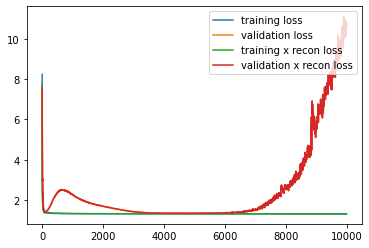

In [9]:
plt.plot(np.arange(epochs),train_loss_ep)
plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_a_ep)
# plt.plot(np.arange(epochs),val_loss_a_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,30))
# plt.xlim((0,1000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [19]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(loss[:3280])
np.argmin(val_loss_x_ep[:])
val_loss_a_ep[4500]

56.63109588623047

In [7]:
testepoch=4490
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    features=featureslist[s+'X_'+training_sample_X]
    if 'dca' in model_str:
        features_raw=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
    num_nodes,num_features = features.shape
    nodesmask=torch.tensor(np.arange(num_nodes))
    
    adj=adj_list[s]
    adj_norm = preprocessing.preprocess_graph(adj)
    adj_label=adj + sp.eye(adj.shape[0])
    adj_label=torch.tensor(adj_label.todense())
    adj_decode=None
    if adj_decodeName == 'gala':
        adj_decode=preprocessing.preprocess_graph_sharp(adj)
    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum() 
    pos_weight=torch.tensor(pos_weight)
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

    if use_cuda:
        features = features.cuda().float()
        adj_norm=adj_norm.cuda()
        adj_label = adj_label.cuda().float()
        nodesmask=nodesmask.cuda()
        if 'dca' in model_str:
            features_raw=features_raw.cuda().float()
    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if 'dca' in model_str:
        loss_x_test=loss_x(features_recon, features,nodesmask,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,nodesmask,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,nodesmask)
    loss_test = loss_x_test+loss_a_test
    
    if 'dca' in model_str:
        features_raw=features_raw.cpu()
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))



   

disease13
test results loss_test: 8.2415 loss_x_test: 1.4472 loss_a_test: 6.7944
control13
test results loss_test: 4.4926 loss_x_test: 1.3108 loss_a_test: 3.1818
disease8
test results loss_test: 7.2285 loss_x_test: 1.2601 loss_a_test: 5.9684
control8
test results loss_test: 7.7294 loss_x_test: 1.3960 loss_a_test: 6.3333


In [17]:
s='control13'
print(s)
features=featureslist[s+'X_'+training_sample_X]
if 'dca' in model_str:
    features_raw=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
num_nodes,num_features = features.shape
nodesmask=torch.tensor(np.arange(num_nodes))

adj=adj_list[s]
adj_norm = preprocessing.preprocess_graph(adj)
adj_label=adj + sp.eye(adj.shape[0])
adj_label=torch.tensor(adj_label.todense())
adj_decode=None
if adj_decodeName == 'gala':
    adj_decode=preprocessing.preprocess_graph_sharp(adj)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum() 
pos_weight=torch.tensor(pos_weight)
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

if use_cuda:
    features = features.cuda().float()
    adj_norm=adj_norm.cuda()
    adj_label = adj_label.cuda().float()
    nodesmask=nodesmask.cuda()
    if 'dca' in model_str:
        features_raw=features_raw.cuda().float()
if adj_decodeName==None:
    adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
else:
    adj_decode=adj_decode.cuda()
    adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)# loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,mse)
loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx)
if 'dca' in model_str:
#     loss_x_test=loss_x(features_recon, features,nodesmask,XreconWeight,ridgeL,features_raw)
    loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,ridgeL,features_raw)
else:
#     loss_x_test=loss_x(features_recon, features,nodesmask,XreconWeight,mse)
    loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight,mse)
# loss_x_test=loss_x(features_recon, features,nodesmask,XreconWeight,mse)
# loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,nodesmask)
# loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx)
loss_test = loss_x_test+loss_a_test
print('test results',
      'loss_test: {:.4f}'.format(loss_test.item()),
      'loss_x_test: {:.4f}'.format(loss_x_test.item()),
      'loss_a_test: {:.4f}'.format(loss_a_test.item()))

control13
test results loss_test: 3.2601 loss_x_test: 2.8062 loss_a_test: 0.4540


In [19]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw, 1), zero_case, nb_case)
# ridge = ridgePi*pi*pi
# result += ridge

In [20]:
result[:8,:6]

tensor([[2.6402e-02, 2.4067e-02, 2.5978e-02, 2.0095e-02, 2.9534e-02, 2.6715e-02],
        [9.6916e-04, 8.0558e-04, 8.7240e-04, 5.2913e-04, 6.0678e-04, 1.6413e+00],
        [7.8781e-04, 6.9792e-04, 6.8796e-04, 6.2915e-04, 8.1197e-04, 9.8116e-04],
        [9.2012e-04, 7.3144e-04, 8.7788e-04, 7.1551e-04, 2.1110e+00, 1.0636e-03],
        [7.9228e-04, 6.5897e-04, 7.0615e-04, 4.2501e-04, 4.7975e-04, 1.7123e+00],
        [5.4678e-04, 4.9013e-04, 4.6687e-04, 4.3891e-04, 5.6247e-04, 6.8551e-04],
        [1.4460e-03, 1.2043e-03, 1.3117e-03, 8.1906e-04, 9.4327e-04, 1.1714e-03],
        [1.4460e-03, 1.2043e-03, 1.3117e-03, 8.1906e-04, 9.4327e-04, 1.1714e-03]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [18]:
ridge = 0.01*pi*pi
ridge[:8,:8]
# torch.mean(ridge)

tensor([[0.0094, 0.0095, 0.0095, 0.0096, 0.0094, 0.0094, 0.0091, 0.0092],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0099, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0099, 0.0100]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [11]:
features[:8,:6]

tensor([[-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934,  3.1390],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717],
        [-0.2504, -0.1938, -0.1941, -0.1474,  5.7623, -0.2717],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934,  3.5326],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717]],
       device='cuda:0')

In [21]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)


tensor(0.0039, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[nonzeroidx])/torch.sum(result)


tensor(0.9961, device='cuda:0', grad_fn=<DivBackward0>)

In [24]:
torch.sum(result[zeroidx])

tensor(7825.3193, device='cuda:0', grad_fn=<SumBackward0>)

In [20]:
features_recon[3][:8,:6]

tensor([[2.8657, 3.5613, 4.5057, 4.9731, 5.0515, 3.2854],
        [2.4956, 4.5268, 8.2924, 3.9105, 4.5425, 3.2845],
        [3.1710, 4.2593, 5.3327, 5.4882, 5.0153, 4.0579],
        [2.8641, 3.2520, 5.8698, 4.8077, 4.7432, 3.3465],
        [2.4757, 4.6132, 8.5509, 3.9008, 4.5554, 3.2782],
        [3.1596, 4.3181, 5.3601, 5.5689, 5.0421, 4.1195],
        [2.5660, 4.3950, 7.7780, 3.9677, 4.5476, 3.2890],
        [2.5660, 4.3950, 7.7780, 3.9677, 4.5476, 3.2890]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [32]:
# model.pi.weight[:8,:8]
model_str

'gcn_vae_xa_e2_d1_dca'